## Review:

The present contribution focuses on the transfer of water, in liquid or vapour phases
in concrete and rocks. We shall use pore network model (Gosticket all 2013). The input in this model is the PSD of the porous material, and the porosity. The connectivity could be provided as input as well but it is not avalable for the materials of investigation.
Prediction the intrinsic permeability as a function of the pore size distributionResults according to the model over a rather wide variety of porous materials are compared to 
experimental data available in the litterature.

The extension of the model to the prediction of water and vapour relative permeability as a
function of the liquid phase saturation level is discussed in section 3. Comparisons between
the model predictions and experimental data available in the literature on the materials
considered in section 2 are discussed.

### Prediction of intrinsic permeability 
 
The models allow to compute the variation of intrinsic permeabilty 
In this paper, we shall restrict the analysis to the prediction of the intrinsic permeability of
intact concrete and rocks.


# Common functions

The following Python code provides a sophisticated framework for performing comprehensive two-phase relative permeability simulations within pore network models, a critical area in fluid mechanics and porous media transport. The central function, perform_relative_permeability_simulation, takes an OpenPNM network as input and systematically computes the relative permeabilities of wetting and non-wetting phases.

The simulation begins by enhancing the geometric fidelity of the pore network through the explicit addition of models for throat.length, pore.volume, throat.total_volume, and throat.lens_volume, ultimately calculating an effective throat.volume. This precise volumetric accounting is essential for accurate saturation calculations and flow simulations. Subsequently, two fluid phases, 'air' (representing the non-wetting phase) and 'water' (representing the wetting phase), are instantiated. Critical phase properties such as air's surface tension and contact angle are defined, along with basic physics models for both fluids. Although not the primary focus of permeability, throat diffusivity values are set and a diffusive conductance model is applied, indicating capabilities for future or integrated mass transport analyses.

The core of the two-phase flow simulation relies on an Invasion Percolation (IP) algorithm (op.algorithms.InvasionPercolation), which simulates the non-wetting phase displacing the wetting phase under capillary pressure. By setting specific inlet pores (e.g., on the 'right' face), IP determines the invasion sequence, crucial for tracking the evolving fluid occupancy within the network. Following IP, the simulation proceeds to calculate relative permeabilities across a range of non-wetting phase saturations. This is achieved by iterating through invasion steps, where the sat_occ_update utility function dynamically updates the pore.occupancy and throat.occupancy flags for both phases. Crucially, the op.models.physics.multiphase.conduit_conductance model is employed for both phases. This model intelligently adjusts the hydraulic conductance of each throat based on its current fluid occupancy, ensuring that flow is accurately represented through the interconnected, phase-specific pathways. For each saturation state, a flow solver (via the Rate_calc helper function, which internally uses op.algorithms.StokesFlow) computes the effective volumetric flow rates for both the non-wetting and wetting phases. These effective rates are then normalized by their respective absolute flow rates (i.e., flow under fully saturated conditions) to yield the relative permeability curves as a function of non-wetting phase saturation.

Beyond the core perform_relative_permeability_simulation function, the code includes several supporting components. Analytical models like van_genuchten_krw and van_genuchten_krn provide standard empirical fits for relative permeability curves, suggesting a capability for curve-fitting and parameter estimation. Fluid property models like viscosity_arrhenius and surface_tension_model allow for temperature-dependent property variations, enhancing realism. Utility functions such as compute_diffusivity and compute_viscosity (based on the Einstein-Stokes equation) provide further physical property calculations. The compute_intrinsic_permeability function independently determines the absolute permeability of the network through a single-phase Stokes flow simulation. Finally, the visualize_simulation_results function serves as a crucial visualization tool, plotting the generated relative permeability curves with customizable styles for clear scientific presentation. This comprehensive suite of functions allows for in-depth numerical investigation into multiphase flow phenomena in complex porous architectures.

In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import os

print("************************** Function for creating network from pore size distribution **********")

#Function to generate synthetic data from a GMM
def generate_data_from_gmm(gmm, num_samples=1000):
    samples, _ = gmm.sample(num_samples)
    return np.exp(samples.flatten())

# Function to load experimental data from a CSV file
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path,delimiter=';')
    data = {'x': df['x'].values.tolist(), 'y': df['y'].values.tolist()}
    return data

#Main function to create synthetic pore size list from CSV file
def create_synthetic_pore_sizes(csv_file_path, num_samples=40000):
    # Load experimental data from CSV file
    data = load_data_from_csv(csv_file_path)
    # Convert the pore size distribution to a probability density function
    x = np.array(data['x'])
    y = np.array(data['y'])
    pdf = y / np.sum(y)

    # Generate synthetic pore sizes based on the PDF
    np.random.seed(0)  # For reproducibility
    r = np.random.choice(x, size=1000, p=pdf)

    # Identify peaks in the experimental data
    peaks, _ = find_peaks(y, height=0)
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Fit a Gaussian Mixture Model to the data
    n_components = len(peaks)
    gmm = GaussianMixture(n_components=n_components, random_state=0, n_init=10, max_iter=5000)
    log_r = np.log(r).reshape(-1, 1)
    gmm.fit(log_r)

    # Generate synthetic data
    synthetic_data = generate_data_from_gmm(gmm, num_samples=num_samples)
    
    return synthetic_data

def create_synthetic_pore_sizes_from_dict(experimental_data_dict, num_samples=40000):
    synthetic_data_dict = {}
    num_files = len(experimental_data_dict)
    fig, axes = plt.subplots(num_files, 1, figsize=(8, 4 * num_files))
    
    if num_files == 1:
        axes = [axes]
    
    for i, (key, csv_file_path) in enumerate(experimental_data_dict.items()):
        synthetic_data = create_synthetic_pore_sizes(csv_file_path, num_samples)
        synthetic_data_dict[key] = synthetic_data
        
        # Plot the generated pore size distributions using seaborn kdeplot in separate subplots
        sns.kdeplot(synthetic_data, ax=axes[i], label=key,fill=False)
        axes[i].set_xlabel('Pore Size')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'Generated Pore Size Distribution for {key}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return synthetic_data_dict

# Function to create pore networks from a dictionary of synthetic pore sizes
def create_pore_networks_from_dict(synthetic_data_dict, geometry_shape='cubic', sample_shape=[200, 200, 1],connectivity=6):
    pore_networks_dict = {}
    for key, pore_sizes in synthetic_data_dict.items():
        pore_network = create_pore_network(pore_sizes, geometry_shape, sample_shape,connectivity)
        pore_networks_dict[key] = pore_network
    return pore_networks_dict
#======================================= CORE CODE: Genertae the network ==========================================================
# Function to create a pore network from pore sizes
def create_pore_network(pore_sizes, geometry_shape='cubic', sample_shape=[200, 200, 1],connectivity=26):
    print("Initial number of pores size", len(pore_sizes))
    if len(pore_sizes) == 0:
        raise ValueError("Pore size data is empty. Cannot create pore network.")

    network_types = {
        'cubic': op.network.Cubic,
        'voronoi': op.network.Voronoi,
        'delaunay': op.network.Delaunay,
        'voronoidual': op.network.DelaunayVoronoiDual
    }

    if geometry_shape.lower() not in network_types:
        raise ValueError(f"Unsupported geometry shape: {geometry_shape}. Must be one of {list(network_types.keys())}.")

    NetworkClass = network_types[geometry_shape.lower()]

    if geometry_shape.lower() in ['voronoi', 'delaunay', 'voronoidual']:
        points = np.random.rand(len(pore_sizes), 3)  # Generate random points in 3D
        pn = NetworkClass(shape=sample_shape, points=points)
    else:
        pn = NetworkClass(shape=sample_shape, spacing=1e-6,connectivity=connectivity)
        
    pn.add_model(propname='pore.seed', model=op.models.misc.random, element='pore', num_range=[0, 1])
    pn.add_model(propname='throat.seed', model=op.models.misc.random, element='throat', num_range=[0, 1])
    mods = op.models.collections.geometry.cubes_and_cuboids # TEST CYLINDERS AND SPHERES 
    pn.add_model_collection(mods)
    pn.regenerate_models()
    if pn.Np > len(pore_sizes):
        # If cubic sample has more pores, extend pore sizes by random choice
        pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=True)
    elif pn.Np < len(pore_sizes):
        # If cubic sample has fewer pores, resample pore sizes
        pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=False)  
    print("Modified number of pores size", len(pore_sizes))
    #==============  IS IT NECESSARY TO COVERT THE SIZE UNIT FROM NANOMETER TO METER ?
    pn['pore.diameter'] = np.array(pore_sizes) * 1e-9  # Convert nm to meters
    pn.regenerate_models()
    
    return pn
#========================== END OF CREATION OF NETWORK =======================================================
print("************************** Functions for pore scale simulations *********************")
# Function to perform relative permeability simulations for each pore network
def perform_simulations_for_networks(pore_networks_dict):
    results = {}
    for key, pn in pore_networks_dict.items():
        results[key] = perform_relative_permeability_simulation(pn)
    return results

# Function to perform relative permeability simulation on a pore network
def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0 #180
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

# Van Genuchten-Mualem model functions with optimization parameters
def van_genuchten_krw(Sw, nk, b):
    return Sw**nk * (1 - (1 - Sw**b)**(1/b))**2

def van_genuchten_krn(Sw, na, b):
    return (1 - Sw)**na * (1 - Sw**(1/b))**(2*b)

# Effective saturation range
Se = np.linspace(0, 1, 500)

# Define the optimization function for Kr_water and Kr_air
def objective(params, saturation, kr_water, kr_air):
    nk, na, b = params
    krw_fit = van_genuchten_krw(saturation, nk, b)
    krn_fit = van_genuchten_krn(saturation, na, b)
    error = np.sum((kr_water - krw_fit)**2 + (kr_air - krn_fit)**2)
    return error

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

def visualize_simulation_results(simulation_results):
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    colors = ['b', 'g', 'c', 'r', 'k', 'y']
    line_width = 2.5
    for idx, (key, result) in enumerate(simulation_results.items()):
        Snwparr, relperm_nwp, relperm_wp = result
        saturation = 1 - np.array(Snwparr)
        linestyle_nwp = line_styles[idx % len(line_styles)]
        linestyle_wp = line_styles[(idx) % len(line_styles)]
        color_nwp = colors[idx % len(colors)]
        color_wp = colors[idx % len(colors)]
        
        plt.plot(saturation, relperm_nwp, label=f'Kr air - {key}', linestyle=linestyle_nwp, color=color_nwp, linewidth=line_width)
        plt.plot(saturation, relperm_wp, label=f'Kr water - {key}', linestyle=linestyle_wp, color=color_wp, linewidth=line_width)
    plt.xlabel('Saturation')
    plt.ylabel('Relative Permeability')
    plt.title('Relative Permeability vs Saturation')
    plt.legend()
    plt.grid()
    plt.show()
    
def compute_intrinsic_permeability(pore_networks_dict):
    intrinsic_permeability_results = {}
    for key, pn in pore_networks_dict.items():
        # Set up water phase and Stokes flow algorithm
        phase = op.phase.Phase(network=pn)
        #phase=op.phase.Water(network=pn, name='water')
        phase['pore.viscosity'] = 0.001 # viscosite de l'eau à 20 C
        phase.add_model_collection(op.models.collections.physics.basic)
        phase.regenerate_models()
        
        inlet = pn.pores('left')
        outlet = pn.pores('right')
        
        flow = op.algorithms.StokesFlow(network=pn, phase=phase)
        flow.set_value_BC(pores=inlet, values=1)
        flow.set_value_BC(pores=outlet, values=0)
        flow.run()
        
        phase.update(flow.soln)  # Update phase properties
        Q = flow.rate(pores=inlet, mode='group')[0]
        A =  op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
        L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
        
        # Compute intrinsic permeability
        K = Q * L / A  # Since viscosity and pressure difference are assumed to be 1
        intrinsic_permeability_results[key] = K / 0.98e-12 * 1000  # Convert to mD
        print(f'The value of intrinsic permeability for {key} is: {intrinsic_permeability_results[key]:.5f} mD')
    
    return intrinsic_permeability_results

************************** Function for creating network from pore size distribution **********
************************** Functions for pore scale simulations *********************


This Python code provides a robust framework for simulating and analyzing two-phase relative permeability in porous media, directly linking microstructural pore network models to macroscopic flow behavior, and validating these predictions against experimental data.

The `perform_relative_permeability_simulation` function initiates this process by first establishing a precise geometric representation of the input pore network (`pn`). It meticulously adds models for throat length (`throat_length.spheres_and_cylinders`), pore volume (`pore_volume.sphere`), and various components of throat volume (`throat_volume.cylinder` for total volume, `throat_volume.lens` for the constricting lens region, and `misc.difference` to calculate the effective throat volume). This detailed geometric assignment is critical for accurate hydraulic and diffusive calculations. Following this, two fluid phases, 'air' (non-wetting) and 'water' (wetting), are defined within the network. Essential fluid properties, such as air's surface tension and contact angle, are assigned, and basic physics models are associated with both phases. Notably, constant throat diffusivity values are set for both phases, enabling the subsequent application of the `diffusive_conductance.ordinary_diffusion` model to simulate molecular transport.

The core of the two-phase flow simulation commences with an **Invasion Percolation (IP)** algorithm, which computationally mimics the non-wetting phase (air) invading a water-saturated porous medium under increasing capillary pressure. By setting an inlet boundary condition (e.g., at specific pores on the 'right' face), IP determines the sequence in which pores and throats are invaded, thereby establishing the fluid occupancy state across the network at different saturation levels. Building upon this invasion sequence, the simulation proceeds to calculate relative permeabilities across a range of non-wetting phase saturations. This is achieved by iteratively updating the `pore.occupancy` and `throat.occupancy` attributes for both phases based on the IP results. For each saturation step, the `physics.multiphase.conduit_conductance` model is employed to dynamically re-calculate the hydraulic conductance of each throat. This model intelligently accounts for the presence of multiple phases, allowing flow only through regions occupied by the respective fluid. By running `StokesFlow` algorithms for each phase under these dynamic occupancy conditions, the effective flow rates of air and water are determined. These effective rates are then normalized by their respective absolute flow rates (calculated under single-phase saturated conditions), yielding the relative permeabilities ($K_{r,air}$ and $K_{r,water}$) as a function of saturation.

The `visualize_results` function then serves as a critical tool for scientific dissemination and model validation. It takes the simulated relative permeability curves and plots them alongside experimental data. The function is designed for high-quality scientific figures, employing professional `matplotlib` styling, customizable font sizes, and distinguishable color palettes and markers for various simulated and experimental datasets. It plots the simulated air and water relative permeabilities as continuous lines against wetting phase saturation, while experimental data points from provided CSV files are overlaid as discrete scatter points. Robust error handling is integrated to manage missing files or malformed data, ensuring the visualization process is resilient. The function also includes automatic normalization of experimental data if necessary, and offers options to save the high-resolution plot to disk, facilitating direct inclusion in publications and presentations. The `if __name__ == "__main__":` block illustrates a typical workflow: it reads experimental pore size distribution data, generates synthetic pore networks from these distributions, runs the two-phase flow simulations using `perform_relative_permeability_simulation`, and finally visualizes the predicted relative permeabilities against available experimental benchmarks, providing a comprehensive analysis pipeline from microstructure to macroscopic transport properties.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

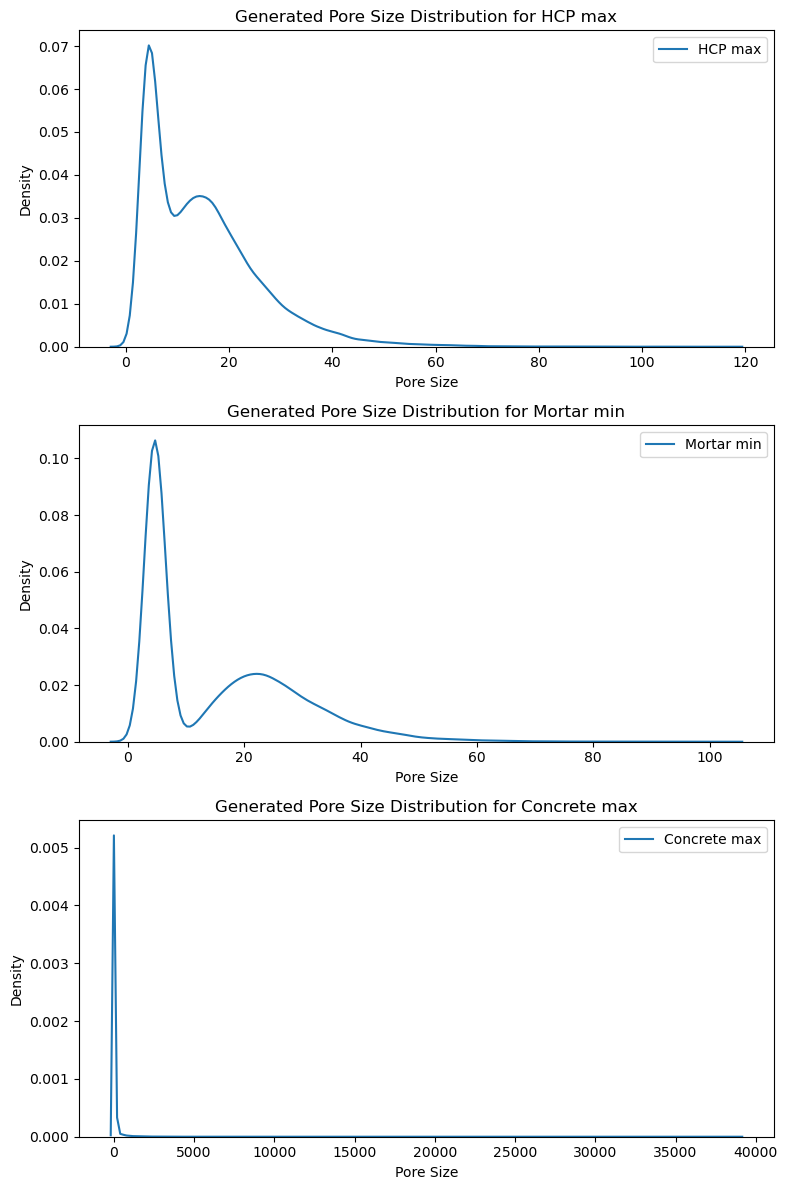

{'HCP max': array([28.4071041 , 52.81849537, 43.96547945, ...,  3.09990893,
        2.47873385,  5.72725054]), 'Mortar min': array([35.43208317, 56.57081717, 49.25936437, ...,  3.60552073,
        3.10918281,  5.4142064 ]), 'Concrete max': array([63.71698516, 45.04696206, 45.73482132, ...,  3.52407905,
        3.52142327,  3.90376473])}
Initial number of pores size 40000
Modified number of pores size 40000
Initial number of pores size 40000
Modified number of pores size 40000
Initial number of pores size 40000
Modified number of pores size 40000
{'HCP max': net : <openpnm.network.Cubic at 0x1f3657fc5a0>, 'Mortar min': net : <openpnm.network.Cubic at 0x1f3670e3bb0>, 'Concrete max': net : <openpnm.network.Cubic at 0x1f36686f700>}


ValueError: Chemical name (o2) not recognized

In [ ]:



#Function to perform relative permeability simulation on a pore network
def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)


def visualize_results(simulation_results, experimental_results, save_directory=None, save_name="These_mazen_Relative_Permeability_Plot.png"):
    """
    Visualize simulated relative permeability results and compare them with experimental data.

    Parameters:
        simulation_results (dict): Dictionary where keys are sample names and values are tuples containing:
                                   - Saturations (Snwp_arr)
                                   - Relative permeabilities for non-wetting phase (relperm_nwp)
                                   - Relative permeabilities for wetting phase (relperm_wp)
        experimental_results (dict): Dictionary where keys are sample names and values are paths to experimental CSV files.
                                     CSV files should have columns ['saturation', 'RelPerm'].
        save_directory (str, optional): Directory to save the plot. Defaults to None (no saving).
        save_name (str, optional): Name of the saved plot file. Defaults to "Relative_Permeability_Plot.png".
    """
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '*']
    colors = ['b', 'r', 'g', 'k', 'c', 'm']
    line_width = 2.5
    marker_size = 8

    # Plot simulation results
    for idx, (key, result) in enumerate(simulation_results.items()):
        try:
            Snwparr, relperm_nwp, relperm_wp = result
            saturation = 1 - np.array(Snwparr)

            linestyle_nwp = line_styles[idx % len(line_styles)]
            linestyle_wp = line_styles[idx % len(line_styles)]
            marker_nwp = markers[idx % len(markers)]
            marker_wp = markers[(idx + 1) % len(markers)]
            color_nwp = colors[idx % len(colors)]
            color_wp = colors[idx % len(colors)]

            plt.plot(saturation, relperm_nwp, label=f'Simulation Kr air - {key}',
                     linestyle=linestyle_nwp, color=color_nwp, marker=marker_nwp,
                     linewidth=line_width, markersize=marker_size)
            plt.plot(saturation, relperm_wp, label=f'Simulation Kr water - {key}',
                     linestyle=linestyle_wp, color=color_wp, marker=marker_wp,
                     linewidth=line_width, markersize=marker_size)
        except Exception as e:
            print(f"Failed to plot simulation results for {key}: {e}")

    # Plot experimental results
    for idx, (key, csv_file) in enumerate(experimental_results.items()):
        try:
            exp_data = pd.read_csv(csv_file, delimiter=";")
            saturation = exp_data['saturation']
            relperm = exp_data['RelPerm']/max(exp_data['RelPerm'])  

            color_exp = colors[(idx * 2) % len(colors)]
            marker_exp = markers[(idx * 2 + 1) % len(markers)]

            plt.scatter(saturation, relperm, label=f'Experimental Kr - {key}',
                        color=color_exp, marker=marker_exp, s=marker_size * 20)
        except Exception as e:
            print(f"Failed to plot experimental results for {key}: {e}")

    # Labels, title, legend, and grid
    plt.xlabel('Saturation', fontsize=16)
    plt.ylabel('Relative Permeability', fontsize=16)
    plt.title('Relative Permeability vs Saturation', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    # Save the plot if save_directory is provided
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)  # Ensure directory exists
        save_path = os.path.join(save_directory, save_name)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    plt.show()

# Example usage
if __name__ == "__main__":

    experimental_data_dict = {
        #"HCP min":"psd_from_these_mazen_HCP_min.csv",
        "HCP max":"psd_from_these_mazen_HCP_max.csv",
        "Mortar min":"psd_from_these_mazen_mortar_min.csv",
        #"Mortar max": "psd_from_these_mazen_mortar_max.csv",
        #"Concrete min": "psd_from_these_mazen_concrete_min.csv",
        "Concrete max":"psd_from_these_mazen_concrete_max.csv"
    }
    
    experimental_results = {
        'Concrete': 'rel_perm_concrete_these_mazen.csv',
        'Mortar': 'rel_perm_mortar_these_mazen.csv',
        'HCP':'rel_perm_HCP_these_mazen.csv'
    }
        
    synthetic_pore_sizes_dict = create_synthetic_pore_sizes_from_dict(experimental_data_dict)
    print(synthetic_pore_sizes_dict)
    synthetic_pore_sizes_dict['HCP max']
    #Create pore networks from synthetic pore sizes
    pore_networks_dict = create_pore_networks_from_dict(synthetic_pore_sizes_dict,geometry_shape='cubic',sample_shape=[200, 200,1],connectivity=6)
    print(pore_networks_dict)
    # Perform simulations for each pore network
    simulation_results = perform_simulations_for_networks(pore_networks_dict)
    print(simulation_results)
    # Visualize simulation results
    output_directory="These_mazen_results"
    #visualize_results(simulation_results, experimental_results, save_directory=output_directory, save_name="These_mazen_Relative_Permeability_Plot.png")
    
    

### Fitting with analytical models 

Plotting simulation results...
Plotting experimental results...
Experimental data file not found: rel_perm_concrete_these_mazen.csv. Skipping 'Concrete'.
  VG Fit for Mortar: nk=0.10, b=0.66, R^2=0.78
  BC Fit for Mortar: n_lambda=0.67, R^2=0.60
  VG Fit for HCP: nk=0.10, b=0.78, R^2=0.88
  BC Fit for HCP: n_lambda=8.14, R^2=0.81
Plot saved to: scientific_relative_permeability_plot.png


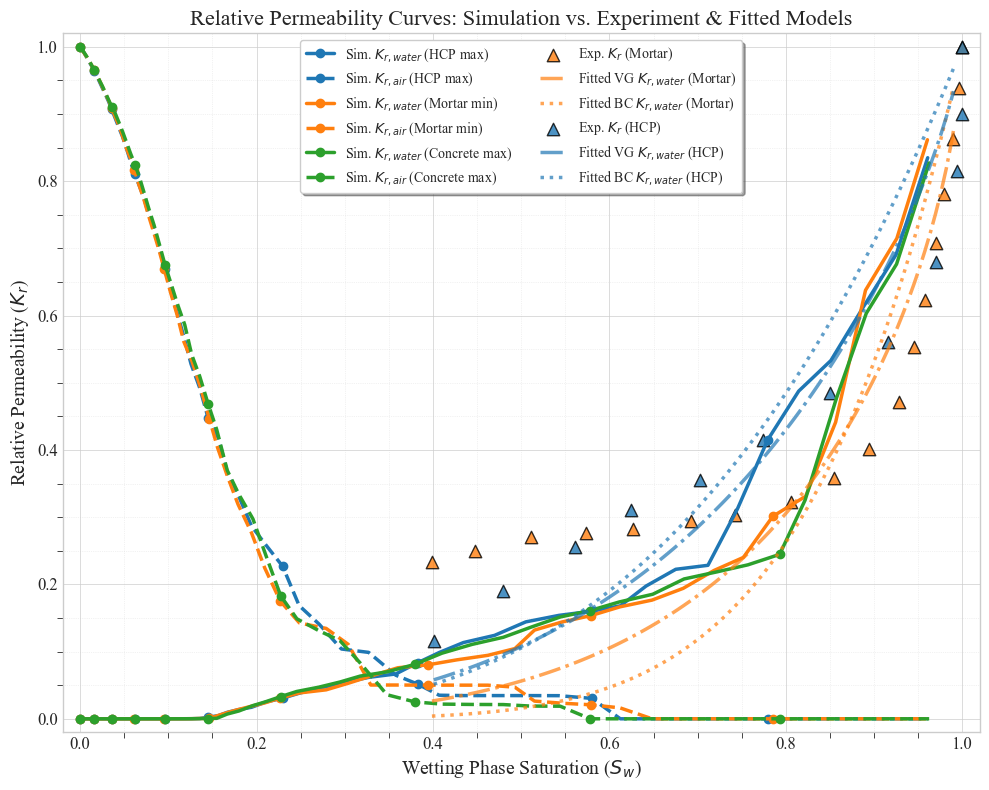

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os # Import os for path manipulation
from scipy.optimize import curve_fit # Import curve_fit for model fitting

def visualize_results_scientific(
    simulation_results,
    experimental_results=None, # Made optional
    fit_analytical_models=True, # New: Flag to enable fitting analytical models to experimental data
    fig_size=(10, 8),          # Standardized figure size
    font_size_labels=14,       # Font size for axis labels
    font_size_ticks=12,        # Font size for tick labels
    font_size_legend=10,       # Font size for legend entries
    show_plot=True,            # Option to show plot interactively
    save_path=None,            # Path to save the figure (e.g., 'output/my_plot.png')
    dpi=300                    # Dots per inch for saved image quality
):
    """
    Visualizes simulated relative permeability results and compares them with
    experimental data, optimized for scientific publications. It also includes
    options to fit and plot analytical models (Van Genuchten-Mualem, Brooks-Corey)
    to the experimental data.

    Parameters
    ----------
    simulation_results : dict
        Dictionary where keys are simulation sample names (str) and values are
        tuples containing:
        - Snwparr (list or np.array): Non-wetting phase saturation values.
        - relperm_nwp (list or np.array): Relative permeability values for the
          non-wetting phase.
        - relperm_wp (list or np.array): Relative permeability values for the
          wetting phase.
    experimental_results : dict, optional
        Dictionary where keys are experimental sample names (str) and values
        are paths to experimental CSV files (str).
        Each CSV file is expected to contain columns:
        - 'saturation': Saturation values.
        - 'RelPerm': Relative permeability values (assumed to be already normalized
          or will be normalized by its max value for plotting consistency).
    fit_analytical_models : bool, optional
        If True, the Van Genuchten-Mualem and Brooks-Corey models will be fitted
        to the experimental data and plotted.
    fig_size : tuple, optional
        Dimensions of the figure (width, height) in inches.
    font_size_labels : int, optional
        Font size for X and Y axis labels.
    font_size_ticks : int, optional
        Font size for axis tick labels.
    font_size_legend : int, optional
        Font size for legend entries.
    show_plot : bool, optional
        If True, the plot will be displayed interactively.
    save_path : str, optional
        If provided, the plot will be saved to this file path.
        Include file extension (e.g., '.png', '.pdf', '.svg').
    dpi : int, optional
        Resolution for saved raster images (PNG). Ignored for vector formats (PDF, SVG).

    Returns
    -------
    None
        Displays or saves the plot.
    """
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean, modern grid style
    plt.rcParams['font.family'] = 'serif' # Use serif fonts for a classic scientific look
    plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'serif'] # Specify serif font
    
    fig, ax = plt.subplots(figsize=fig_size)

    # --- Define analytical models ---
    # Van Genuchten-Mualem models
    # Note: These models typically use EFFECTIVE SATURATION (Se).
    # If experimental 'saturation' is total saturation (Sw), and residual saturations
    # are non-zero, then Sw_eff = (Sw - Swr) / (1 - Swr - Snwr).
    # For fitting here, we assume the input Sw_eff from 'saturation_exp' is directly the effective saturation.
    def van_genuchten_krw(Sw_eff, nk, b):
        # Ensure arguments are arrays for vectorized operations
        Sw_eff = np.asarray(Sw_eff)
        # Handle cases where (1 - Sw_eff**(1/b)) might be negative due to numerical issues or non-physical b
        val = 1 - Sw_eff**(1/b)
        val[val < 0] = 0 # Clip negative values
        return Sw_eff**nk * (1 - val**b)**2

    def van_genuchten_krn(Sw_eff, na, b):
        Sw_eff = np.asarray(Sw_eff)
        val = 1 - Sw_eff**(1/b)
        val[val < 0] = 0
        return (1 - Sw_eff)**na * (1 - val)**(2*b)


    # Brooks-Corey models
    # Note: These models typically use EFFECTIVE SATURATION (Se).
    def brooks_corey_krw(Sw_eff, n_lambda):
        Sw_eff = np.asarray(Sw_eff)
        # Avoid division by zero or large exponents for n_lambda close to 0
        n_lambda = np.clip(n_lambda, 0.01, None) # Ensure n_lambda is positive
        return Sw_eff**((2 + 3 * n_lambda) / n_lambda)

    def brooks_corey_krn(Sw_eff, n_lambda):
        Sw_eff = np.asarray(Sw_eff)
        n_lambda = np.clip(n_lambda, 0.01, None)
        return (1 - Sw_eff)**2 * (1 - Sw_eff**((2 + n_lambda) / n_lambda))


    # --- Define a mapping for base material names to consistent colors ---
    base_material_colors = {
        'HCP': '#1f77b4',  # Muted Blue
        'Mortar': '#ff7f0e', # Muted Orange
        'Concrete': '#2ca02c', # Muted Green
        'Sandstone': '#d62728', # Muted Red
        'Macena': '#9467bd', # Muted Purple
        'Chen': '#8c564b', # Muted Brown
    }

    # Define markers and line styles
    sim_line_style_wp = '-'    # Solid line for wetting phase simulation
    sim_line_style_nwp = '--'  # Dashed line for non-wetting phase simulation
    sim_marker_style = 'o'     # Marker for simulation points (e.g., circular)
    exp_marker_style = '^'     # Different marker for experimental points (e.g., triangle up)
    
    # Analytical model line styles (distinct from sim/exp)
    vg_fit_line_style = '-.' # Dash-dot line for Van Genuchten fit
    bc_fit_line_style = ':'  # Dotted line for Brooks-Corey fit

    # Helper to get base material name from complex keys like "HCP max"
    def get_base_material_name(key_name):
        return key_name.split(' ')[0]


    # --- Plot simulation results ---
    print("Plotting simulation results...")
    for idx, (key, result) in enumerate(simulation_results.items()):
        try:
            Snwparr, relperm_nwp, relperm_wp = result
            # Convert non-wetting saturation to wetting saturation
            saturation_sw = 1 - np.array(Snwparr)

            # Ensure data is sorted by saturation for proper plotting
            sort_indices = np.argsort(saturation_sw)
            saturation_sw_sorted = saturation_sw[sort_indices]
            relperm_nwp_sorted = np.array(relperm_nwp)[sort_indices]
            relperm_wp_sorted = np.array(relperm_wp)[sort_indices]

            # Get the base material name for consistent coloring
            base_material = get_base_material_name(key)
            current_color = base_material_colors.get(base_material, 'k') # Default to black if not found
            
            ax.plot(saturation_sw_sorted, relperm_wp_sorted,
                    label=f'Sim. $K_{{r,water}}$ ({key})',
                    linestyle=sim_line_style_wp, # Solid line for wetting phase
                    color=current_color,
                    linewidth=2.5,
                    marker=sim_marker_style,
                    markersize=6,
                    markevery=max(1, len(saturation_sw_sorted) // 10) # Mark a few points for clarity
                    )
            ax.plot(saturation_sw_sorted, relperm_nwp_sorted,
                    label=f'Sim. $K_{{r,air}}$ ({key})',
                    linestyle=sim_line_style_nwp, # Dashed line for non-wetting phase
                    color=current_color,
                    linewidth=2.5,
                    marker=sim_marker_style, # Same marker as water for same sim
                    markersize=6,
                    markevery=max(1, len(saturation_sw_sorted) // 10)
                    )
        except (ValueError, TypeError, IndexError) as e:
            print(f"Skipping simulation result for '{key}' due to data format error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while plotting simulation for '{key}': {e}")


    # --- Plot experimental results and fit analytical models ---
    if experimental_results:
        print("Plotting experimental results...")
        for key, csv_file in experimental_results.items():
            try:
                # Use pandas to read data from CSV
                exp_data = pd.read_csv(csv_file, delimiter=";")
                
                # Check for required columns
                if 'saturation' not in exp_data.columns or 'RelPerm' not in exp_data.columns:
                    raise ValueError(f"CSV '{csv_file}' must contain 'saturation' and 'RelPerm' columns.")

                saturation_exp = exp_data['saturation'].values/max(exp_data['saturation'].values)
                relperm_exp = exp_data['RelPerm'].values/max(exp_data['RelPerm'].values)  

                # Normalize experimental relative permeability if max is not 1 (e.g., if it's effective perm)
                # It's crucial to understand if your 'RelPerm' in CSV is already relative (0-1) or effective.
                # For fitting, Sw_eff should be used. Here, we assume saturation_exp is Sw_eff.
                if np.max(relperm_exp) > 1.01 or np.max(relperm_exp) <= 0:
                    print(f"Warning: Normalizing experimental RelPerm for '{key}' (max was {np.max(relperm_exp):.2f}). Ensure this is intended.")
                    relperm_exp = relperm_exp / np.max(relperm_exp)
                
                # Get the base material name for consistent coloring
                base_material = get_base_material_name(key)
                current_color = base_material_colors.get(base_material, 'k') # Default to black if not found

                ax.scatter(saturation_exp, relperm_exp,
                           label=f'Exp. $K_r$ ({key})',
                           color=current_color,
                           marker=exp_marker_style,
                           s=80, # Larger marker size for scatter points
                           edgecolors='k', # Black edge for better visibility
                           alpha=0.8
                           )
                
                # --- Fit and plot analytical models if requested ---
                if fit_analytical_models:
                    # Create a smooth saturation range for plotting the fitted curves
                    # Ensure it covers the experimental data range, but can extend slightly
                    Sw_plot = np.linspace(np.min(saturation_exp), np.max(saturation_exp), 100) 
                    # Clip to 0-1 range for plotting if fitting extends beyond
                    Sw_plot = np.clip(Sw_plot, 0.01, 0.99)


                    # Van Genuchten-Mualem fitting for Krw
                    try:
                        # Initial guesses for (nk, b) for Krw fitting
                        # nk: affects shape, typically > 1 (e.g., 1 to 5)
                        # b: related to pore size distribution, typically > 0 (e.g., 0.1 to 3)
                        p0_vg_krw = [2.0, 0.5] # Updated initial guesses based on typical curve shapes
                        bounds_vg_krw = ([0.1, 0.01], [10.0, 5.0]) # More refined bounds

                        # Fit only Krw model using provided van_genuchten_krw function
                        popt_vg_krw, pcov_vg_krw = curve_fit(
                            van_genuchten_krw,
                            saturation_exp,
                            relperm_exp,
                            p0=p0_vg_krw,
                            bounds=bounds_vg_krw,
                            maxfev=5000 # Increase max function evaluations for robustness
                        )
                        
                        krw_vg_fitted = van_genuchten_krw(Sw_plot, *popt_vg_krw)
                        ax.plot(Sw_plot, krw_vg_fitted,
                                label=f'Fitted VG $K_{{r,water}}$ ({key})',
                                linestyle=vg_fit_line_style,
                                color=current_color,
                                linewidth=2.5,
                                alpha=0.7
                                )
                        # Calculate R-squared for goodness of fit
                        ss_res = np.sum((relperm_exp - van_genuchten_krw(saturation_exp, *popt_vg_krw))**2)
                        ss_tot = np.sum((relperm_exp - np.mean(relperm_exp))**2)
                        r_squared_vg = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
                        print(f"  VG Fit for {key}: nk={popt_vg_krw[0]:.2f}, b={popt_vg_krw[1]:.2f}, R^2={r_squared_vg:.2f}")
                    except RuntimeError as e: # Catch RuntimeError for non-convergence
                        print(f"  VG Fit for '{key}' did not converge: {e}")
                    except Exception as e:
                        print(f"  Failed to fit Van Genuchten for '{key}': {e}")


                    # Brooks-Corey fitting for Krw
                    try:
                        # Initial guess for (n_lambda) for Krw fitting
                        # n_lambda: typically > 0 (e.g., 0.1 to 5)
                        p0_bc_krw = [2.0]
                        bounds_bc_krw = ([0.1], [10.0])

                        # Fit only Krw model using provided brooks_corey_krw function
                        popt_bc_krw, pcov_bc_krw = curve_fit(
                            brooks_corey_krw,
                            saturation_exp,
                            relperm_exp,
                            p0=p0_bc_krw,
                            bounds=bounds_bc_krw,
                            maxfev=5000
                        )
                        
                        krw_bc_fitted = brooks_corey_krw(Sw_plot, *popt_bc_krw)
                        ax.plot(Sw_plot, krw_bc_fitted,
                                label=f'Fitted BC $K_{{r,water}}$ ({key})',
                                linestyle=bc_fit_line_style,
                                color=current_color,
                                linewidth=2.5,
                                alpha=0.7
                                )
                        # Calculate R-squared for goodness of fit
                        ss_res = np.sum((relperm_exp - brooks_corey_krw(saturation_exp, *popt_bc_krw))**2)
                        ss_tot = np.sum((relperm_exp - np.mean(relperm_exp))**2)
                        r_squared_bc = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
                        print(f"  BC Fit for {key}: n_lambda={popt_bc_krw[0]:.2f}, R^2={r_squared_bc:.2f}")
                    except RuntimeError as e: # Catch RuntimeError for non-convergence
                        print(f"  BC Fit for '{key}' did not converge: {e}")
                    except Exception as e:
                        print(f"  Failed to fit Brooks-Corey for '{key}': {e}")

            except FileNotFoundError:
                print(f"Experimental data file not found: {csv_file}. Skipping '{key}'.")
            except ValueError as ve:
                print(f"Data error for '{key}' in '{csv_file}': {ve}. Skipping.")
            except Exception as e:
                print(f"An unexpected error occurred while plotting experimental data or fitting for '{key}': {e}")


    # --- Customize plot elements for publication quality ---
    ax.set_xlabel('Wetting Phase Saturation ($S_w$)', fontsize=font_size_labels)
    ax.set_ylabel('Relative Permeability ($K_r$)', fontsize=font_size_labels)
    ax.set_title('Relative Permeability Curves: Simulation vs. Experiment & Fitted Models', fontsize=font_size_labels + 2)

    # Set consistent axis limits
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])

    ax.tick_params(axis='both', which='major', labelsize=font_size_ticks)
    ax.tick_params(axis='both', which='minor', length=4) # Minor ticks for precision
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth=0.7, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

    # Place legend outside the plot area or strategically inside to avoid overlap
    # Adjust number of columns for legend if too many entries
    # A more dynamic way to calculate legend columns or use a fixed one if desired
    num_legend_cols = 1
    # Estimate total entries: 2 (sim) + 1 (exp) + 2 (VG fit) + 2 (BC fit) per material
    # Simplified estimation, could be more complex based on specific labeling
    estimated_entries_per_material = 2 + 1 + (2 if fit_analytical_models else 0) * 1 # 2 sim phases, 1 exp, 1 fit model per material (for Krw)
    if len(simulation_results) * estimated_entries_per_material > 8: # Heuristic for too many entries
        num_legend_cols = 2
    
    ax.legend(fontsize=font_size_legend, loc='best', frameon=True, fancybox=True, shadow=True, ncol=num_legend_cols)

    plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

    # --- Save plot ---
    if save_path:
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    # --- Show plot ---
    if show_plot:
        plt.show()
    plt.close(fig) # Close the figure to free up memory
# Example usage (assuming simulation_results would be generated elsewhere)
if __name__ == "__main__":
    
    experimental_results = {
        'Concrete': 'rel_perm_concrete_these_mazen.csv',
        'Mortar': 'rel_perm_mortar_these_mazen.csv',
        'HCP':'rel_perm_HCP_these_mazen.csv'}
        
    # Call the scientific visualization function
    visualize_results_scientific(
        simulation_results=simulation_results,
        experimental_results=experimental_results,
        save_path="scientific_relative_permeability_plot.png", # Save to a file
        show_plot=True # Also show interactive plot
    )


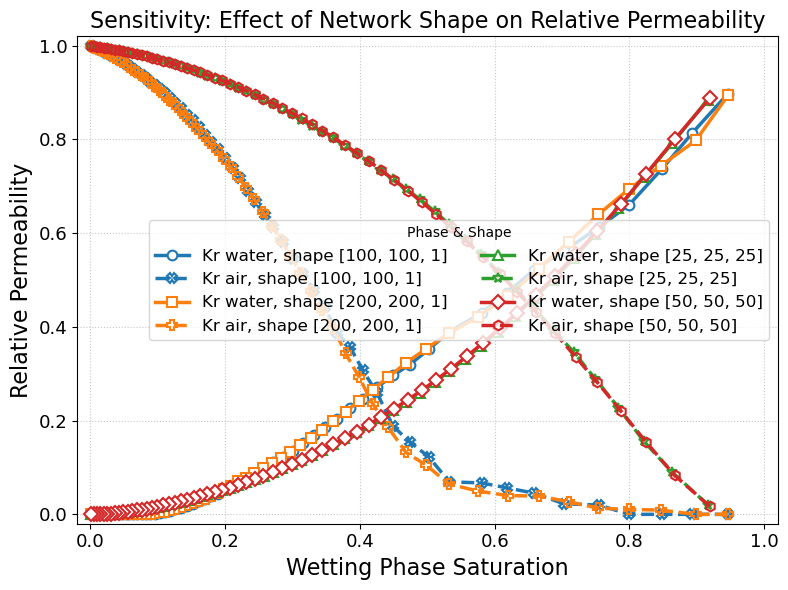

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

line_styles = ['-', '--', '-.', ':']
# Use different markers for water and air, but same color for each shape
water_markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
air_markers = ['X', 'P', '*', 'h', '1', '2', '3', '4']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
line_width = 2.5
marker_size = 7

handles = []
labels = []

for idx, (shape_str, result) in enumerate(shape_results.items()):
    Snwparr, relperm_nwp, relperm_wp = result
    saturation = 1 - np.array(Snwparr)
    color = colors[idx % len(colors)]
    # Wetting phase: solid line, filled marker
    h_wp, = plt.plot(
        saturation, relperm_wp,
        linestyle='-',
        color=color,
        marker=water_markers[idx % len(water_markers)],
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='white',
        markeredgewidth=1.5,
        label=f'Kr water, shape {shape_str}'
    )
    # Non-wetting phase: dashed line, open marker
    h_nwp, = plt.plot(
        saturation, relperm_nwp,
        linestyle='--',
        color=color,
        marker=air_markers[idx % len(air_markers)],
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='none',
        markeredgewidth=1.5,
        label=f'Kr air, shape {shape_str}'
    )
    handles.extend([h_wp, h_nwp])
    labels.extend([f'Kr water, shape {shape_str}', f'Kr air, shape {shape_str}'])

plt.xlabel('Wetting Phase Saturation', fontsize=16)
plt.ylabel('Relative Permeability', fontsize=16)
plt.title('Sensitivity: Effect of Network Shape on Relative Permeability', fontsize=16)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend(handles, labels, fontsize=12, loc='best', frameon=True, ncol=2, title="Phase & Shape")
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()


Testing connectivity: 6
Initial number of pores size 40000
Modified number of pores size 40000


[12:04:46] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=872460;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=853153;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=608317;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=854535;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Testing connectivity: 14
Initial number of pores size 40000
Modified number of pores size 40000


[12:07:26] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=808445;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=544791;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=445654;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=824813;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Testing connectivity: 18
Initial number of pores size 40000
Modified number of pores size 40000


[12:10:15] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=181534;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=538067;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=816592;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=842770;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Testing connectivity: 20
Initial number of pores size 40000
Modified number of pores size 40000


[12:14:08] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=347052;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=659919;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=146738;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=447089;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Testing connectivity: 26
Initial number of pores size 40000
Modified number of pores size 40000


[12:17:21] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=400221;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=180319;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[12:17:22] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=9346;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=310795;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

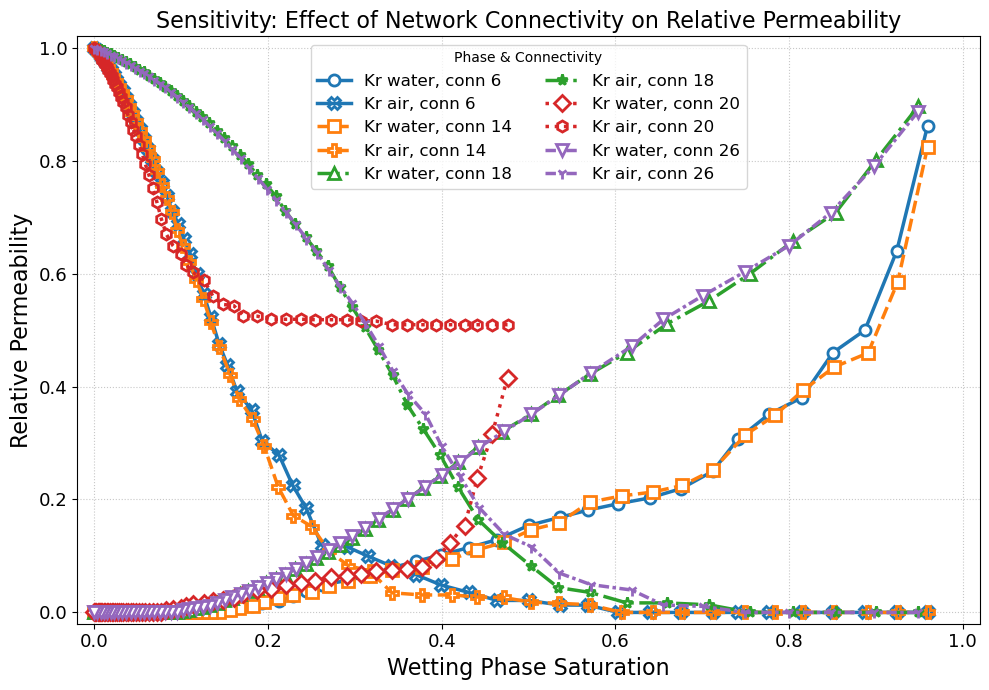

In [11]:
# Sensitivity study on the effect of network connectivity on relative permeability

# Use the HCP pore size distribution from Mazen (already loaded as hcp_pore_sizes)
shape = [200, 200, 1]
connectivities_to_test = [6, 14, 18, 20, 26]

connectivity_results = {}

for idx, conn in enumerate(connectivities_to_test):
    print(f"\nTesting connectivity: {conn}")
    pn = create_pore_network(hcp_pore_sizes, geometry_shape='cubic', sample_shape=shape, connectivity=conn)
    result = perform_relative_permeability_simulation(pn)
    connectivity_results[str(conn)] = result

# Plotting: same color for air/water per connectivity, different symbols, distinguishable in B/W
plt.figure(figsize=(10, 7))

# Use distinguishable markers for B/W printing
water_markers = ['o', 's', '^', 'D', 'v']
air_markers = ['X', 'P', '*', 'h', '1']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # last is dash-dot-dot
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

handles = []
labels = []

for idx, (conn_str, result) in enumerate(connectivity_results.items()):
    Snwparr, relperm_nwp, relperm_wp = result
    saturation = 1 - np.array(Snwparr)
    color = colors[idx % len(colors)]
    # Wetting phase: solid line, filled marker
    h_wp, = plt.plot(
        saturation, relperm_wp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=water_markers[idx % len(water_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='white',
        markeredgewidth=2,
        label=f'Kr water, conn {conn_str}'
    )
    # Non-wetting phase: dashed line, open marker
    h_nwp, = plt.plot(
        saturation, relperm_nwp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=air_markers[idx % len(air_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'Kr air, conn {conn_str}'
    )
    handles.extend([h_wp, h_nwp])
    labels.extend([f'Kr water, conn {conn_str}', f'Kr air, conn {conn_str}'])

plt.xlabel('Wetting Phase Saturation', fontsize=16)
plt.ylabel('Relative Permeability', fontsize=16)
plt.title('Sensitivity: Effect of Network Connectivity on Relative Permeability', fontsize=16)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend(handles, labels, fontsize=12, loc='best', frameon=True, ncol=2, title="Phase & Connectivity")
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

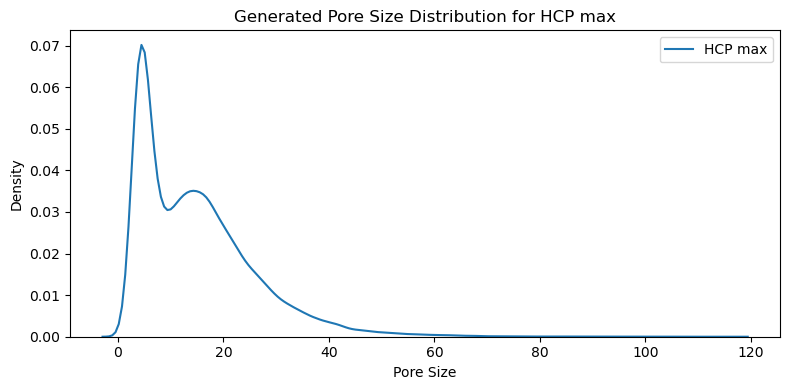


Simulation 1 for connectivity 20
Initial number of pores size 40000
Modified number of pores size 40000


[13:07:30] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=878498;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=683850;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=860730;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=328297;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 2 for connectivity 20
Initial number of pores size 40000
Modified number of pores size 40000


[13:10:40] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=125673;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=655238;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=13377;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=636391;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 3 for connectivity 20
Initial number of pores size 40000
Modified number of pores size 40000


[13:14:14] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=130201;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=309508;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=987800;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=317301;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 4 for connectivity 20
Initial number of pores size 40000
Modified number of pores size 40000


[13:18:34] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=171174;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=128470;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[13:18:35] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=733267;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=386983;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 5 for connectivity 20
Initial number of pores size 40000
Modified number of pores size 40000


[13:23:31] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=917331;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=732306;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=82882;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=616229;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

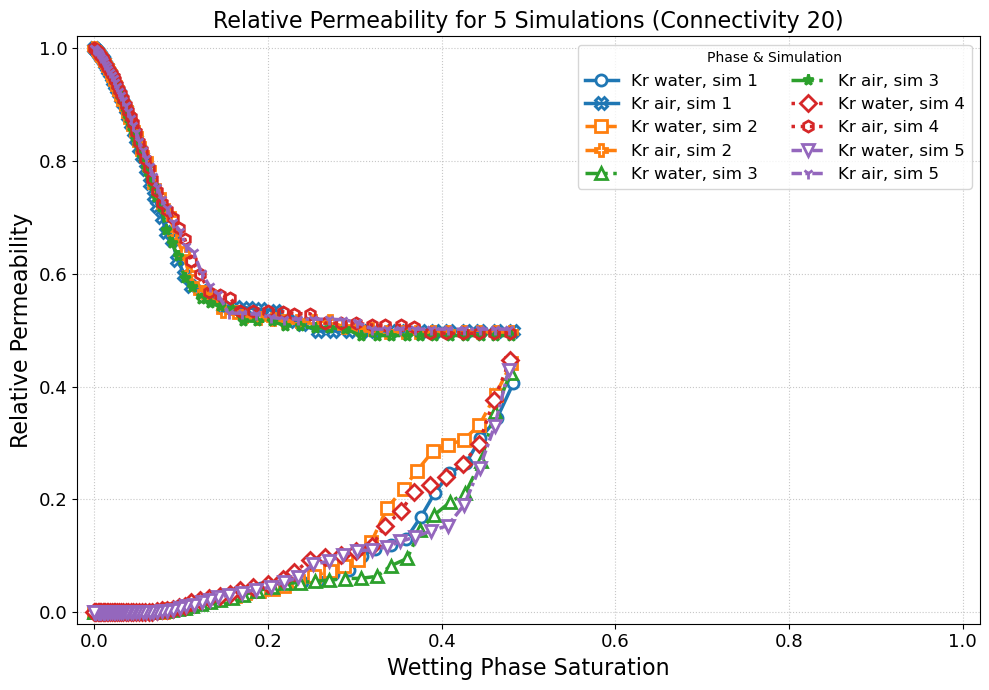

In [9]:
# Run 5 simulations for connectivity 20 with shape [200, 200, 1]
shape = [200, 200, 1]
connectivity = 20
num_simulations = 5

connectivity_20_results = {}
experimental_data_dict = {
    "HCP max": "psd_from_these_mazen_HCP_max.csv"
}

# Generate synthetic pore sizes from the specified data file
hcp_pore_sizes = create_synthetic_pore_sizes_from_dict(experimental_data_dict)

synthetic_pore_sizes_dict['HCP max']
for sim_idx in range(num_simulations):
    print(f"\nSimulation {sim_idx + 1} for connectivity {connectivity}")
    pn = create_pore_network(hcp_pore_sizes["HCP max"], geometry_shape='cubic', sample_shape=shape, connectivity=connectivity)
    result = perform_relative_permeability_simulation(pn)
    connectivity_20_results[f"sim_{sim_idx + 1}"] = result

# Plotting results for the 5 simulations
plt.figure(figsize=(10, 7))
water_markers = ['o', 's', '^', 'D', 'v']
air_markers = ['X', 'P', '*', 'h', '1']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

handles = []
labels = []

for idx, (sim_name, result) in enumerate(connectivity_20_results.items()):
    Snwparr, relperm_nwp, relperm_wp = result
    saturation = 1 - np.array(Snwparr)
    color = colors[idx % len(colors)]
    h_wp, = plt.plot(
        saturation, relperm_wp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=water_markers[idx % len(water_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='white',
        markeredgewidth=2,
        label=f'Kr water, sim {idx + 1}'
    )
    h_nwp, = plt.plot(
        saturation, relperm_nwp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=air_markers[idx % len(air_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'Kr air, sim {idx + 1}'
    )
    handles.extend([h_wp, h_nwp])
    labels.extend([f'Kr water, sim {idx + 1}', f'Kr air, sim {idx + 1}'])

plt.xlabel('Wetting Phase Saturation', fontsize=16)
plt.ylabel('Relative Permeability', fontsize=16)
plt.title('Relative Permeability for 5 Simulations (Connectivity 20)', fontsize=16)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend(handles, labels, fontsize=12, loc='best', frameon=True, ncol=2, title="Phase & Simulation")
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

## Stochastic simulations

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

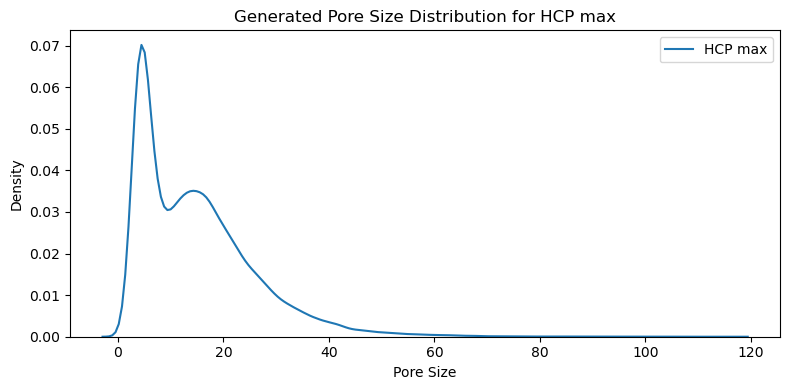


Simulation 1 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 40000


[13:32:00] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=198413;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=742396;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=77974;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=293241;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 2 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 40000


[13:37:00] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=2810;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=725956;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=681149;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=145434;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 3 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 40000


[13:42:15] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=484625;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=873590;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=354199;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=360887;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 4 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 40000


[13:47:55] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=323214;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=854076;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=545975;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=36418;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    


Simulation 5 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 40000


[13:54:18] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=285392;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=949039;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[13:54:19] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=291157;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=96805;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

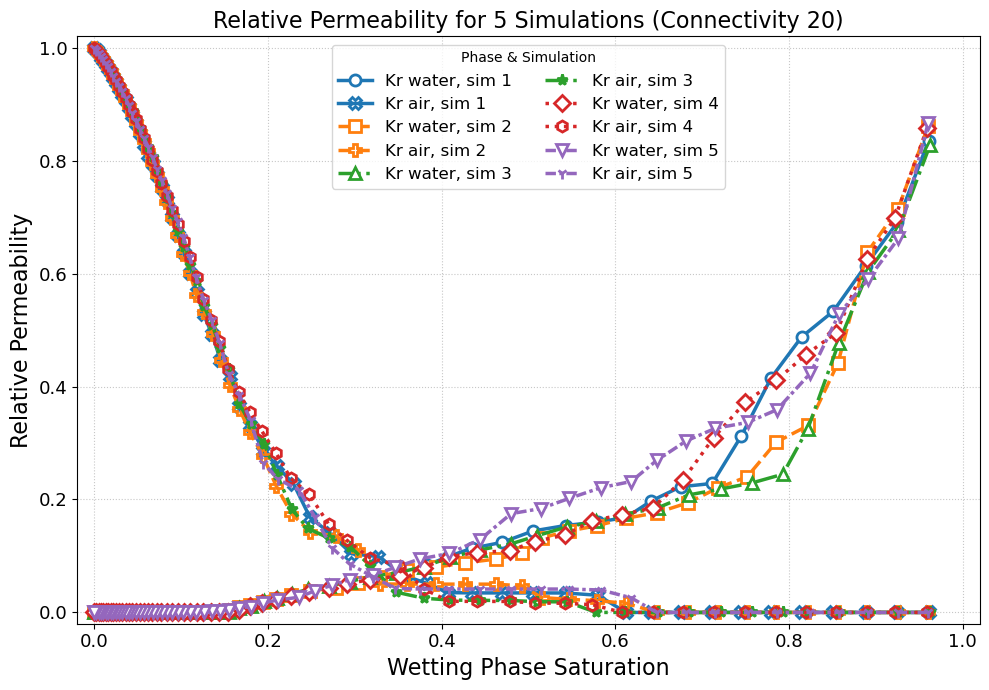

In [ ]:
# Run 5 simulations for connectivity 20 with shape [200, 200, 1]
shape = [200, 200, 1]
connectivity = 6
num_simulations = 5

connectivity_6_results = {}
experimental_data_dict = {
    "HCP max": "psd_from_these_mazen_HCP_max.csv"
}

# Generate synthetic pore sizes from the specified data file
hcp_pore_sizes = create_synthetic_pore_sizes_from_dict(experimental_data_dict)

synthetic_pore_sizes_dict['HCP max']
for sim_idx in range(num_simulations):
    print(f"\nSimulation {sim_idx + 1} for connectivity {connectivity}")
    pn = create_pore_network(hcp_pore_sizes["HCP max"], geometry_shape='cubic', sample_shape=shape, connectivity=connectivity)
    result = perform_relative_permeability_simulation(pn)
    connectivity_6_results[f"sim_{sim_idx + 1}"] = result

# Plotting results for the 5 simulations
plt.figure(figsize=(10, 7))
water_markers = ['o', 's', '^', 'D', 'v']
air_markers = ['X', 'P', '*', 'h', '1']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

handles = []
labels = []

for idx, (sim_name, result) in enumerate(connectivity_6_results.items()):
    Snwparr, relperm_nwp, relperm_wp = result
    saturation = 1 - np.array(Snwparr)
    color = colors[idx % len(colors)]
    h_wp, = plt.plot(
        saturation, relperm_wp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=water_markers[idx % len(water_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='white',
        markeredgewidth=2,
        label=f'Kr water, sim {idx + 1}'
    )
    h_nwp, = plt.plot(
        saturation, relperm_nwp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=air_markers[idx % len(air_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'Kr air, sim {idx + 1}'
    )
    handles.extend([h_wp, h_nwp])
    labels.extend([f'Kr water, sim {idx + 1}', f'Kr air, sim {idx + 1}'])

plt.xlabel('Wetting Phase Saturation', fontsize=16)
plt.ylabel('Relative Permeability', fontsize=16)
plt.title('Relative Permeability for 5 Simulations (Connectivity 6)', fontsize=16)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend(handles, labels, fontsize=12, loc='best', frameon=True, ncol=2, title="Phase & Simulation")
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

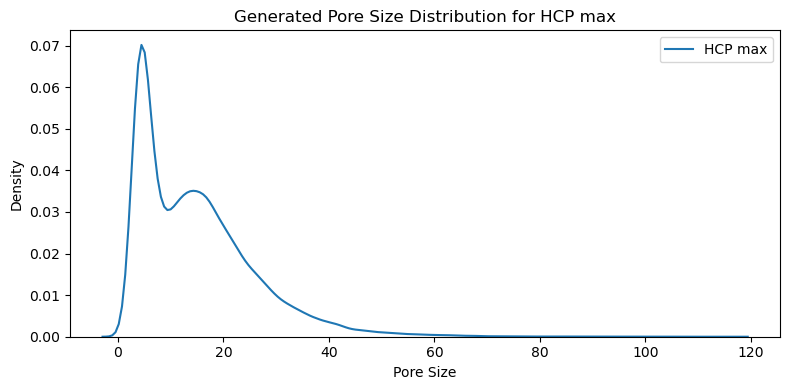


Simulation 1 for connectivity 6
Initial number of pores size 40000
Modified number of pores size 15625


[15:45:11] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=795058;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=827002;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=309033;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=910474;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

In [ ]:
# Run 5 simulations for connectivity 20 with shape [25, 25, 25]
shape = [25, 25, 25]
connectivity = 6
num_simulations = 5

connectivity_6_results = {}
experimental_data_dict = {
    "HCP max": "psd_from_these_mazen_HCP_max.csv"
}
# Generate synthetic pore sizes from the specified data file
hcp_pore_sizes = create_synthetic_pore_sizes_from_dict(experimental_data_dict)

synthetic_pore_sizes_dict['HCP max']
for sim_idx in range(num_simulations):
    print(f"\nSimulation {sim_idx + 1} for connectivity {connectivity}")
    pn = create_pore_network(hcp_pore_sizes["HCP max"], geometry_shape='cubic', sample_shape=shape, connectivity=connectivity)
    result = perform_relative_permeability_simulation(pn)
    connectivity_6_results[f"sim_{sim_idx + 1}"] = result

# Plotting results for the 5 simulations
plt.figure(figsize=(10, 7))
water_markers = ['o', 's', '^', 'D', 'v']
air_markers = ['X', 'P', '*', 'h', '1']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

handles = []
labels = []

for idx, (sim_name, result) in enumerate(connectivity_6_results.items()):
    Snwparr, relperm_nwp, relperm_wp = result
    saturation = 1 - np.array(Snwparr)
    color = colors[idx % len(colors)]
    h_wp, = plt.plot(
        saturation, relperm_wp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=water_markers[idx % len(water_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='white',
        markeredgewidth=2,
        label=f'Kr water, sim {idx + 1}'
    )
    h_nwp, = plt.plot(
        saturation, relperm_nwp,
        linestyle=line_styles[idx % len(line_styles)],
        color=color,
        marker=air_markers[idx % len(air_markers)],
        markersize=8,
        linewidth=2.5,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'Kr air, sim {idx + 1}'
    )
    handles.extend([h_wp, h_nwp])
    labels.extend([f'Kr water, sim {idx + 1}', f'Kr air, sim {idx + 1}'])

plt.xlabel('Wetting Phase Saturation', fontsize=16)
plt.ylabel('Relative Permeability', fontsize=16)
plt.title('Relative Permeability for 5 Simulations (Connectivity 6)', fontsize=16)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend(handles, labels, fontsize=12, loc='best', frameon=True, ncol=2, title="Phase & Simulation")
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

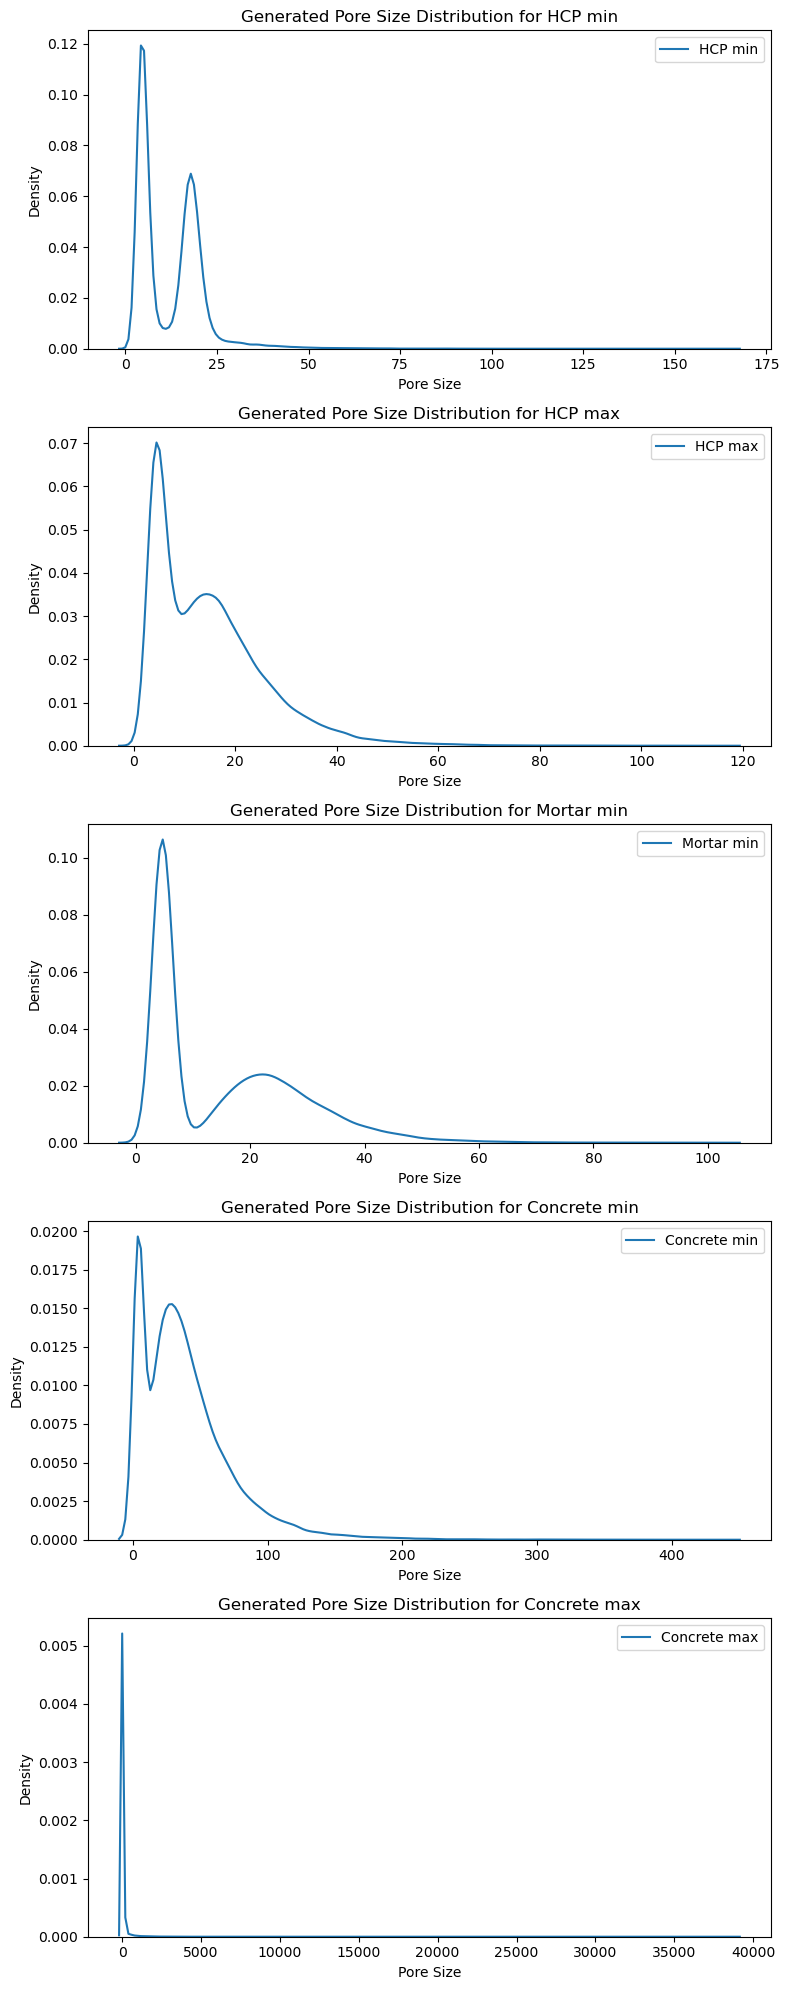

{'HCP min': array([ 7.37998934,  3.64861187,  5.88021028, ..., 19.55259232,
       21.04801247, 16.42255235]), 'HCP max': array([28.4071041 , 52.81849537, 43.96547945, ...,  3.09990893,
        2.47873385,  5.72725054]), 'Mortar min': array([35.43208317, 56.57081717, 49.25936437, ...,  3.60552073,
        3.10918281,  5.4142064 ]), 'Concrete min': array([ 73.17264658, 161.49000971, 127.77719348, ...,   3.31435219,
         2.99822801,   4.36417283]), 'Concrete max': array([63.71698516, 45.04696206, 45.73482132, ...,  3.52407905,
        3.52142327,  3.90376473])}
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
{'HCP min': net : <openpnm.network.Cubic at 0x23091a67160>, 'HCP max': net 

[23:24:27] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=640343;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=717504;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

[23:24:28] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=232858;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=954654;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=241955;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=529726;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=445042;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=30632;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=484769;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=283052;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[23:24:29] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=400238;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=675516;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

[23:24:30] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=705604;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=849522;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=367375;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=103479;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=520137;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=144336;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=142983;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=651721;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[23:24:31] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=473579;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=308353;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

[23:24:32] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=523922;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=837376;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=323245;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=813355;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=171579;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=739678;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=561549;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=788388;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[23:24:33] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=874898;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=263864;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

[23:24:34] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=822800;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=812973;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=860801;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=553072;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=678254;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=210289;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=405136;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=161406;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=722036;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=832303;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

[23:24:35] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=1372;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=981487;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=1588;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=806963;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=801524;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=664910;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=703;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=315119;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Results saved to These_mazen_results\These_mazen_network_properties
{'HCP min': {'effective_diffusivity': 1.2706467217634638e-06, 'porosity': 0.19025606138860104, 'tortuosity': 3.136420305486004, 'Intrinsic permeability': 1.1741075886868739e-11}, 'HCP max': {'effective_diffusivity': 1.2803141380765043e-06, 'porosity': 0.19151098934233768, 'tortuosity': 3.1332693748136737, 'Intrinsic permeability': 1.1872609151163813e-11}, 'Mortar min': {'effective_diffusivity': 1.2759865933469279e-06, 'porosity': 0.19095300579580146, 'tortuosity': 3.1347359387026863, 'Intrinsic permeability': 1.1851300582999725e-11}, 'Concrete min': {'effective_diffusivity': 1.262301687739829e-06, 'porosity': 0.19041343095666574, 'tortuosity': 3.159766503345053, 'Intrinsic permeability': 1.1636027293716494e-11}, 'Concrete max': {'effective_diffusivity': 1.2577111222833405e-06, 'porosity': 0.19001926778889724, 'tortuosity': 3.164734737210618, 'Intrinsic permeability': 1.1558469477016717e-11}}


In [3]:
import os
#Example usage
def compute_network_properties(pore_networks_dict, output_directory, output_filename, spacing=1E-5):
    properties_dict = {}
    for key, pn in pore_networks_dict.items():
        # Create air phase
        air = op.phase.Air(network=pn)
        phys = op.models.collections.physics.basic
        air.add_model_collection(phys)
        air.regenerate_models()

        # Fickian Diffusion
        fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
        inlet = pn.pores('left')
        outlet = pn.pores('right')
        C_in, C_out = [10, 5]
        fd.set_value_BC(pores=inlet, values=C_in)
        fd.set_value_BC(pores=outlet, values=C_out)
        fd.run()

        A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
        L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)

        # Compute effective diffusivity
        rate_inlet = fd.rate(pores=inlet)[0]
        D_eff = rate_inlet * L / (A * (C_in - C_out))

        # Compute porosity
        V_p = pn['pore.volume'].sum()
        V_t = pn['throat.volume'].sum()
        V_bulk = A * L
        e = (V_p + V_t) / V_bulk

        # Compute tortuosity
        D_AB = air['pore.diffusivity'][0]
        tau = e * D_AB / D_eff

        # Intrinsic permeability
        phase = op.phase.Phase(network=pn)
        phase['pore.viscosity'] = 0.001  # Viscosity of water at 20 C
        phase.add_model_collection(op.models.collections.physics.basic)
        phase.regenerate_models()

        flow = op.algorithms.StokesFlow(network=pn, phase=phase)
        flow.set_value_BC(pores=inlet, values=1)
        flow.set_value_BC(pores=outlet, values=0)
        flow.run()

        phase.update(flow.soln)  # Update phase properties
        Q = flow.rate(pores=inlet, mode='group')[0]
        mu = 1
        Delta_P = 1.
        K = Q * L * mu / (A * Delta_P)  # Since viscosity and pressure difference are assumed to be 1
        Keff = K

        properties_dict[key] = {
            "effective_diffusivity": D_eff,
            "porosity": e,
            "tortuosity": tau,
            "Intrinsic permeability": Keff
        }

    # Save results to a CSV file
    os.makedirs(output_directory, exist_ok=True)
    output_path = os.path.join(output_directory, output_filename)
    results_df = pd.DataFrame.from_dict(properties_dict, orient='index')
    results_df.to_csv(output_path, index_label="Network")
    print(f"Results saved to {output_path}")

    return properties_dict

if __name__ == "__main__":
    experimental_data_dict = {
        "HCP min":"psd_from_these_mazen_HCP_min.csv",
        "HCP max":"psd_from_these_mazen_HCP_max.csv",
        "Mortar min":"psd_from_these_mazen_mortar_min.csv",
        #"Mortar max": "psd_from_these_mazen_mortar_max.csv",
        "Concrete min": "psd_from_these_mazen_concrete_min.csv",
        "Concrete max":"psd_from_these_mazen_concrete_max.csv"
    }
    synthetic_pore_sizes_dict = create_synthetic_pore_sizes_from_dict(experimental_data_dict)
    print(synthetic_pore_sizes_dict)
    
    #Create pore networks from synthetic pore sizes
    pore_networks_dict = create_pore_networks_from_dict(synthetic_pore_sizes_dict,geometry_shape='cubic',sample_shape=[30, 30, 30])
    print(pore_networks_dict)
    
    # Perform simulations for each pore network
    #simulation_results = perform_simulations_for_networks(pore_networks_dict)
    # Compute properties for each network
    output_directory="These_mazen_results"
    output_filename ="These_mazen_network_properties"
    network_properties = compute_network_properties(pore_networks_dict, output_directory, output_filename, spacing=1E-5)
    print(network_properties)

This comprehensive Python code package offers a robust platform for the advanced numerical simulation of fluid transport in porous media, with a specific focus on two-phase relative permeability and a pathway for validating these simulations against experimental data.

The initial segment of the code is dedicated to **synthetic pore size distribution (PSD) generation and pore network construction**. Functions such as `load_data_from_csv` and `create_synthetic_pore_sizes` enable the extraction of experimental PSD data, which is then utilized to fit a Gaussian Mixture Model (`sklearn.mixture.GaussianMixture`). This GMM statistically represents the complex pore size distribution, allowing for the generation of large synthetic pore size datasets (`generate_data_from_gmm`, `create_synthetic_pore_sizes_from_dict`) that mimic the characteristics of real materials. These synthetic pore sizes serve as the foundation for building **pore network models** via `create_pore_network` and `create_pore_networks_from_dict`. This section supports various network geometries (e.g., 'cubic', 'voronoi', 'delaunay'), where pores and throats are assigned diameters derived from the synthetic PSDs. Geometric models from `OpenPNM` (e.g., for throat length, pore and throat volumes based on 'spheres and cylinders') are then applied, ensuring a physically consistent representation of the porous medium's topology and morphology.

The core of the transport simulation resides in the `perform_relative_permeability_simulation` function. Here, two fluid phases, 'air' (non-wetting) and 'water' (wetting), are explicitly defined with their respective thermophysical properties (e.g., surface tension, contact angle for air, and basic physics models for both). Crucially, throat diffusivity values are set, and `ordinary_diffusion` models are applied to define diffusive conductance, laying groundwork for mass transport analysis. The simulation of two-phase flow dynamics begins with an **Invasion Percolation (IP)** algorithm (`op.algorithms.InvasionPercolation`), which simulates the non-wetting phase invading the network from a specified inlet (e.g., the 'right' boundary). IP generates an invasion sequence, which dictates the fluid occupancy within pores and throats at various saturation levels. Leveraging this sequence, the simulation iteratively calculates relative permeabilities. For each discrete step of saturation, the `sat_occ_update` function dynamically assigns `pore.occupancy` and `throat.occupancy` states for both phases. The `op.models.physics.multiphase.conduit_conductance` model then dynamically re-evaluates the hydraulic conductance of each throat based on the current phase occupancy. Using `Rate_calc` (which internally employs `op.algorithms.StokesFlow`), effective flow rates for both phases are computed under these two-phase conditions and subsequently normalized by their respective absolute flow rates (i.e., flow when only one phase is present) to yield the relative permeability curves.

Beyond relative permeability, the `compute_intrinsic_permeability` function independently determines the absolute (single-phase) permeability of the network by simulating Stokes flow with a single fluid phase under a defined pressure gradient, which is essential for normalizing relative permeability values. Additionally, the presence of functions like `van_genuchten_krw`, `van_genuchten_krn`, and `objective` indicates the capability to fit simulated or experimental relative permeability data to widely accepted empirical models. Functions such as `viscosity_arrhenius`, `surface_tension_model`, `compute_diffusivity`, and `compute_viscosity` provide a framework for defining complex, temperature-dependent, or size-dependent fluid properties using physical equations like the Einstein-Stokes relation. Finally, `visualize_simulation_results` and `visualize_results` (the latter being more geared towards publication quality) provide robust plotting capabilities for analyzing and comparing simulated data, often side-by-side with experimental measurements, enabling critical model validation and insights into the relationship between porous media microstructure and macroscopic transport phenomena.

In [12]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

print("************************** Function for creating network from pore size distribution **********")

#Function to generate synthetic data from a GMM
def generate_data_from_gmm(gmm, num_samples=1000):
    samples, _ = gmm.sample(num_samples)
    return np.exp(samples.flatten())

# Function to load experimental data from a CSV file
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path,delimiter=';')
    data = {'x': df['x'].values.tolist(), 'y': df['y'].values.tolist()}
    return data

#Main function to create synthetic pore size list from CSV file
def create_synthetic_pore_sizes(csv_file_path, num_samples=40000):
    # Load experimental data from CSV file
    data = load_data_from_csv(csv_file_path)
    # Convert the pore size distribution to a probability density function
    x = np.array(data['x'])
    y = np.array(data['y'])
    pdf = y / np.sum(y)

    # Generate synthetic pore sizes based on the PDF
    np.random.seed(0)  # For reproducibility
    r = np.random.choice(x, size=1000, p=pdf)

    # Identify peaks in the experimental data
    peaks, _ = find_peaks(y, height=0)
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Fit a Gaussian Mixture Model to the data
    n_components = len(peaks)
    gmm = GaussianMixture(n_components=n_components, random_state=0, n_init=10, max_iter=5000)
    log_r = np.log(r).reshape(-1, 1)
    gmm.fit(log_r)

    # Generate synthetic data
    synthetic_data = generate_data_from_gmm(gmm, num_samples=num_samples)
    
    return synthetic_data

def create_synthetic_pore_sizes_from_dict(experimental_data_dict, num_samples=40000):
    synthetic_data_dict = {}
    num_files = len(experimental_data_dict)
    fig, axes = plt.subplots(num_files, 1, figsize=(8, 4 * num_files))
    
    if num_files == 1:
        axes = [axes]
    
    for i, (key, csv_file_path) in enumerate(experimental_data_dict.items()):
        synthetic_data = create_synthetic_pore_sizes(csv_file_path, num_samples)
        synthetic_data_dict[key] = synthetic_data
        
        # Plot the generated pore size distributions using seaborn kdeplot in separate subplots
        sns.kdeplot(synthetic_data, ax=axes[i], label=key,fill=False)
        axes[i].set_xlabel('Pore Size')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'Generated Pore Size Distribution for {key}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return synthetic_data_dict

# Function to create pore networks from a dictionary of synthetic pore sizes
def create_pore_networks_from_dict(synthetic_data_dict, geometry_shape='cubic', sample_shape=[200, 200, 1]):
    pore_networks_dict = {}
    for key, pore_sizes in synthetic_data_dict.items():
        pore_network = create_pore_network(pore_sizes, geometry_shape, sample_shape)
        pore_networks_dict[key] = pore_network
    return pore_networks_dict

# Function to create a pore network from pore sizes
def create_pore_network(pore_sizes, geometry_shape='cubic', sample_shape=[200, 200, 1],spacing=5.e-6):
    print("Initial number of pores size", len(pore_sizes))
    if len(pore_sizes) == 0:
        raise ValueError("Pore size data is empty. Cannot create pore network.")

    network_types = {
        'cubic': op.network.Cubic,
        'voronoi': op.network.Voronoi,
        'delaunay': op.network.Delaunay,
        'voronoidual': op.network.DelaunayVoronoiDual
    }

    if geometry_shape.lower() not in network_types:
        raise ValueError(f"Unsupported geometry shape: {geometry_shape}. Must be one of {list(network_types.keys())}.")

    NetworkClass = network_types[geometry_shape.lower()]

    if geometry_shape.lower() in ['voronoi', 'delaunay', 'voronoidual']:
        points = np.random.rand(len(pore_sizes), 3)  # Generate random points in 3D
        pn = NetworkClass(shape=sample_shape, points=points)
    else:
        pn = NetworkClass(shape=sample_shape, spacing=5.e-6)
        
    pn.add_model(propname='pore.seed', model=op.models.misc.random, element='pore', num_range=[0, 1])
    pn.add_model(propname='throat.seed', model=op.models.misc.random, element='throat', num_range=[0, 1])
    mods = op.models.collections.geometry.cubes_and_cuboids # Test spheres_and_cylinders
    pn.add_model_collection(mods)
    pn.regenerate_models()

    if pn.Np > len(pore_sizes):
        # If cubic sample has more pores, extend pore sizes by random choice
        pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=True)
    elif pn.Np < len(pore_sizes):
        # If cubic sample has fewer pores, resample pore sizes
        pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=False)
    print("Modified number of pores size", len(pore_sizes))
    pn['pore.diameter'] = np.array(pore_sizes) * 1e-9  # Convert nm to meters
    pn.regenerate_models()
    return pn

print("************************** Functions for pore scale simulations *********************")
# Function to perform relative permeability simulations for each pore network
def perform_simulations_for_networks(pore_networks_dict):
    results = {}
    for key, pn in pore_networks_dict.items():
        results[key] = perform_relative_permeability_simulation(pn)
    return results

# Function to perform relative permeability simulation on a pore network
def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

# Van Genuchten-Mualem model functions with optimization parameters
def van_genuchten_krw(Sw, nk, b):
    return Sw**nk * (1 - (1 - Sw**b)**(1/b))**2

def van_genuchten_krn(Sw, na, b):
    return (1 - Sw)**na * (1 - Sw**(1/b))**(2*b)

#Effective saturation range
Se = np.linspace(0, 1, 500)
# Define the optimization function for Kr_water and Kr_air
def objective(params, saturation, kr_water, kr_air):
    nk, na, b = params
    krw_fit = van_genuchten_krw(saturation, nk, b)
    krn_fit = van_genuchten_krn(saturation, na, b)
    error = np.sum((kr_water - krw_fit)**2 + (kr_air - krn_fit)**2)
    return error

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity *a)


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

def visualize_simulation_results(simulation_results):
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    colors = ['b', 'b', 'r', 'r', 'k', 'k', 'g']
    line_width = 2.5
    for idx, (key, result) in enumerate(simulation_results.items()):
        Snwparr, relperm_nwp, relperm_wp = result
        saturation = 1 - np.array(Snwparr)
        linestyle_nwp = line_styles[idx % len(line_styles)]
        linestyle_wp = line_styles[(idx) % len(line_styles)]
        color_nwp = colors[idx % len(colors)]
        color_wp = colors[idx % len(colors)]
        plt.plot(saturation, relperm_nwp, label=f'Kr air - {key}', linestyle=linestyle_nwp, color=color_nwp, linewidth=line_width)
        plt.plot(saturation, relperm_wp, label=f'Kr water - {key}', linestyle=linestyle_wp, color=color_wp, linewidth=line_width)
    plt.xlabel('Saturation')
    plt.ylabel('Relative Permeability')
    plt.title('Relative Permeability vs Saturation')
    plt.legend()
    plt.grid()
    plt.show()
    
def compute_intrinsic_permeability(pore_networks_dict):
    intrinsic_permeability_results = {}
    for key, pn in pore_networks_dict.items():
        # Set up water phase and Stokes flow algorithm
        phase = op.phase.Phase(network=pn)
        #phase=op.phase.Water(network=pn, name='water')
        phase['pore.viscosity'] = 0.001 # viscosite de l'eau à 20 C
        phase.add_model_collection(op.models.collections.physics.basic)
        phase.regenerate_models()
        
        inlet = pn.pores('left')
        outlet = pn.pores('right')
        
        flow = op.algorithms.StokesFlow(network=pn, phase=phase)
        flow.set_value_BC(pores=inlet, values=1)
        flow.set_value_BC(pores=outlet, values=0)
        flow.run()
        
        phase.update(flow.soln)  # Update phase properties
        Q = flow.rate(pores=inlet, mode='group')[0]
        A =  op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
        L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
        
        # Compute intrinsic permeability
        K = Q * L / A  # Since viscosity and pressure difference are assumed to be 1
        intrinsic_permeability_results[key] = K / 0.98e-12 * 1000  # Convert to mD
        print(f'The value of intrinsic permeability for {key} is: {intrinsic_permeability_results[key]:.5f} mD')
    
    return intrinsic_permeability_results

************************** Function for creating network from pore size distribution **********
************************** Functions for pore scale simulations *********************


# Perform relative permeability simulations

From pore size distributions collected from litterature, we generate corresponding pore networks, and then from the networks we generate 


The `perform_relative_permeability_simulation` function systematically models two-phase flow within a given pore network (`pn`) to compute the relative permeability of both wetting and non-wetting phases. Initially, it refines the network's geometric properties, adding models for throat length, pore volume, and various throat volume components (total, lens, and actual throat volume) to ensure accurate spatial representation and volume partitioning within the porous medium. Subsequently, it initializes two fluid phases, 'air' (non-wetting) and 'water' (wetting), assigning their fundamental thermophysical properties such as surface tension and contact angle for air, and default properties for water. Crucially, the code defines a constant throat diffusivity for both phases, and then applies a standard ordinary diffusion model to calculate diffusive conductance, setting the stage for potential future multiphase diffusion analysis.

The core of the simulation begins with an **Invasion Percolation (IP)** algorithm, which mimics the drainage process where the non-wetting phase (air) invades the porous medium, displacing the wetting phase (water). This simulation determines the sequence in which pores and throats are invaded, providing a critical dataset (`ip['pore.invasion_sequence']`, `ip['throat.invasion_sequence']`) for tracking fluid occupancy. Following the IP simulation, the code prepares for **multiphase hydraulic flow simulations**. It incorporates a `conduit_hydraulic_conductance` model for both air and water phases. This model is paramount as it dynamically adjusts the hydraulic conductivity of each throat based on the current saturation state (i.e., whether a throat is occupied by the respective fluid phase or blocked by the other). A loop then iterates through a series of discrete non-wetting phase saturation points, updating the fluid occupancy in the network based on the invasion sequence. For each saturation step, the function regenerates the phase models to reflect the new occupancy, and then calculates the effective flow rate for both the wetting and non-wetting phases through the network using a flow solver (presumably `StokesFlow` from the context of `Rate_calc`). By comparing these effective flow rates to the flow rates under fully saturated conditions (calculated as `Rate_abs_nwp` and `Rate_abs_wp`), the relative permeabilities for both the non-wetting (`relperm_nwp`) and wetting (`relperm_wp`) phases are determined. The function returns these saturation and relative permeability arrays, providing a comprehensive characterization of the two-phase flow behavior within the simulated porous structure.

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

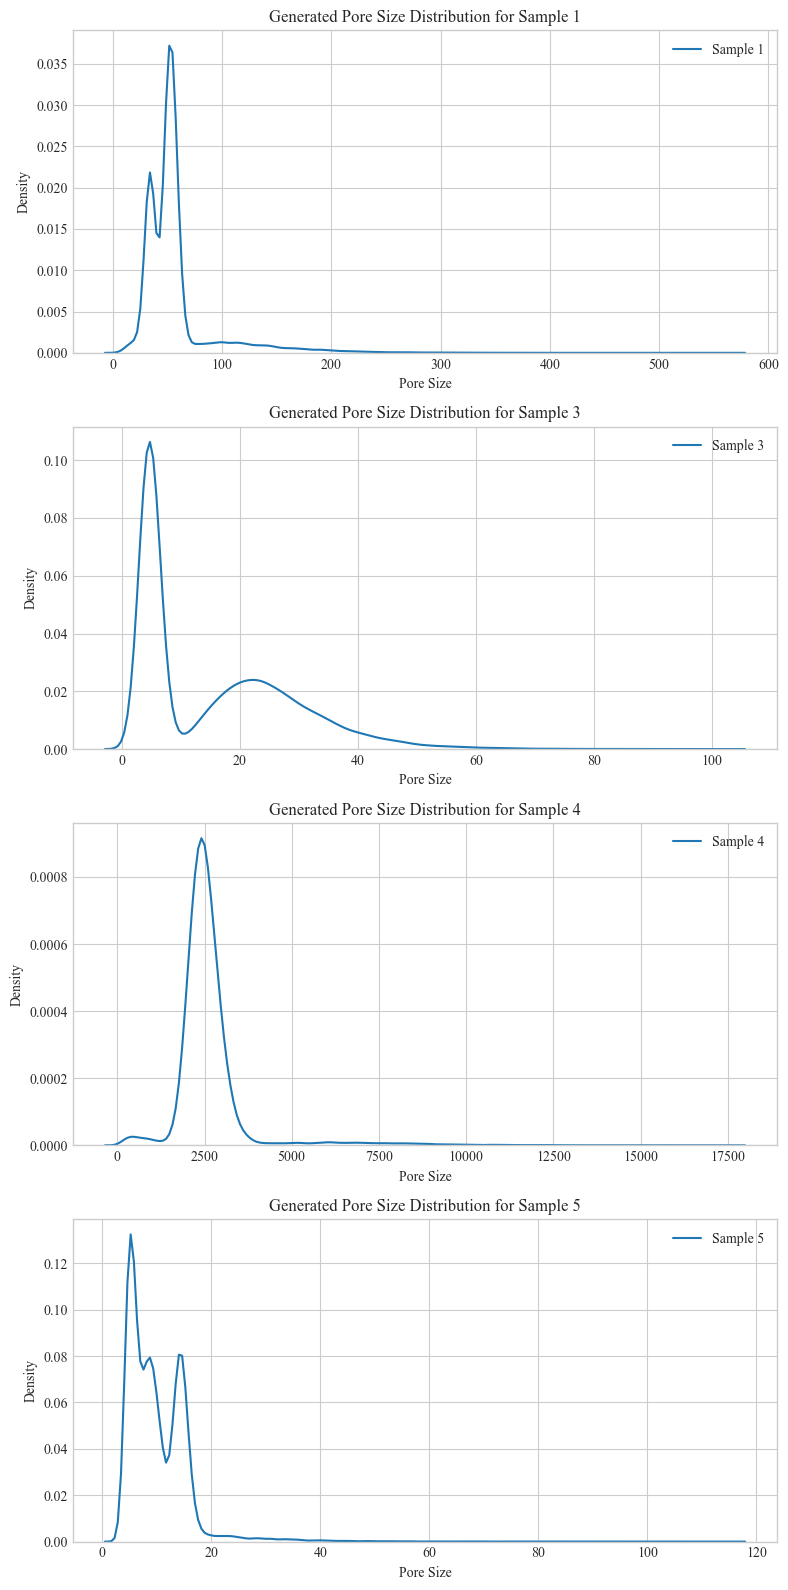

{'Sample 1': array([57.12714183, 52.12037806, 52.32973452, ..., 16.81685455,
       16.77924938, 22.78776094]), 'Sample 3': array([35.43208317, 56.57081717, 49.25936437, ...,  3.60552073,
        3.10918281,  5.4142064 ]), 'Sample 4': array([3328.1975896 , 2111.95702257, 2874.13331572, ..., 8252.01051815,
       9933.98069697, 5319.32485729]), 'Sample 5': array([15.5784128 , 14.27149111, 14.32624862, ...,  7.75149131,
        7.74413712,  8.81728993])}
Initial number of pores size 40000
Modified number of pores size 40000
Initial number of pores size 40000
Modified number of pores size 40000
Initial number of pores size 40000
Modified number of pores size 40000
Initial number of pores size 40000
Modified number of pores size 40000
{'Sample 1': net : <openpnm.network.Cubic at 0x1f0efe41ef0>, 'Sample 3': net : <openpnm.network.Cubic at 0x1f0efac9450>, 'Sample 4': net : <openpnm.network.Cubic at 0x1f0efacb930>, 'Sample 5': net : <openpnm.network.Cubic at 0x1f0efe94c80>}


[14:40:55] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=326384;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=122606;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=744986;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=170922;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[14:44:58] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=423220;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=234967;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=606878;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=740184;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[14:49:05] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=63529;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=263081;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=840994;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=372118;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[14:53:59] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=530347;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=215128;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=514165;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=421386;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

{'Sample 1': ([0.039280105897417386, 0.07518234616356234, 0.11168786386690319, 0.14905451573714498, 0.18552423190685896, 0.22064963310765287, 0.25492403489346194, 0.288362774399479, 0.3248693505733262, 0.35854909803199686, 0.38768787097914087, 0.42005260625143126, 0.4572816172947182, 0.4948741502085021, 0.530256310176592, 0.5656048645708357, 0.5930668066603639, 0.6172502249368756, 0.642292211056295, 0.6729833409256879, 0.7038789736999252, 0.7289708129475888, 0.7518111217787733, 0.7704493503417625, 0.7895136735389472, 0.8057190124749621, 0.8204944701919658, 0.832906934959752, 0.8434420128623188, 0.8548403217453849, 0.8644675540113612, 0.8742987243966105, 0.8821124675399469, 0.8895491043244471, 0.8971361685197685, 0.9038550096798906, 0.9103560437546782, 0.916524509547316, 0.9224880701027254, 0.9277653355868555, 0.9329371037116605, 0.9381343493165241, 0.9429940372586493, 0.9475533716043244, 0.9520667926612753, 0.9562879724971775, 0.9603381510726376, 0.9641419987362952, 0.9677836433619122,

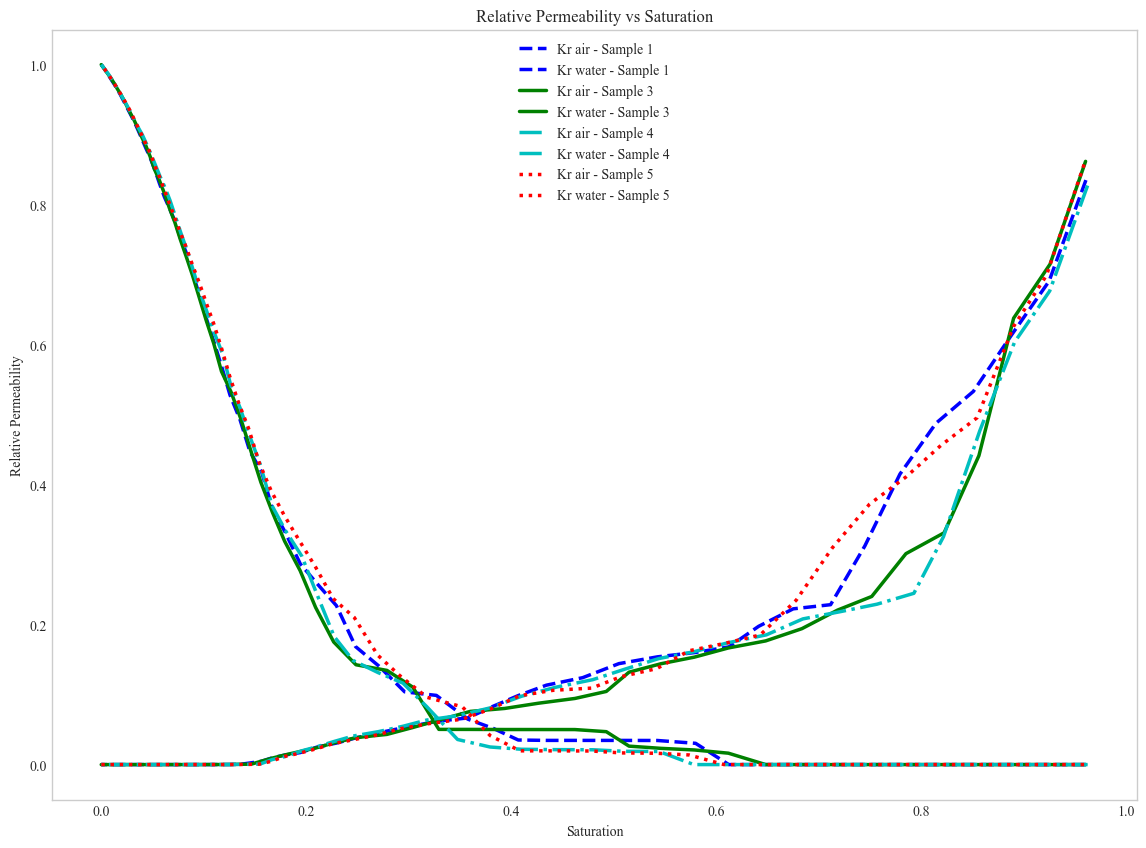

In [11]:
# Function to perform relative permeability simulation on a pore network
def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

# Example usage
if __name__ == "__main__":
    #File paths for experimental data
    
    experimental_data_dict  = {
        "Sample 1": "data/psd_MACENA_concrete_david_gregoire_2020.csv",
        #"Sample 2": "data/psd_CMI_chen_concrete_david_gregoire_2020.csv",
        "Sample 3": "psd_from_these_mazen_mortar_min.csv",
        "Sample 4": "data/psd_sandstone_david_gregoire_2020.csv",
        "Sample 5": "data/psd_oxford_argilite_david_gregoire_2020.csv",
    }
    #From experimental pore size dict, we create a synthetic pore size dict, and then create pore network dicts from  pore size dicts and then run the simulations for the networks present in the generated dictionary
    
    synthetic_pore_sizes_dict = create_synthetic_pore_sizes_from_dict(experimental_data_dict)
    print(synthetic_pore_sizes_dict)
    
    #Create pore networks from synthetic pore sizes
    pore_networks_dict = create_pore_networks_from_dict(synthetic_pore_sizes_dict,geometry_shape='cubic',sample_shape=[200, 200, 1])
    print(pore_networks_dict)
    
    # Perform simulations for each pore network
    simulation_results = perform_simulations_for_networks(pore_networks_dict)
    print(simulation_results)

    # Visualize simulation results
    visualize_simulation_results(simulation_results)

## Compare the simulated relative permeability with experimental ones 

The Python code you've provided defines a function `visualize_results` that is designed to plot and compare simulated relative permeability curves against experimental data. This is a common practice in porous media research to validate numerical models.

Here's a breakdown of what the code does:

**1. `visualize_results` Function:**

* **Initialization:**
    * It starts by creating a new Matplotlib figure with a specified size (`figsize=(14, 10)`) for better visual clarity.
    * It defines lists for `line_styles` (dashed, solid, dash-dot, dotted) and `colors` (blue, red, green, cyan, black) to differentiate between multiple simulation and experimental datasets on the plot.
    * `line_width` is set for the plot lines.

* **Plotting Simulation Results:**
    * It iterates through `simulation_results`, which is expected to be a dictionary where each `key` represents a simulation run (e.g., "Sample 1") and its `result` is a tuple containing three lists: `Snwparr` (non-wetting phase saturation), `relperm_nwp` (relative permeability of the non-wetting phase), and `relperm_wp` (relative permeability of the wetting phase).
    * For each simulation result:
        * `saturation` is calculated as `1 - np.array(Snwparr)`. This converts non-wetting phase saturation to wetting phase saturation, which is a common convention for plotting relative permeability curves.
        * `linestyle_nwp`, `linestyle_wp`, `color_nwp`, and `color_wp` are dynamically assigned using the `idx` (index of the current simulation) and the predefined `line_styles` and `colors` lists. This ensures different simulation runs have distinct visual styles.
        * `plt.plot()` is used twice for each simulation: once for the non-wetting phase relative permeability (`relperm_nwp`) and once for the wetting phase relative permeability (`relperm_wp`), both plotted against the calculated `saturation`. Labels are added to distinguish them in the legend.

* **Plotting Experimental Results:**
    * It then iterates through `experimental_results`, which is a dictionary mapping a `key` (e.g., "Concrete") to a `csv_file` path.
    * For each experimental dataset:
        * `pd.read_csv(csv_file, delimiter=";")` reads the experimental data from the specified CSV file. It assumes the CSV uses a semicolon as a delimiter.
        * `saturation` and `relperm` columns are extracted from the DataFrame.
        * `relperm = exp_data['RelPerm']/max(exp_data['RelPerm'])` normalizes the experimental relative permeability values by their maximum. This is done to bring experimental data into the 0-1 range, matching the typical definition of relative permeability (where it's relative to the absolute permeability).
        * `color_exp` is assigned using a separate counter `col_exp` to ensure distinct colors for experimental data.
        * `plt.scatter()` is used to plot the experimental data points as markers (circles), with labels for the legend.

* **Final Plot Customization:**
    * `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` set the axis labels and plot title for clarity.
    * `plt.legend()` displays the labels for all plotted curves and data points.
    * `plt.grid()` adds a grid to the plot for easier reading of values.
    * `plt.show()` displays the generated plot.

**2. Example Usage (outside the function):**

* **`experimental_results` Dictionary:** This dictionary defines the paths to various CSV files containing experimental relative permeability data for different materials like "Concrete", "HCP", "Mortar", "Sandstone", "Macena", and "Chen". These are the datasets against which the simulated results will be compared.
* **Function Call:** Finally, `visualize_results(simulation_results, experimental_results)` is called. Note that `simulation_results` is not defined in the provided snippet. In a full script, this would typically be a dictionary populated by the results of a prior simulation function (e.g., `compute_relative_permeabilities` from the context you previously shared).


Plotting simulation results...
Plotting experimental results...
Experimental data file not found: rel_perm_concrete_these_mazen.csv. Skipping 'Concrete'.
Experimental data file not found: data/rel_perm_krl_sandstone_david_gregoire_2020.csv. Skipping 'Sandstone'.
Plot saved to: scientific_relative_permeability_plot.png


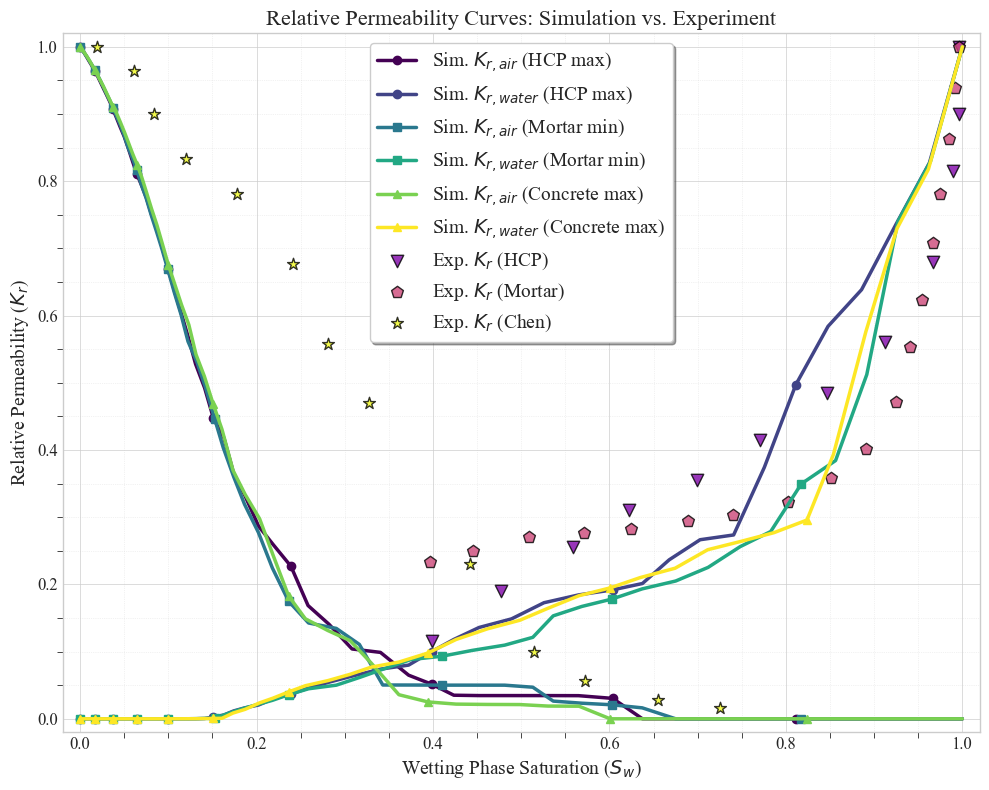

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os # Import os for path manipulation

def visualize_results_scientific(
    simulation_results,
    experimental_results=None, # Made optional
    fig_size=(10, 8),          # Standardized figure size
    font_size_labels=14,       # Font size for axis labels
    font_size_ticks=12,        # Font size for tick labels
    font_size_legend=14,       # Font size for legend entries
    show_plot=True,            # Option to show plot interactively
    save_path=None,            # Path to save the figure (e.g., 'output/my_plot.png')
    dpi=300                    # Dots per inch for saved image quality
):
    """
    Visualizes simulated relative permeability results and compares them with
    experimental data, optimized for scientific publications.

    Parameters
    ----------
    simulation_results : dict
        Dictionary where keys are simulation sample names (str) and values are
        tuples containing:
        - Snwparr (list or np.array): Non-wetting phase saturation values.
        - relperm_nwp (list or np.array): Relative permeability values for the
          non-wetting phase.
        - relperm_wp (list or np.array): Relative permeability values for the
          wetting phase.
    experimental_results : dict, optional
        Dictionary where keys are experimental sample names (str) and values
        are paths to experimental CSV files (str).
        Each CSV file is expected to contain columns:
        - 'saturation': Saturation values.
        - 'RelPerm': Relative permeability values (assumed to be already normalized
          or will be normalized by its max value for plotting consistency).
    fig_size : tuple, optional
        Dimensions of the figure (width, height) in inches.
    font_size_labels : int, optional
        Font size for X and Y axis labels.
    font_size_ticks : int, optional
        Font size for axis tick labels.
    font_size_legend : int, optional
        Font size for legend entries.
    show_plot : bool, optional
        If True, the plot will be displayed interactively.
    save_path : str, optional
        If provided, the plot will be saved to this file path.
        Include file extension (e.g., '.png', '.pdf', '.svg').
    dpi : int, optional
        Resolution for saved raster images (PNG). Ignored for vector formats (PDF, SVG).

    Returns
    -------
    None
        Displays or saves the plot.
    """
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean, modern grid style
    plt.rcParams['font.family'] = 'serif' # Use serif fonts for a classic scientific look
    plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'serif'] # Specify serif font
    
    fig, ax = plt.subplots(figsize=fig_size)

    # Define a rich set of distinguishable colors and markers for multiple datasets
    # These are often manually curated for publications
    sim_colors = plt.cm.viridis(np.linspace(0, 1, len(simulation_results) * 2))
    exp_colors = plt.cm.plasma(np.linspace(0, 1, len(experimental_results) if experimental_results else 1))
    
    markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '*', 'X', 'P', '>', '<']
    line_styles = ['-', '--', '-.', ':'] # Solid for simulation, dashed for other types if needed

    # --- Plot simulation results ---
    print("Plotting simulation results...")
    for idx, (key, result) in enumerate(simulation_results.items()):
        try:
            Snwparr, relperm_nwp, relperm_wp = result
            # Convert non-wetting saturation to wetting saturation
            saturation_sw = 1 - np.array(Snwparr)

            # Ensure data is sorted by saturation for proper plotting
            sort_indices = np.argsort(saturation_sw)
            saturation_sw_sorted = saturation_sw[sort_indices]/max(saturation_sw[sort_indices])
            relperm_nwp_sorted = np.array(relperm_nwp)[sort_indices]
            relperm_wp_sorted = np.array(relperm_wp)[sort_indices]/max(np.array(relperm_wp)[sort_indices])

            # Use distinct line styles for wetting and non-wetting phase from simulation
            # Use separate colors to make each simulation unique
            current_color_nwp = sim_colors[2 * idx]
            current_color_wp = sim_colors[2 * idx + 1] # Slightly different shade for wp vs nwp from same sim

            ax.plot(saturation_sw_sorted, relperm_nwp_sorted,
                    label=f'Sim. $K_{{r,air}}$ ({key})',
                    linestyle=line_styles[0], # Solid line for simulation data
                    color=current_color_nwp,
                    linewidth=2.5,
                    marker=markers[idx % len(markers)], # Use markers for simulation points
                    markersize=6,
                    markevery=max(1, len(saturation_sw_sorted) // 10) # Mark a few points for clarity
                    )
            ax.plot(saturation_sw_sorted, relperm_wp_sorted,
                    label=f'Sim. $K_{{r,water}}$ ({key})',
                    linestyle=line_styles[0], # Solid line for simulation data
                    color=current_color_wp,
                    linewidth=2.5,
                    marker=markers[idx % len(markers)], # Same marker as nwp for same sim
                    markersize=6,
                    markevery=max(1, len(saturation_sw_sorted) // 10)
                    )
        except (ValueError, TypeError, IndexError) as e:
            print(f"Skipping simulation result for '{key}' due to data format error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while plotting simulation for '{key}': {e}")


    # --- Plot experimental results ---
    if experimental_results:
        print("Plotting experimental results...")
        exp_idx_offset = len(simulation_results) # Offset index for markers if needed
        for idx, (key, csv_file) in enumerate(experimental_results.items()):
            try:
                # Use pandas to read data from CSV
                exp_data = pd.read_csv(csv_file, delimiter=";")
                
                # Check for required columns
                if 'saturation' not in exp_data.columns or 'RelPerm' not in exp_data.columns:
                    raise ValueError(f"CSV '{csv_file}' must contain 'saturation' and 'RelPerm' columns.")
                saturation_exp = exp_data['saturation'].values
                relperm_exp = exp_data['RelPerm'].values/max(exp_data['RelPerm'].values)

                # Normalize experimental relative permeability if max is not 1 (e.g., if it's effective perm)
                # It's crucial to understand if your 'RelPerm' in CSV is already relative (0-1) or absolute.
                # If it's absolute, you should normalize by its maximum or by the absolute permeability
                # from a known source for that experimental sample.
                # For demonstration, we normalize by max if it's not already 0-1 range.
                if np.max(relperm_exp) > 1.01 or np.max(relperm_exp) <= 0: # Check for non-unity max or zero
                    print(f"Warning: Normalizing experimental RelPerm for '{key}' (max was {np.max(relperm_exp):.2f}). Ensure this is intended.")
                    relperm_exp = relperm_exp / np.max(relperm_exp)
                
                current_exp_color = exp_colors[idx % len(exp_colors)] # Use a separate color scheme for exp
                current_exp_marker = markers[(idx + exp_idx_offset) % len(markers)] # Different marker for experimental data

                ax.scatter(saturation_exp, relperm_exp,
                           label=f'Exp. $K_r$ ({key})',
                           color=current_exp_color,
                           marker=current_exp_marker,
                           s=80, # Larger marker size for scatter points
                           edgecolors='k', # Black edge for better visibility
                           alpha=0.8
                           )
            except FileNotFoundError:
                print(f"Experimental data file not found: {csv_file}. Skipping '{key}'.")
            except ValueError as ve:
                print(f"Data error for '{key}' in '{csv_file}': {ve}. Skipping.")
            except Exception as e:
                print(f"An unexpected error occurred while plotting experimental data for '{key}': {e}")

    # --- Customize plot elements for publication quality ---
    ax.set_xlabel('Wetting Phase Saturation ($S_w$)', fontsize=font_size_labels)
    ax.set_ylabel('Relative Permeability ($K_r$)', fontsize=font_size_labels)
    ax.set_title('Relative Permeability Curves: Simulation vs. Experiment', fontsize=font_size_labels + 2)

    # Set consistent axis limits
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])

    ax.tick_params(axis='both', which='major', labelsize=font_size_ticks)
    ax.tick_params(axis='both', which='minor', length=4) # Minor ticks for precision
    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth=0.7, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

    # Place legend outside the plot area or strategically inside to avoid overlap
    ax.legend(fontsize=font_size_legend, loc='best', frameon=True, fancybox=True, shadow=True)

    plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

    # --- Save plot ---
    if save_path:
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    # --- Show plot ---
    if show_plot:
        plt.show()
    plt.close(fig) # Close the figure to free up memory

# Example usage (assuming simulation_results would be generated elsewhere)
if __name__ == "__main__":
    experimental_data_paths = {
        "Concrete": "rel_perm_concrete_these_mazen.csv",
        "HCP": "rel_perm_HCP_these_mazen.csv", # Commented out as dummy not created
        "Mortar": "rel_perm_mortar_these_mazen.csv", # Commented out as dummy not created
        "Sandstone": "data/rel_perm_krl_sandstone_david_gregoire_2020.csv",
        #"Macena": "data/rel_perm_krg_MACENA_concrete_david_gregoire_2020.csv", # Commented out as dummy not created
        "Chen": "data/rel_perm_krg_chen_concrete_david_gregoire_2020.csv" # Commented out as dummy not created
    }
    # Call the scientific visualization function
    visualize_results_scientific(
        simulation_results=simulation_results,
        experimental_results=experimental_data_paths,
        save_path="scientific_relative_permeability_plot.png", # Save to a file
        show_plot=True # Also show interactive plot
    )
    

# Perform intrinsic permeability , effective diffusivity and tortuosity simulations

The following Python code snippet focuses on a crucial aspect of porous media characterization: quantifying transport properties from a generated pore network model. The `compute_network_properties` function serves as the central engine for this task, taking a dictionary of `OpenPNM` pore networks as input and calculating key macroscopic parameters for each.

The function first initializes an `Air` phase within each given pore network, along with basic physics models relevant to fluid flow and diffusion. It then proceeds to simulate **Fickian Diffusion** to determine the effective diffusivity ($D_{eff}$). This is achieved by setting fixed concentration boundary conditions (e.g., $C_{in} = 10$, $C_{out} = 5$) across opposite faces of the network (labeled 'left' and 'right'). The resulting mass transfer rate is then used in conjunction with the network's domain area ($A$) and length ($L$) to calculate $D_{eff}$ via Fick's first law. Subsequently, the **porosity** ($\epsilon$) of the network is computed by summing the volumes of all pores and throats and dividing by the bulk volume of the simulated domain. The **tortuosity** ($\tau$) is then derived from $D_{eff}$ and $\epsilon$ using the classical relationship $\tau = \epsilon D_{AB} / D_{eff}$, where $D_{AB}$ is the bulk diffusivity of the diffusing species in the fluid phase (here, obtained from the `air['pore.diffusivity']` property).

Following the diffusion analysis, the code simulates **Stokes Flow** to determine the intrinsic permeability ($K$). A `Water` phase is initialized, and a pressure gradient is applied across the same inlet and outlet boundaries. The volumetric flow rate ($Q$) through the network is then calculated. Using Darcy's Law, the intrinsic permeability is computed from $Q$, $L$, the fluid's mean viscosity ($\mu$, explicitly retrieved from the `water` phase), and the applied pressure difference ($\Delta P$, assumed to be 1). The final results for $D_{eff}$, $\epsilon$, $\tau$, and $K$ for each pore network are stored in a dictionary.

In the `if __name__ == "__main__":` block, this `compute_network_properties` function is demonstrated within a larger workflow. It starts by defining paths to several experimental pore size distribution (PSD) data files for different materials (e.g., concrete, sandstone). These experimental PSDs are then used to `create_synthetic_pore_sizes_from_dict`, which likely generates synthetic pore size data conforming to the input distributions. Subsequently, `create_pore_networks_from_dict` constructs 3D cubic pore network models from these synthetic pore size data. Finally, the `compute_network_properties` function is called with these generated pore networks to extract their transport characteristics, thus providing a computational means to link microstructural features (represented by the PSDs) to macroscopic transport behavior.

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

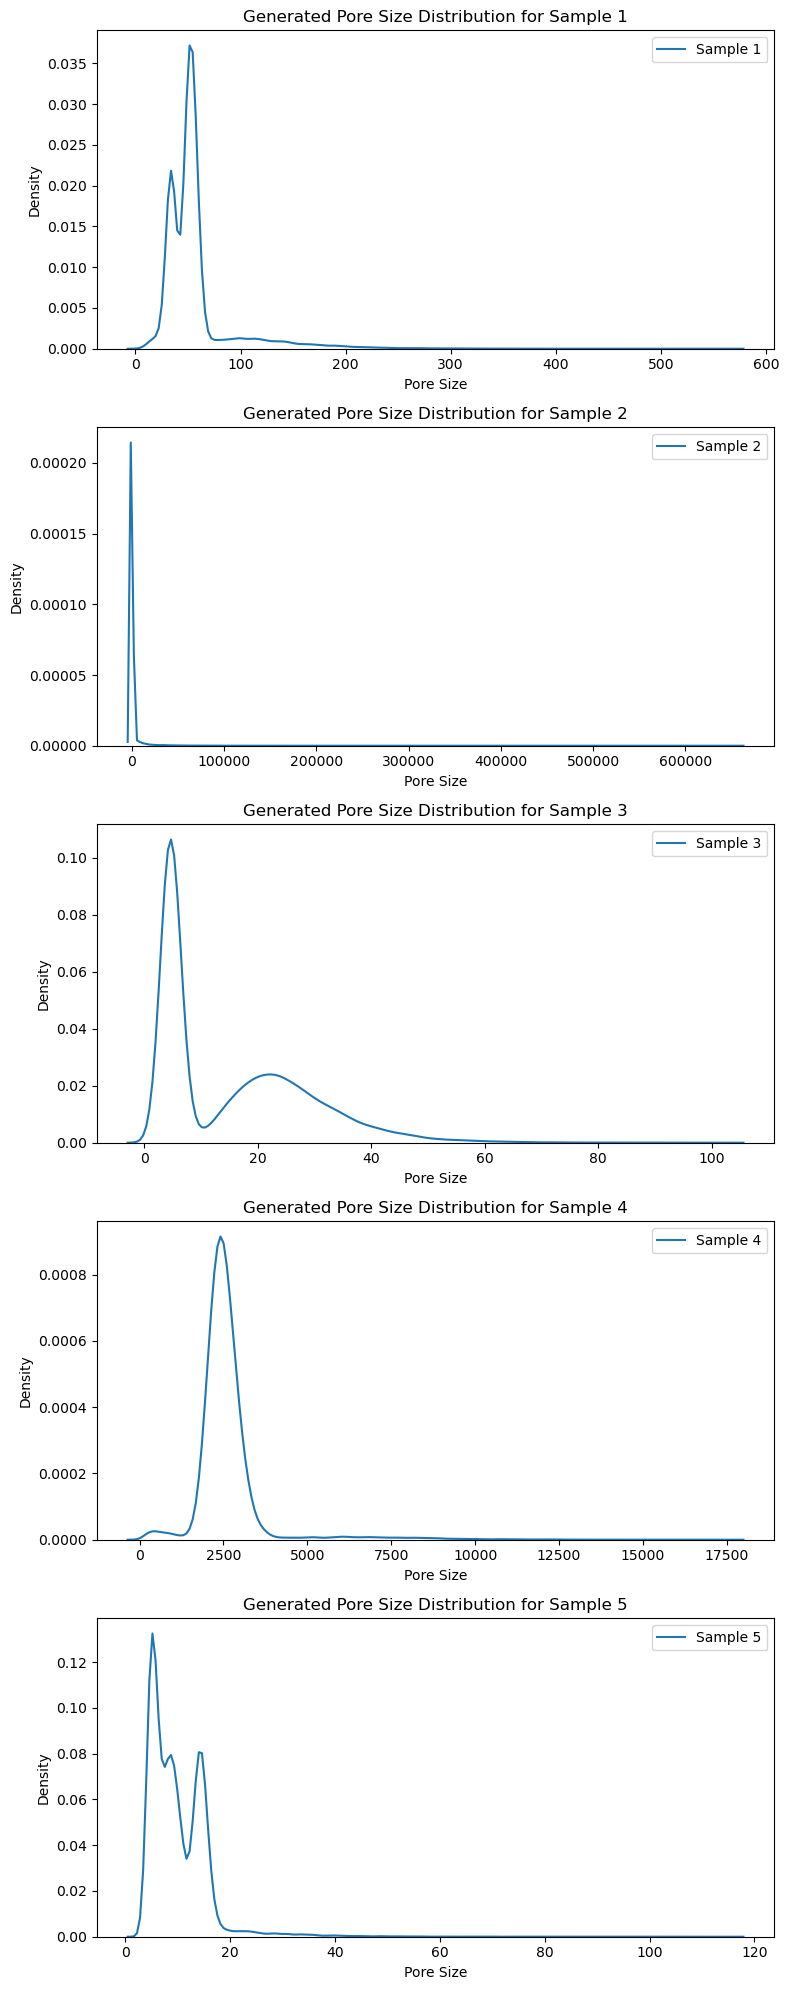

{'Sample 1': array([57.12714183, 52.12037806, 52.32973452, ..., 16.81685455,
       16.77924938, 22.78776094]), 'Sample 2': array([382.70918182,  14.60793004, 133.49608487, ...,  41.49861848,
        51.07627977,  25.38363419]), 'Sample 3': array([35.43208317, 56.57081717, 49.25936437, ...,  3.60552073,
        3.10918281,  5.4142064 ]), 'Sample 4': array([3328.1975896 , 2111.95702257, 2874.13331572, ..., 8252.01051815,
       9933.98069697, 5319.32485729]), 'Sample 5': array([15.5784128 , 14.27149111, 14.32624862, ...,  7.75149131,
        7.74413712,  8.81728993])}
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
Initial number of pores size 40000
Modified number of pores size 27000
{'Sample 1': net : <openpnm.network.Cubic at 0x1adad24bf70>, 'Sample 2'

[14:07:03] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=420303;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=783878;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  Attempting to estimate inlet area...will be low                              ]8;id=146417;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=134149;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=978492;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=529129;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

KeyError: 'throat.hydraulic_conductance'

In [4]:
#Example usage
def compute_network_properties(pore_networks_dict, spacing=1E-5):
    properties_dict = {}
    for key, pn in pore_networks_dict.items():
        # Create air phase
        air = op.phase.Air(network=pn)
        phys = op.models.collections.physics.basic
        #del phys['throat.entry_pressure']
        air.add_model_collection(phys)
        air.regenerate_models()

        # Fickian Diffusion
        fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
        inlet = pn.pores('left')
        outlet = pn.pores('right')
        C_in, C_out = [10, 5]
        fd.set_value_BC(pores=inlet, values=C_in)
        fd.set_value_BC(pores=outlet, values=C_out)
        fd.run()
        
        A =  op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
        L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)

        # Compute effective diffusivity
        rate_inlet = fd.rate(pores=inlet)[0]
        
        D_eff = rate_inlet * L / (A * (C_in - C_out))

        
        #Compute porosity
        V_p = pn['pore.volume'].sum()
        V_t = pn['throat.volume'].sum()
        V_bulk =A*L #np.prod(sample_shape)*(spacing**3) # *(spacing ** 3)
        e = (V_p + V_t) / V_bulk

        #Compute tortuosity
        D_AB = air['pore.diffusivity'][0]
        tau = e * D_AB / D_eff
        
        ##Intrinsic permeability
        #Set up water phase and Stokes flow algorithm
        water = op.phase.Water(network=pn)
        #phase=op.phase.Water(network=pn, name='water')
    
        flow = op.algorithms.StokesFlow(network=pn, phase=water)
        flow.set_value_BC(pores=inlet, values=1)
        flow.set_value_BC(pores=outlet, values=0)
        flow.run()
    
        water.update(flow.soln) # Update phase properties
        Q = flow.rate(pores=inlet, mode='group')[0]
        mu=water['pore.viscosity'].mean()
        Delta_P =1.
        K = Q * L*mu / (A * Delta_P) # Since viscosity and pressure difference are assumed to be 1
        Keff = K #/ 0.98e-12 * 1000  # Convert to mD
        
        properties_dict[key] = {
            "effective_diffusivity": D_eff,
            "porosity": e,
            "tortuosity": tau,
            "Intrinsic permeability": Keff
        }
    return properties_dict

if __name__ == "__main__":
    
    experimental_data_dict  = {
        "Sample 1": "data/psd_MACENA_concrete_david_gregoire_2020.csv",
        "Sample 2": "data/psd_CMI_chen_concrete_david_gregoire_2020.csv",
        "Sample 3": "psd_from_these_mazen_mortar_min.csv",
        "Sample 4": "data/psd_sandstone_david_gregoire_2020.csv",
        "Sample 5": "data/psd_oxford_argilite_david_gregoire_2020.csv",
    }

    synthetic_pore_sizes_dict = create_synthetic_pore_sizes_from_dict(experimental_data_dict)
    print(synthetic_pore_sizes_dict)
    
    #Create pore networks from synthetic pore sizes
    pore_networks_dict = create_pore_networks_from_dict(synthetic_pore_sizes_dict,geometry_shape='cubic',sample_shape=[30, 30, 30])
    print(pore_networks_dict)
    
    # Perform simulations for each pore network
    #simulation_results = perform_simulations_for_networks(pore_networks_dict)
    # Compute properties for each network
    network_properties = compute_network_properties(pore_networks_dict)
    print(network_properties)

# Parametric study on nanopores size distribution 

We generate artificial images using different statisical distributions and then compute the relative permeability. The advantage of this method is that 

### To DO, Test different minimum radius size rmin : 0.5, 1, 2, 5, 10 and porosity 0.3,0.4,0.5 and different Shapes: 20, 50, 80   within  distributions_dict, shape=[200, 100, 100], porosity=0.5, r_min=2, save_directory=None, save_name="Pore_Distributions_and_Images.png")

### To DO, Test different voxel size values 1e-5, 5e-6, 1e-6, 1e-7, 1e-8,: snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)

### To DO, Test different contact angles : 
 # Create phases
air = op.phase.Air(network=pn, name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 140.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()

### To DO , Test different difusivity values 
 # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

This Python code is designed for a comprehensive scientific investigation into the relationship between the microstructure of porous materials and their macroscopic transport properties, specifically focusing on permeability and diffusivity. It achieves this by combining advanced functionalities from PoreSpy for generating and analyzing 3D porous media images, and OpenPNM for constructing pore network models and simulating fluid flow and diffusion within these networks.

The core workflow begins by generating synthetic porous media images with controlled pore size distributions (PSDs). The generate_and_plot_pore_size_distributions function visualizes various statistical distributions (e.g., Normal, Lognormal, Weibull) that are commonly used to describe pore sizes in real materials. A crucial step, implemented in create_custom_distribution_from_scipy, transforms these standard statistical distributions into a custom continuous probability density function. This custom distribution then directly informs porespy.generators.polydisperse_spheres within generate_and_plot_im_from_scipy_distributions, which creates 3D binary images composed of spheres whose radii are sampled from the specified PSD. This approach allows researchers to systematically study the impact of different pore size characteristics on transport.

Once the synthetic images are created, the code proceeds to extract a representative pore network model from each image using PoreSpy's advanced SNOW (Skeleton Network On Watersheds) algorithm (create_pore_network_from_image). This algorithm simplifies the complex 3D geometry of the porous medium into a graph-like structure of interconnected pores (nodes) and throats (edges), which is a prerequisite for OpenPNM simulations. The extracted network is then enriched with geometric properties (e.g., pore volumes, throat lengths) using OpenPNM's spheres_and_cylinders models. An optional, but currently commented out, section (compute_diffusive_size_factor_from_extracted_regions) illustrates a potential integration of machine learning by using a pre-trained AI model to predict diffusive size factors from the image's segmented regions, showcasing a hybrid simulation approach.

The extracted pore network models are subsequently used for multiphase transport simulations to determine relative permeability. The perform_relative_permeability_simulation function defines two fluid phases, 'air' (non-wetting) and 'water' (wetting), assigns their thermophysical properties, and sets up the physics governing their flow. An InvasionPercolation algorithm simulates the displacement of water by air, providing the saturation state of each pore and throat. Subsequently, StokesFlow simulations are performed iteratively at various saturation levels for both phases, utilizing OpenPNM's conduit_hydraulic_conductance model, which adjusts flow based on the actual fluid occupancy in each conduit. This allows for the calculation of the effective permeability of each phase, which is then normalized by the absolute permeability (computed for single-phase flow) to yield the relative permeability curves. Finally, the compute_network_properties function further characterizes each network by calculating intrinsic permeability (single-phase flow), effective diffusivity (using FickianDiffusion), overall porosity, and tortuosity. The entire process is automated across multiple generated networks by create_pore_network_models_from_images and compute_relative_permeabilities, and the results are visually presented (visualize_results) and saved to CSV files (save_results_to_csv) for further analysis and comparison with experimental data. This comprehensive framework provides a robust tool for investigating the fundamental physics of fluid transport in porous media.

Generating image and plotting distribution for Normal Distribution (mean=3, std_dev=1)...
Generating image and plotting distribution for Lognormal Distribution (s=0.5, loc=0, scale=2)...
Generating image and plotting distribution for Exponential Distribution (loc=0, scale=2)...
Generating image and plotting distribution for Weibull Distribution (c=1.5, loc=0, scale=2)...
Generating image and plotting distribution for Gamma Distribution (a=2, loc=0, scale=2)...
Generating image and plotting distribution for Beta Distribution (a=2, b=5, loc=0, scale=10)...
Plot saved to results/scipy_models_psd_impact_on_krl\Pore_Distributions_and_Images.png


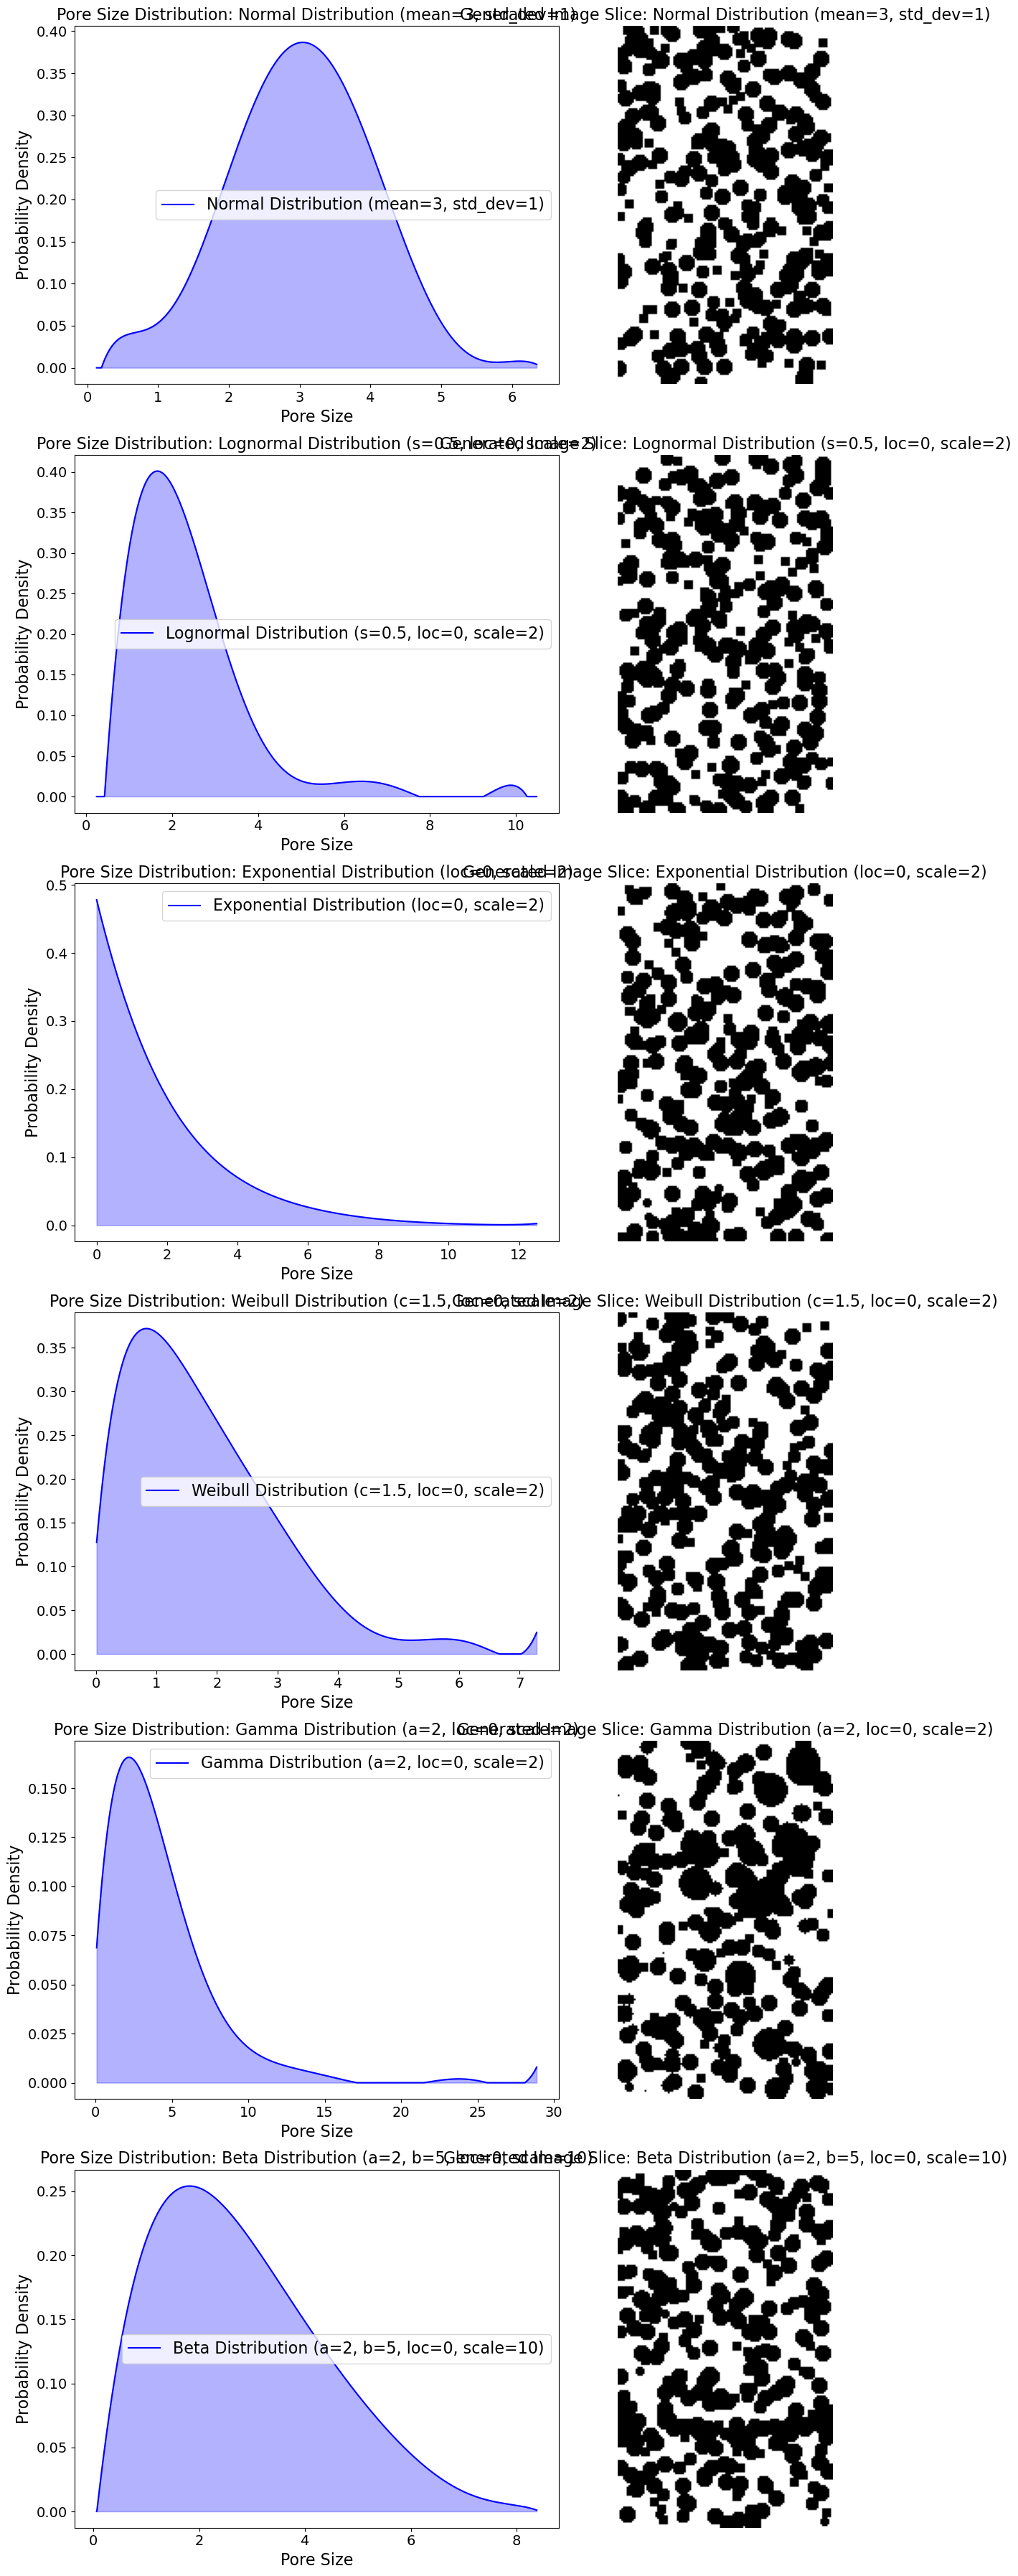

Processing sample: dist 1


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1800 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  [3, 1203, 1270, 1271]
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectio

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1853 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats        

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1815 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats        

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1888 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats        

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1624 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats        

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1747 [00:00<?, ?it/s]

*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats        

[10:41:04] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=840410;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=487969;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=626044;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=493582;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

Processing sample: dist 2


[10:41:48] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=697446;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=18734;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=422147;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=131160;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

Processing sample: dist 3


[10:42:51] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=466231;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=351398;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=566604;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=759151;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

Processing sample: dist 4


[10:43:52] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=575485;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=258339;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=562470;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=807399;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

Processing sample: dist 5


[10:44:59] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=215144;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=735712;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=910775;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=986174;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

Processing sample: dist 6


[10:45:59] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=209249;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=38308;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=297497;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=952750;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[10:47:20] WARNING  air is already taken, using air_01 instead                                      ]8;id=739362;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=353651;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=897938;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=682868;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

[10:47:21] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=533583;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=448628;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=558954;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=885220;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=843495;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=646869;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=787737;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=389529;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=955090;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=109736;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=609751;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=847960;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  air is already taken, using air_01 instead                                      ]8;id=671629;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=111701;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=945033;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=273499;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

[10:47:22] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=420933;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=888698;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=311128;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=527119;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=492651;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=810009;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=252340;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=492699;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=245422;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=954046;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=701648;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=492723;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  air is already taken, using air_01 instead                                      ]8;id=14708;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=629716;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=188650;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=751093;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

[10:47:23] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=875112;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=809485;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=481584;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=497481;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=792994;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=402909;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=212271;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=734009;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=454442;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=501832;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=241412;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=774343;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  air is already taken, using air_01 instead                                      ]8;id=236141;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=801031;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=108892;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=972728;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  Attempting to estimate inlet area...will be low                              ]8;id=614616;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=387912;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=126086;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=348966;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

[10:47:24] WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=847727;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=307760;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=974354;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=706925;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

           WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=634325;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=691415;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=99834;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=806666;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  air is already taken, using air_01 instead                                      ]8;id=823173;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=495853;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=726202;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=662397;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  Attempting to estimate inlet area...will be low                              ]8;id=911930;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=219550;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=708044;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=189771;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=651142;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=64897;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=799110;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=37374;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

[10:47:25] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=868169;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=155836;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=142234;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=272233;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  air is already taken, using air_01 instead                                      ]8;id=623280;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=5495;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_01 instead                                  ]8;id=13994;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=507703;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  Attempting to estimate inlet area...will be low                              ]8;id=923376;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=24276;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1046\1046]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=702156;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=530083;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1064\1064]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=524620;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=551113;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1090\1090]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=137684;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=78377;file://c:\Anaconda\Lib\site-packages\openpnm\topotools\_topotools.py#1100\1100]8;;\

[10:47:26] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=204168;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=514243;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=645259;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=477465;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Plot saved to results/scipy_models_psd_impact_on_krl\Relative_Permeability_Plot.png


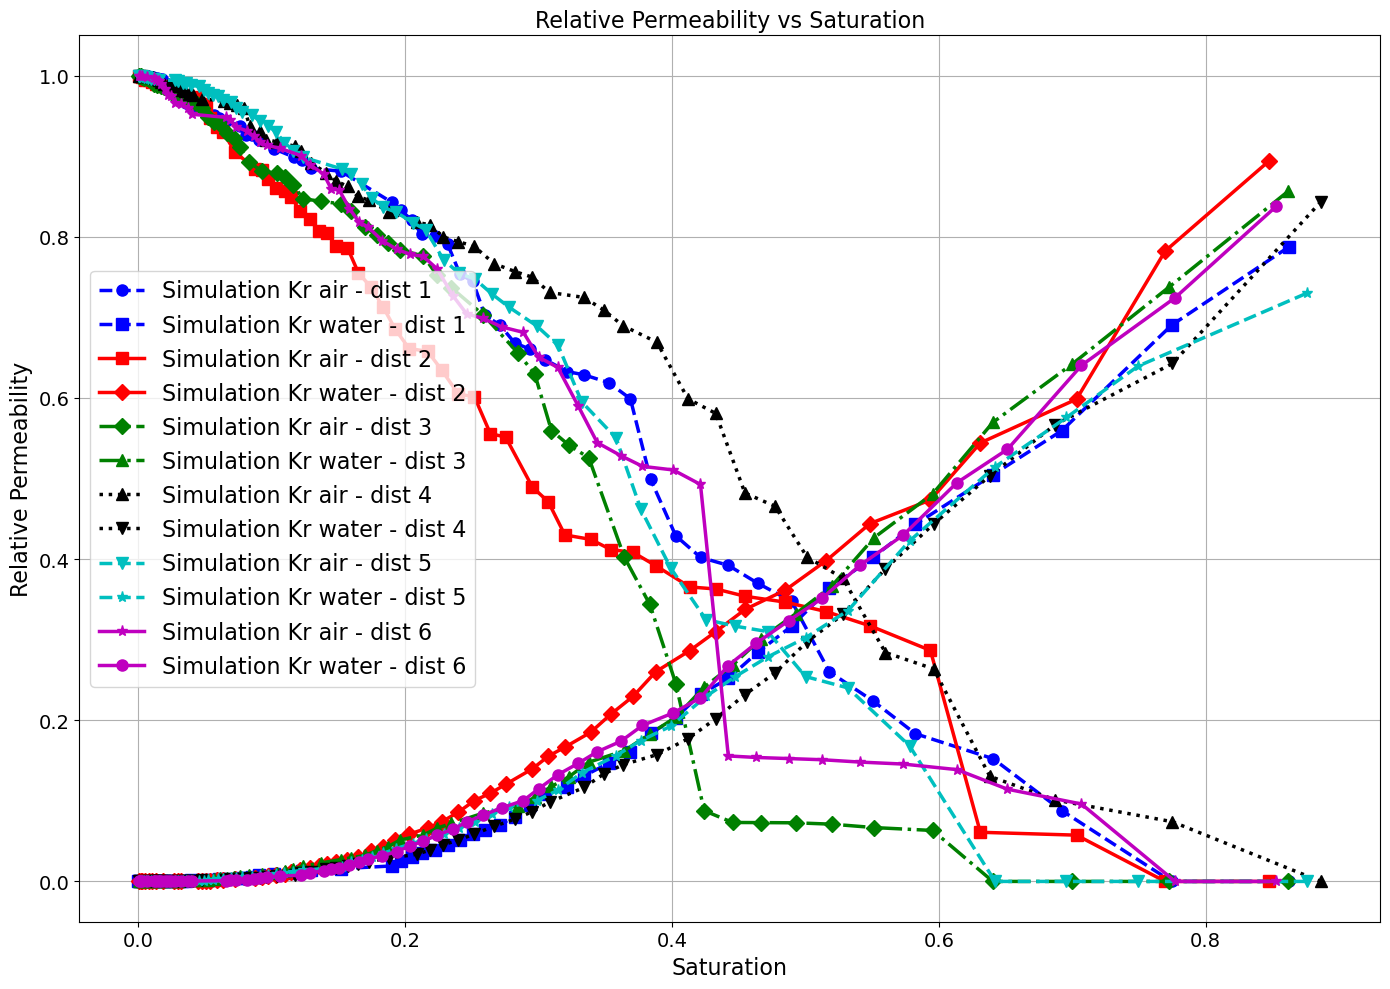

       distribution_key  effective_diffusivity  porosity    tortuosity  \
dist 1           dist 1           3.061002e-11  0.084740  57989.068102   
dist 2           dist 2           3.001759e-11  0.086545  60393.073662   
dist 3           dist 3           2.960848e-11  0.080747  57125.341409   
dist 4           dist 4           3.327202e-11  0.087268  54940.856250   
dist 5           dist 5           2.909556e-11  0.078627  56606.243994   
dist 6           dist 6           3.011331e-11  0.079522  55315.557751   

        Intrinsic permeability  
dist 1            3.817334e-12  
dist 2            3.322233e-12  
dist 3            3.533996e-12  
dist 4            4.608205e-12  
dist 5            4.145647e-12  
dist 6            3.572928e-12  
Results saved to results/scipy_models_psd_impact_on_krl\pore_network_properties_with_distribution.csv


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import porespy as ps
import os

def generate_and_plot_pore_size_distributions(distributions, num_samples):
    """
    Generates and plots pore size distributions using specified SciPy distribution functions.
    
    Parameters:
    distributions (list of tuples): List of tuples where each tuple contains a SciPy distribution function, its parameters, and a label.
    num_samples (int): Number of samples to generate for each distribution.
    Returns:
    List of generated pore sizes for each distribution.
    """
    plt.figure(figsize=(12, 8))
    all_pore_sizes = []
    
    for dist_func, params, label in distributions:
        # Generate random pore sizes using the specified distribution function and parameters
        pore_sizes = dist_func(*params).rvs(size=num_samples)
        
        # Clip the values to ensure they fall within the specified range
        pore_sizes = np.clip(pore_sizes, 0, 10)
        all_pore_sizes.append(pore_sizes)
        
        # Plot the KDE curve
        sns.kdeplot(pore_sizes, label=label, linewidth=2)
    
    plt.xlabel('Pore Size (nm)')
    plt.ylabel('Density')
    plt.title('Pore Size Distributions (0 nm - 10 nm)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return all_pore_sizes

def create_custom_distribution_from_scipy(distribution, params, degree=7,size=1000):
    """
    Generate a custom distribution for pore size based on a given SciPy distribution.

    Parameters:
        distribution (scipy.stats distribution): The SciPy distribution object (e.g., stats.norm).
        params (tuple): Parameters for the distribution (e.g., mean and std_dev for stats.norm).
        size (int): Number of samples to generate. Default is 1000.

    Returns:
        custom_distribution (rv_continuous): A continuous custom distribution for PoreSpy.
    """
    # Generate random data
    pore_sizes = distribution.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=size)

    # Normalize and create a custom distribution
    hist, bin_edges = np.histogram(pore_sizes, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Polynomial fit
    coeffs = np.polyfit(bin_centers, hist, deg=degree)
    polynomial_fit = np.poly1d(coeffs)

    class CustomDistribution(stats.rv_continuous):
        def _pdf(self, x):
            return np.maximum(polynomial_fit(x), 0)

    return CustomDistribution(a=np.min(pore_sizes), b=np.max(pore_sizes))

def generate_and_plot_im_from_scipy_distributions(
    distributions_dict, shape=[200, 100, 100], porosity=0.5, r_min=2, save_directory=None, save_name="Pore_Distributions_and_Images.png"
):
    """
    Generate images from distributions and plot the distributions with corresponding images in one figure.

    Parameters:
        distributions_dict (dict): Dictionary where keys are distribution identifiers (e.g., 'dist 1')
                                   and values are tuples containing:
                                   (distribution function, parameters, descriptive name).
        shape (list): Shape of the 3D image. Default is [200, 100, 100].
        porosity (float): Porosity of the generated image. Default is 0.5.
        r_min (int): Minimum radius for the spheres. Default is 2.
        save_directory (str, optional): Directory to save the plot. If None, the plot is not saved.
        save_name (str, optional): Name of the saved plot. Default is "Pore_Distributions_and_Images.png".
    """
    images = {}
    fig, axes = plt.subplots(len(distributions_dict), 2, figsize=(14, 6 * len(distributions_dict)))

    if len(distributions_dict) == 1:  # If only one distribution, adjust axes for single row
        axes = [axes]

    for idx, (key, (dist, params, name)) in enumerate(distributions_dict.items()):
        print(f"Generating image and plotting distribution for {name}...")
        try:
            # Create custom distribution
            custom_dist = create_custom_distribution_from_scipy(dist, params)
            # Generate image using PoreSpy
            im = ps.generators.polydisperse_spheres(
                shape=shape,
                porosity=porosity,
                dist=custom_dist,
                r_min=r_min
            )
            images[key] = im
            # Plot the distribution's PDF
            x = np.linspace(custom_dist.a, custom_dist.b, 1000)
            y = custom_dist.pdf(x)
            axes[idx][0].plot(x, y, label=name, color='b')
            axes[idx][0].fill_between(x, y, alpha=0.3, color='blue')
            axes[idx][0].set_title(f"Pore Size Distribution: {name}", fontsize=16)
            axes[idx][0].set_xlabel("Pore Size", fontsize=16)
            axes[idx][0].set_ylabel("Probability Density", fontsize=16)
            axes[idx][0].legend(fontsize=16)
            axes[idx][0].tick_params(axis='both', labelsize=14)
            # Plot the image slice
            mid_slice = im[:, :, im.shape[2] // 2]
            axes[idx][1].imshow(mid_slice, cmap="gray", origin="lower")
            axes[idx][1].set_title(f"Generated Image Slice: {name}", fontsize=16)
            axes[idx][1].axis("off")
        except Exception as e:
            print(f"Failed to process {name}: {e}")

    plt.tight_layout()
    # Save the figure if save_directory is provided
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)  # Ensure the directory exists
        save_path = os.path.join(save_directory, save_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    return images

def create_pore_network_from_image(im):
    """
    Create a pore network model from a 3D image using PoreSpy's SNOW algorithm.
    """
    # Generate microstructure
    # Extract the network using SNOW algorithm
    snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']

    print('*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************')
    
    # Create OpenPNM network from the extracted network
    pn = op.io.network_from_porespy(net)
    mods = op.models.collections.geometry.spheres_and_cylinders
    pn.add_model_collection(mods)
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    pn.regenerate_models()

    # Add hydraulic and diffusive size factor models
    pn.add_model(propname='throat.hydraulic_size_factors',
                 model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                 model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    
    # Compute diffusive size factors
    #size_factors = compute_diffusive_size_factor_from_extracted_regions(regions, conns)
    #pn['throat.diffusive_size_factor'] = size_factors
    pn.regenerate_models()

    # Check network health
    h = op.utils.check_network_health(pn)
    print(h)
    
    # Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    return pn

def compute_diffusive_size_factor_from_extracted_regions(regions, connectivity):
    """
    Compute the diffusive size factor from the extracted regions using AI models.
    """
    # Ensure necessary libraries are installed
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Prepare model weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Load AI model and weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)

    # Compute size factors
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=connectivity)

    return size_factors

def create_pore_network_models_from_images(images_dict):
    """
    Create a dictionary of pore network models from a dictionary of images.

    Parameters:
        images_dict (dict): Dictionary where keys are sample names and values are 3D images.

    Returns:
        dict: Dictionary where keys are sample names and values are pore network models.
    """
    pore_network_models = {}

    for sample_name, image in images_dict.items():
        try:
            print(f"Processing sample: {sample_name}")
            # Create the pore network model
            pn = create_pore_network_from_image(image)
            # Store the pore network model in the dictionary
            pore_network_models[sample_name] = pn
        except Exception as e:
            print(f"Failed to create pore network model for {sample_name}: {e}")

    return pore_network_models

def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)
    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()
    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    """ 
    # Compute diffusivity and viscosity
    pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
    pore_viscosity = compute_viscosity(pn['pore.diameter'])
    throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
    throat_viscosity = compute_viscosity(pn['throat.diameter'])
    # Assign diffusivity and viscosity
    pn['pore.diffusivity'] = pore_diffusivity
    pn['pore.viscosity'] = pore_viscosity
    pn['throat.diffusivity'] = throat_diffusivity
    pn['throat.viscosity'] = throat_viscosity

    air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
    water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

    #Assign viscosity using the Arrhenius model
    water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

    #Add the custom surface tension model to the water phase
    water.add_model(propname='pore.surface_tension', model=surface_tension_model)
    
    """
    #Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    air.regenerate_models()
    water.regenerate_models()

    #Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('xmax')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('xmin')
    flow_out = pn.pores('xmax')

    #Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []
    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

### ====== Compute relative permeabilities from dictionary of pore networks =======
def compute_relative_permeabilities(networks_dict):
    """
    Compute relative permeabilities for a dictionary of pore networks.

    Parameters:
        networks_dict (dict): Dictionary where keys are sample names and values are pore network models.

    Returns:
        dict: Dictionary where keys are sample names and values are dictionaries containing:
              - 'Saturation': List of saturations
              - 'kr_nwp': Relative permeability for the non-wetting phase
              - 'kr_wp': Relative permeability for the wetting phase
    """
    results_dict = {}

    for sample_name, network in networks_dict.items():
        try:
            print(f"Processing sample: {sample_name}")
            # Perform relative permeability simulation
            Snwparr, relperm_nwp, relperm_wp = perform_relative_permeability_simulation(network)
            # Store results in the dictionary
            results_dict[sample_name] = {
                "Saturation": Snwparr,
                "kr_nwp": relperm_nwp,
                "kr_wp": relperm_wp
            }
        except Exception as e:
            print(f"Failed to compute relative permeabilities for {sample_name}: {e}")

    return results_dict

def visualize_results(relative_permeabilities_dict, experimental_results=None, csv_directory=None, plot_name="Relative_Permeability_Plot.png"):
    """
    Visualize simulated relative permeability results and compare them with experimental data.
    Parameters:
        relative_permeabilities_dict (dict): Dictionary where keys are sample names and values are dictionaries containing:
                                             - 'Saturation': List of saturations
                                             - 'kr_nwp': List of relative permeabilities for the non-wetting phase
                                             - 'kr_wp': List of relative permeabilities for the wetting phase.
        experimental_results (dict, optional): Dictionary where keys are sample names and values are paths to experimental CSV files.
                                               The CSV files should contain columns ['saturation', 'RelPerm'].
        save_path (str, optional): Path to save the plot. If None, the plot will not be saved.
    """
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '*']
    colors = ['b', 'r', 'g', 'k', 'c', 'm']
    line_width = 2.5
    marker_size = 8
    # Plot simulated results
    for idx, (sample_name, results) in enumerate(relative_permeabilities_dict.items()):
        try:
            saturation = 1 - np.array(results['Saturation'])
            kr_nwp = results['kr_nwp']
            kr_wp = results['kr_wp']

            linestyle_nwp = line_styles[idx % len(line_styles)]
            linestyle_wp = line_styles[idx % len(line_styles)]
            marker_nwp = markers[idx % len(markers)]
            marker_wp = markers[(idx + 1) % len(markers)]
            color_nwp = colors[idx % len(colors)]
            color_wp = colors[idx % len(colors)]

            plt.plot(saturation, kr_nwp, label=f'Simulation Kr air - {sample_name}',
                     linestyle=linestyle_nwp, color=color_nwp, marker=marker_nwp, linewidth=line_width, markersize=marker_size)
            plt.plot(saturation, kr_wp, label=f'Simulation Kr water - {sample_name}',
                     linestyle=linestyle_wp, color=color_wp, marker=marker_wp, linewidth=line_width, markersize=marker_size)
        except KeyError as e:
            print(f"Missing simulation data for {sample_name}: {e}")

    # Plot experimental results if provided
    if experimental_results:
        for idx, (sample_name, file_path) in enumerate(experimental_results.items()):
            try:
                exp_data = pd.read_csv(file_path, delimiter=";")
                saturation_exp = exp_data['saturation']
                relperm_exp = exp_data['RelPerm']
                marker_exp = markers[(idx + 2) % len(markers)]
                color_exp = colors[(idx + 2) % len(colors)]

                plt.scatter(saturation_exp, relperm_exp, label=f'Experimental Kr - {sample_name}',
                            color=color_exp, marker=marker_exp, s=marker_size * 10)
            except Exception as e:
                print(f"Failed to load experimental data for {sample_name}: {e}")

    # Add labels, legend, title, and grid
    plt.xlabel('Saturation', fontsize=16)
    plt.ylabel('Relative Permeability', fontsize=16)
    plt.title('Relative Permeability vs Saturation', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Save the plot if csv_directory is provided
    if csv_directory:
        os.makedirs(csv_directory, exist_ok=True)  # Ensure the directory exists
        plot_path = os.path.join(csv_directory, plot_name)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {plot_path}")

    # Show the plot
    plt.show()

def compute_network_properties(pore_networks_dict,mu_phase=0.001, spacing=1E-5):
    """
    Compute intrinsic permeability, effective diffusivity, porosity, and tortuosity for pore networks,
    and include the distribution key used to generate the associated image.

    Parameters:
        pore_networks_dict (dict): Dictionary of pore networks.
        image_to_distribution_map (dict): Dictionary mapping network keys to their corresponding distribution keys.
        spacing (float): Voxel size in meters. Default is 1E-5.

    Returns:
        dict: Dictionary of computed properties for each network, including the distribution key.
    """
    properties_dict = {}
    for key, pn in pore_networks_dict.items():
        try:

             # Create phases
            air = op.phase.Air(network=pn, name='air')
            air['pore.surface_tension'] = 0.072
            air['pore.contact_angle'] = 140.0
            air.add_model_collection(op.models.collections.phase.air)
            air.add_model_collection(op.models.collections.physics.basic)
           
            water = op.phase.Water(network=pn, name='water')
            water.add_model_collection(op.models.collections.phase.water)
            water.add_model_collection(op.models.collections.physics.basic)

            # Define throat diffusivity for both air and water phases
            air['throat.diffusivity'] = 1e-9  # Example value for air
            water['throat.diffusivity'] = 1e-9  # Example value for water

            air.regenerate_models()
            water.regenerate_models()


            # Fickian Diffusion
            fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
            inlet = pn.pores('xmin')
            outlet = pn.pores('xmax')
            C_in, C_out = [10, 5]
            fd.set_value_BC(pores=inlet, values=C_in)
            fd.set_value_BC(pores=outlet, values=C_out)
            fd.run()

            # Compute effective diffusivity
            A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
            L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
            rate_inlet = fd.rate(pores=inlet)[0]
            D_eff = rate_inlet * L / (A * (C_in - C_out))

            # Compute porosity
            V_p = pn['pore.volume'].sum()
            V_t = pn['throat.volume'].sum()
            V_bulk = A * L
            e = (V_p + V_t) / V_bulk

            # Compute tortuosity
            D_AB = air['pore.diffusivity'][0]
            tau = e * D_AB / D_eff

            # Compute intrinsic permeability
            phase = op.phase.Phase(network=pn)
            phase['pore.viscosity'] =mu_phase  # Viscosity of water at 20°C
            phase.add_model_collection(op.models.collections.physics.basic)
            phase.regenerate_models()

            flow = op.algorithms.StokesFlow(network=pn, phase=phase)
            flow.set_value_BC(pores=inlet, values=1)
            flow.set_value_BC(pores=outlet, values=0)
            flow.run()

            phase.update(flow.soln)
            Q = flow.rate(pores=inlet, mode='group')[0]
            mu = 1
            Delta_P = 1
            K = Q * L * mu / (A * Delta_P)

            properties_dict[key] = {
                "distribution_key": key,
                "effective_diffusivity": D_eff,
                "porosity": e,
                "tortuosity": tau,
                "Intrinsic permeability": K,
            }
        except Exception as e:
            print(f"Failed to compute properties for {key}: {e}")
    return properties_dict

def save_results_to_csv(properties_dict, directory, file_name):
    """
    Save computed properties to a CSV file in a specified directory with a custom name.

    Parameters:
        properties_dict (dict): Dictionary of computed properties.
        directory (str): Directory where the file will be saved.
        file_name (str): Name of the output CSV file.
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Full file path
    file_path = os.path.join(directory, file_name)

    # Save the properties to a CSV file
    df = pd.DataFrame.from_dict(properties_dict, orient='index')
    df.to_csv(file_path)
    print(df)
    print(f"Results saved to {file_path}")

if __name__ == "__main__":

    # Distributions to use
    distributions = {
        "dist 1": (stats.norm, (3., 1), 'Normal Distribution (mean=3, std_dev=1)'),
        "dist 2": (stats.lognorm, (0.5, 0, 2), 'Lognormal Distribution (s=0.5, loc=0, scale=2)'),
        "dist 3": (stats.expon, (0, 2), 'Exponential Distribution (loc=0, scale=2)'),
        "dist 4": (stats.weibull_min, (1.5, 0, 2), 'Weibull Distribution (c=1.5, loc=0, scale=2)'),
        "dist 5": (stats.gamma, (2, 0, 2), 'Gamma Distribution (a=2, loc=0, scale=2)'),
        "dist 6": (stats.beta, (2, 5, 0, 10), 'Beta Distribution (a=2, b=5, loc=0, scale=10)'),
    }
    
    k = 1.38e-23  # Boltzmann constant in J/K
    T = 300  # Temperature in K
    a = 1.52e-10  # Radius of water molecule in meters

    #Specify directory and file name
    output_directory = "results/scipy_models_psd_impact_on_krl"
    file_name = "pore_network_properties_with_distribution.csv"
    
    # Generate pore networks
    images_dict= generate_and_plot_im_from_scipy_distributions(
    distributions, shape=[200, 120, 120], porosity=0.5, r_min=5, save_directory=output_directory, save_name="Pore_Distributions_and_Images.png"
)
    #Create pore network models
    pore_network_models_dict = create_pore_network_models_from_images(images_dict)

    relative_permeabilities_dict = compute_relative_permeabilities(pore_network_models_dict)
    
    pore_networks_properties = compute_network_properties(pore_network_models_dict,mu_phase=0.001, spacing=1E-6)

    #visualize_results(relative_permeabilities_dict,save_path='permeability_vs_from_im_psd_same_poro_no_size_visco_dependence.png')
    visualize_results(relative_permeabilities_dict, experimental_results=None, csv_directory=output_directory, plot_name="Relative_Permeability_Plot.png")
    # Save results to the specified directory
    save_results_to_csv(pore_networks_properties, output_directory, file_name)

### The problem we face is that the computed porosity is not correct, the question is why ? because we provided the porosity as output and then we end up with different porosity, i should have a close look to how the image is generated : 
Ou est ce que la différence vient du fait que la porosité lesuré est la porosité ouverte 

In [6]:
def compute_and_save_tortuosity_results(images_dict, save_directory="results/tortuosity", file_name="Tortuosity_Results.csv"):
    """
    Compute and save the results of tortuosity, formation factor, and effective porosity for given images.

    Parameters:
        images_dict (dict): Dictionary where keys are image identifiers and values are the generated images.
        save_directory (str): Directory to save the results. Default is "results/tortuosity".
        file_name (str): Name of the output CSV file. Default is "Tortuosity_Results.csv".

    Returns:
        dict: Dictionary of computed results for each image.
    """
    os.makedirs(save_directory, exist_ok=True)  # Ensure the directory exists
    results_dict = {}

    for key, im in images_dict.items():
        try:
            # Compute tortuosity results using PoreSpy
            results = ps.simulations.tortuosity_fd(im=im, axis=1)  # Axis can be adjusted based on analysis
            print(f"Results for {key}: {results}")

            # Store results in a dictionary
            results_dict[key] = {
                "tortuosity": results["tortuosity"],
                "formation_factor": results["formation_factor"],
                "effective_porosity": results["porosity"],
            }
        except Exception as e:
            print(f"Failed to compute results for {key}: {e}")

    # Convert results dictionary to a DataFrame and save as CSV
    results_df = pd.DataFrame.from_dict(results_dict, orient="index")
    save_path = os.path.join(save_directory, file_name)
    results_df.to_csv(save_path)
    print(f"Results saved to {save_path}")

    return results_dict


tortuosity_resuklts = compute_and_save_tortuosity_results(images_dict, save_directory="results/tortuosity", file_name="Tortuosity_Results.csv")


NameError: name 'images_dict' is not defined

In [ ]:
pore_networks_properties = compute_network_properties(pore_network_models_dict,mu_phase=0.0001, spacing=1E-5)
 # Save results to the specified directory
save_results_to_csv(pore_networks_properties, output_directory, file_name)

In [7]:
def visualize_results(relative_permeabilities_dict, experimental_results=None, save_path=None):
    """
    Visualize simulated relative permeability results and compare them with experimental data.

    Parameters:
        relative_permeabilities_dict (dict): Dictionary where keys are sample names and values are dictionaries containing:
                                             - 'Saturation': List of saturations
                                             - 'kr_nwp': List of relative permeabilities for the non-wetting phase
                                             - 'kr_wp': List of relative permeabilities for the wetting phase.
        experimental_results (dict, optional): Dictionary where keys are sample names and values are paths to experimental CSV files.
                                               The CSV files should contain columns ['saturation', 'RelPerm'].
        save_path (str, optional): Path to save the plot. If None, the plot will not be saved.
    """
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '*']
    colors = ['b', 'r', 'g', 'k', 'c', 'm']
    line_width = 2.5
    marker_size = 8

    # Plot simulated results
    for idx, (sample_name, results) in enumerate(relative_permeabilities_dict.items()):
        try:
            saturation = 1 - np.array(results['Saturation'])
            kr_nwp = results['kr_nwp']
            kr_wp = results['kr_wp']

            linestyle_nwp = line_styles[idx % len(line_styles)]
            linestyle_wp = line_styles[idx % len(line_styles)]
            marker_nwp = markers[idx % len(markers)]
            marker_wp = markers[(idx) % len(markers)]
            color_nwp = colors[idx % len(colors)]
            color_wp = colors[idx % len(colors)]

            plt.plot(saturation, kr_nwp, label=f'Simulation Kr air - {sample_name}',
                     linestyle=linestyle_nwp, color=color_nwp, marker=marker_nwp, linewidth=line_width, markersize=marker_size)
            plt.plot(saturation, kr_wp, label=f'Simulation Kr water - {sample_name}',
                     linestyle=linestyle_wp, color=color_wp, marker=marker_wp, linewidth=line_width, markersize=marker_size)
        except KeyError as e:
            print(f"Missing simulation data for {sample_name}: {e}")

    # Add labels, legend, title, and grid
    plt.xlabel('Saturation', fontsize=16)
    plt.ylabel('Relative Permeability', fontsize=16)
    plt.title('Relative Permeability vs Saturation', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    #Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

visualize_results(relative_permeabilities_dict,experimental_data_dict)


NameError: name 'relative_permeabilities_dict' is not defined

### Analysis of the results
If we take into account the viscosity size dependence we obtain this:
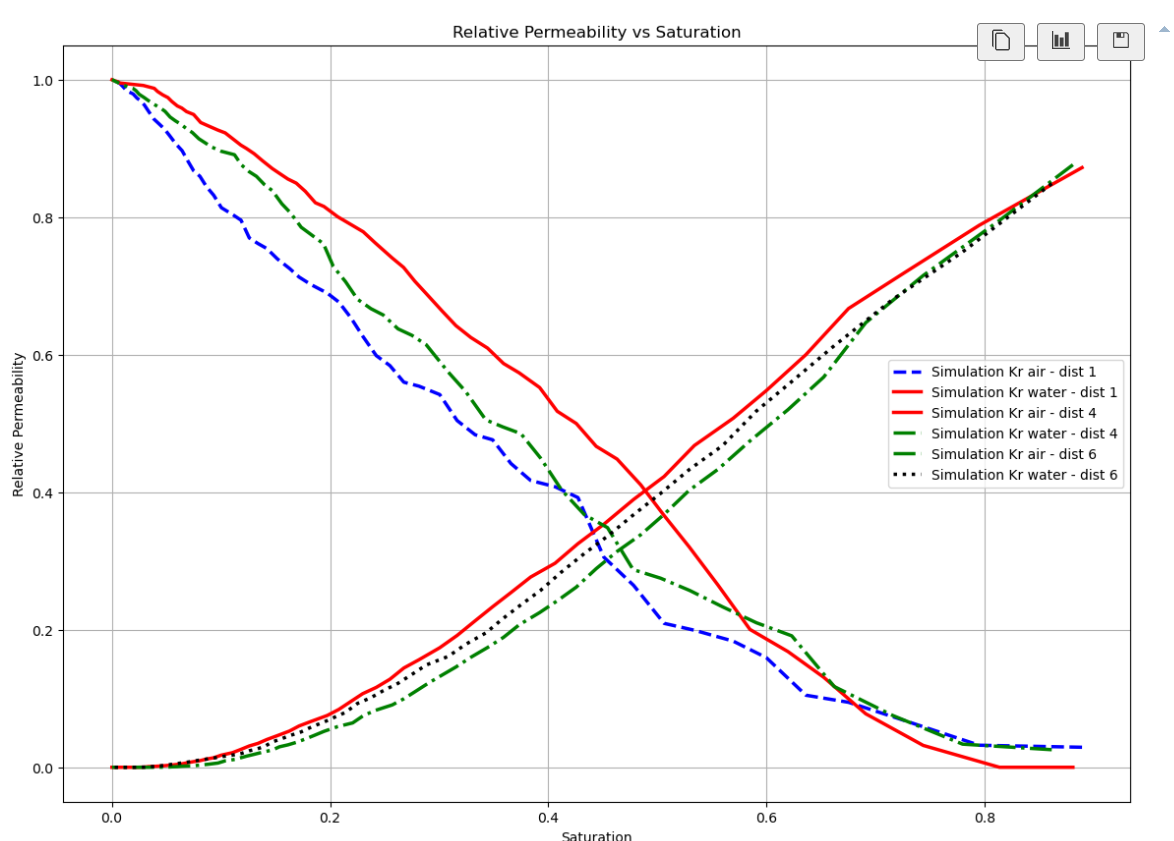

If we dont accoun for the viscosity size dependence wwe get this :
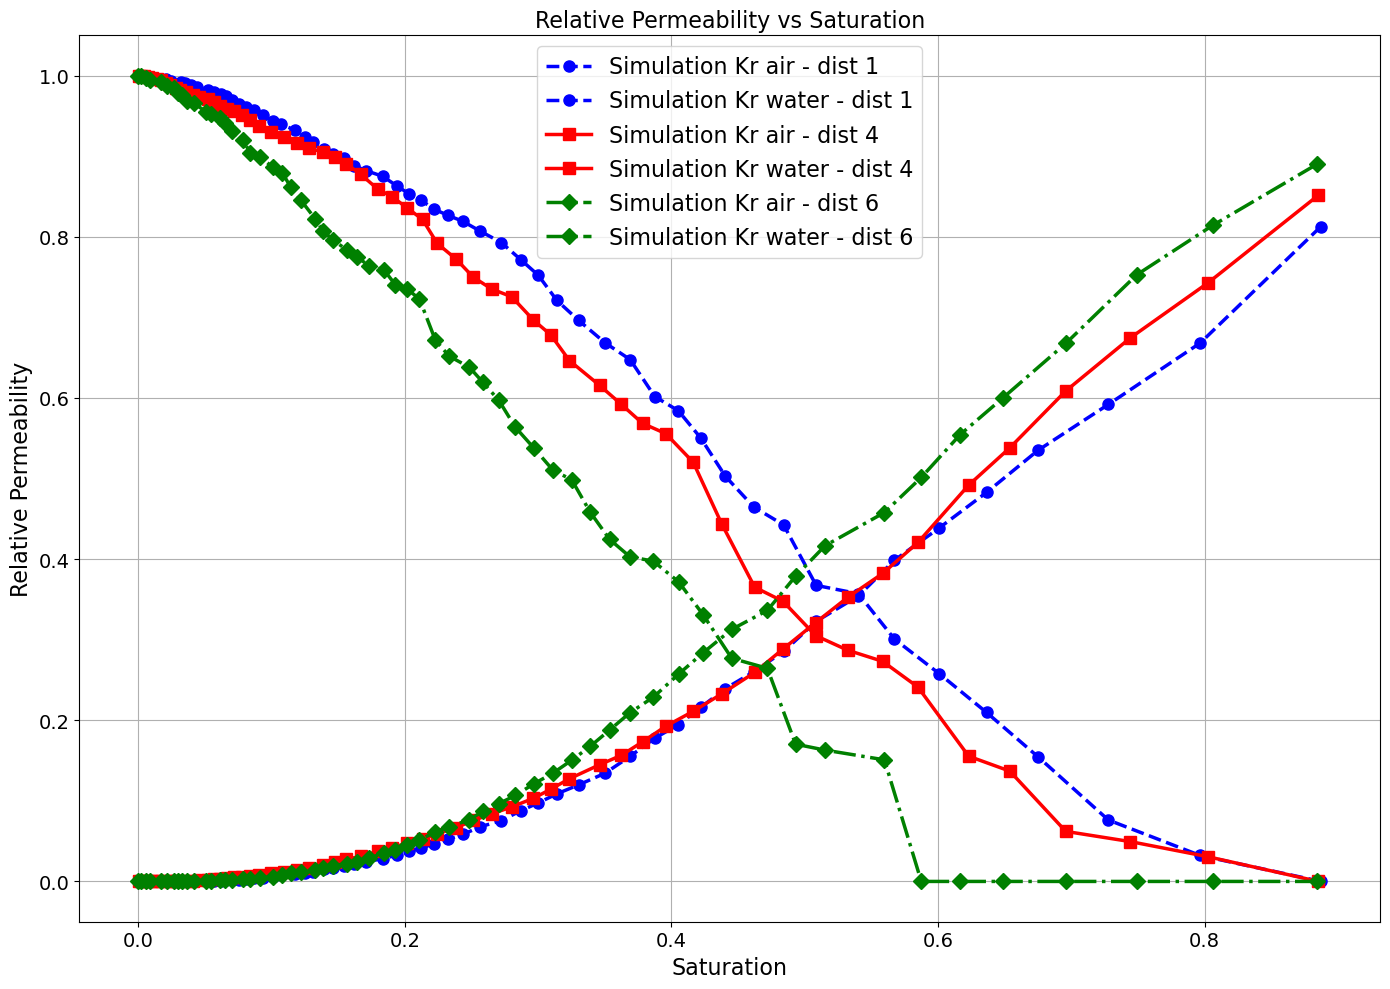

### Compound log normale distribution

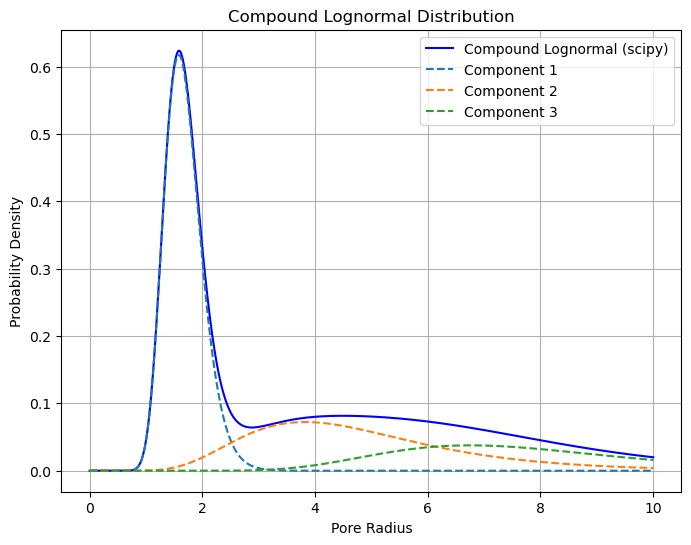

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous

class CompoundLogNormal(rv_continuous):
    """
    A custom scipy.stats distribution for the compound lognormal distribution.
    """
    def __init__(self, weights, mus, sigmas, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if len(weights) != len(mus) or len(mus) != len(sigmas):
            raise ValueError("Length of weights, mus, and sigmas must be the same.")
        if not np.isclose(sum(weights), 1):
            raise ValueError("Weights must sum to 1.")
        
        self.weights = weights
        self.mus = mus
        self.sigmas = sigmas

    def _pdf(self, r):
        """
        Probability density function for the compound lognormal distribution.
        """
        pdf = np.zeros_like(r)
        for weight, mu, sigma in zip(self.weights, self.mus, self.sigmas):
            pdf += weight * (1 / (sigma * np.sqrt(2 * np.pi) * r)) * np.exp(-((np.log(r) - mu) ** 2) / (2 * sigma ** 2))
        return pdf

# Define lognormal_distribution and compound_lognormal_distribution for individual component visualization
def lognormal_distribution(r, mu, sigma):
    """
    Single lognormal distribution function.

    Parameters:
        r (array): Pore radii values.
        mu (float): Mean of the log-transformed data.
        sigma (float): Standard deviation of the log-transformed data.

    Returns:
        array: Lognormal distribution values.
    """
    return (1 / (sigma * np.sqrt(2 * np.pi) * r)) * np.exp(-((np.log(r) - mu) ** 2) / (2 * sigma ** 2))

def compound_lognormal_distribution(r, weights, mus, sigmas):
    """
    Compound lognormal distribution function.

    Parameters:
        r (array): Pore radii values.
        weights (list): Weights of each lognormal component.
        mus (list): Means of the log-transformed data for each component.
        sigmas (list): Standard deviations of the log-transformed data for each component.

    Returns:
        array: Compound lognormal distribution values.
    """
    if len(weights) != len(mus) or len(mus) != len(sigmas):
        raise ValueError("Length of weights, mus, and sigmas must be the same.")
    
    if not np.isclose(sum(weights), 1):
        raise ValueError("Weights must sum to 1.")

    compound_distribution = np.zeros_like(r)
    for weight, mu, sigma in zip(weights, mus, sigmas):
        compound_distribution += weight * lognormal_distribution(r, mu, sigma)

    return compound_distribution

# Example usage
if __name__ == "__main__":
    # Define pore radii range
    r = np.linspace(0.001, 10, 1000)  # Pore radii from 0.001 to 10 (arbitrary units)

    # Define parameters for the compound lognormal distribution
    weights = [0.5, 0.3, 0.2]  # Weights of each component (must sum to 1)
    mus = [0.5, 1.5, 2.0]      # Means of the log-transformed data
    sigmas = [0.2, 0.4, 0.3]   # Standard deviations of the log-transformed data

    # Create custom distribution
    compound_dist = CompoundLogNormal(weights=weights, mus=mus, sigmas=sigmas, name="compound_lognormal")

    # Compute PDF using the custom scipy distribution
    pdf = compound_dist.pdf(r)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(r, pdf, label="Compound Lognormal (scipy)", color="blue")

    # Plot individual components
    for i, (weight, mu, sigma) in enumerate(zip(weights, mus, sigmas)):
        plt.plot(r, weight * lognormal_distribution(r, mu, sigma), '--', label=f"Component {i+1}")

    plt.xlabel("Pore Radius")
    plt.ylabel("Probability Density")
    plt.title("Compound Lognormal Distribution")
    plt.legend()
    plt.grid()
    plt.show()


C:\Users\Ce pc\AppData\Local\Temp\ipykernel_34576\2069237120.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cdf_val = quad(self._pdf, lower_bound, x_val)[0]


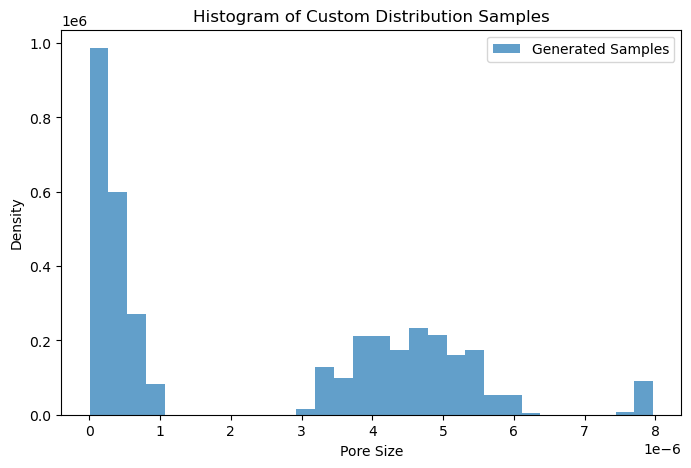

[18:04:28] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=579128;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=226341;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#74\74]8;;\

[18:10:04] ERROR    Inlet/outlet rates don't match: 7.6357e+01 vs. -7.6334e+01                          ]8;id=338761;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=427540;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#107\107]8;;\

im2 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Sun Dec  8 18:10:07 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (300, 300, 300)
tortuosity                1.8269089494045188
formation_factor          3.942049774159136
original_porosity         0.46356366666666665
effective_porosity        0.46344137037037036
concentration             Array of size (300, 300, 300)
sys                       (<12512917x12512917 sparse matrix of type '<class 'numpy.float64'>'
	with 78920395 stored elements in COOrdinate format>, array([5.35974354, 5.35974354, 5.35974354, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


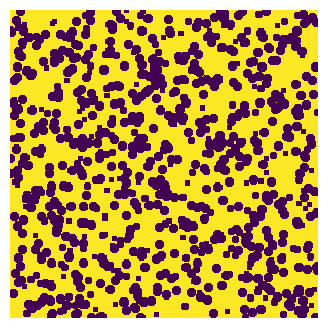

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous
from scipy.integrate import quad
import porespy as ps

def create_custom_distribution_with_bounds(x, y, degree=4):
    """
    Create a custom scipy.stats continuous distribution based on pore size distribution data,
    with proper normalization and bounds.
    """
    # Perform a polynomial fit
    coeffs = np.polyfit(x, y, degree)
    polynomial_fit = np.poly1d(coeffs)

    # Define bounds based on data
    lower_bound = np.min(x)
    upper_bound = np.max(x)

    # Precompute total area under the PDF for normalization
    def unnormalized_pdf(val):
        return np.maximum(polynomial_fit(val), 0)

    total_area = quad(unnormalized_pdf, lower_bound, upper_bound)[0]

    class CustomDistribution(rv_continuous):
        def _pdf(self, x_val):
            # Return normalized PDF values
            return np.maximum(polynomial_fit(x_val), 0) / total_area

        def _cdf(self, x_val):
            # Integrate the normalized PDF from lower_bound to x_val
            cdf_val = quad(self._pdf, lower_bound, x_val)[0]
            return cdf_val

    # Create and return an instance of the custom distribution
    return CustomDistribution(a=lower_bound, b=upper_bound, name="custom_distribution")


file_path = "psd_from_these_mazen_concrete_max.csv"
try:
    psd_data = pd.read_csv(file_path, delimiter=';')
except Exception:
    try:
        psd_data = pd.read_csv(file_path, delimiter=',')
    except Exception:
        try:
            psd_data = pd.read_csv(file_path, delimiter=r'\s+')
        except Exception as e:
            psd_data = None
            error_message = str(e)

x = psd_data.iloc[:, 0].values*1e-9  # Assume the first column is x
y = psd_data.iloc[:, 1].values  # Assume the second column is y    

# Create the custom distribution
custom_distribution = create_custom_distribution_with_bounds(x, y, degree=4)

# Generate random samples to test
samples = custom_distribution.rvs(size=1000)

# Visualize the distribution of generated samples
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=30, density=True, alpha=0.7, label='Generated Samples')
plt.xlabel('Pore Size')
plt.ylabel('Density')
plt.title('Histogram of Custom Distribution Samples')
plt.legend()
plt.show()

# Use the custom_distribution in polydisperse_spheres
shape = [300,300,300]  # Example shape
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.5,
                                        dist=custom_distribution,
                                        r_min=5)
### Visualization of generated image
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False)

### Compute tortuosity

 #Compute tortuosity
tortuosity_results = ps.simulations.tortuosity_fd(im=im, axis=1)
print("im2",tortuosity_results)

## Compute diffusive size factors

In [9]:
import os
import importlib
import h5py
import tensorflow as tf
import porespy as ps
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define the function
def compute_diffusive_size_factor_from_image(im,voxel_size=1.e-6):
    # Step 1: Install and Import Required Libraries
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Step 2: Prepare the Model Weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Step 3: Load AI Model and Weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)

    # Step 5: Extract Network Using SNOW Algorithm
    snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=voxel_size)
    regions = snow.regions
    connectivity = snow.network['throat.conns']
    
    # Optional: Plot the Generated Image
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)
    plt.show()

    # Step 6: Compute Size Factors Using Provided Connectivity
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=connectivity)

    return size_factors

file_path = "psd_from_these_mazen_concrete_max.csv"
try:
    psd_data = pd.read_csv(file_path, delimiter=';')
except Exception:
    try:
        psd_data = pd.read_csv(file_path, delimiter=',')
    except Exception:
        try:
            psd_data = pd.read_csv(file_path, delimiter=r'\s+')
        except Exception as e:
            psd_data = None
            error_message = str(e)

x = psd_data.iloc[:, 0].values*1e-9  # Assume the first column is x
y = psd_data.iloc[:, 1].values  # Assume the second column is y    


# Example usage
#np.random.seed(17)
#shape = [120, 120, 120]
#dist = sp.stats.norm(loc=7, scale=5)
#im = ps.generators.polydisperse_spheres(shape=shape, porosity=0.7, dist=dist, r_min=7)

# Create the custom distribution
dist = create_custom_distribution_with_bounds(x, y, degree=4)
shape = [120,120,120]  # Example shape
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.5,
                                        dist=dist,
                                        r_min=5)
snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1)
size_factors = compute_diffusive_size_factor_from_image(im,voxel_size=1e-6)

print(size_factors)

NameError: name 'create_custom_distribution_with_bounds' is not defined

## Compute the relative permeability from images

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1172 [00:00<?, ?it/s]

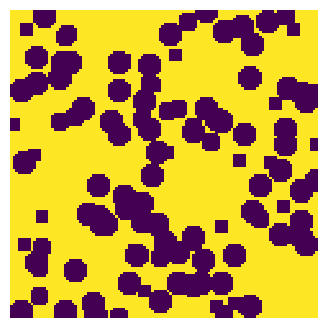

Preparing images tensor:   0%|          | 0/3139 [00:00<?, ?it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step
*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats         

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import scipy.stats as stats
import os
import logging
import csv
import openpnm as op
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from datetime import datetime
import porespy as ps
from tensorflow.keras.optimizers import Adam

def compute_diffusive_size_factor_from_extracted_regions(regions,connectivity):
    # Step 1: Install and Import Required Libraries
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Step 2: Prepare the Model Weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Step 3: Load AI Model and Weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)
    
    # Optional: Plot the Generated Image
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)
    plt.show()

    # Step 6: Compute Size Factors Using Provided Connectivity
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=connectivity)

    return size_factors

def create_pore_network_from_image(im):
 
    # Generate microstructure
    # Extract the network using snow algorithm
    snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']
    
    size_factors= compute_diffusive_size_factor_from_extracted_regions(regions,conns)

    print('*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************')
    # Create network from porespy segmented image
    pn = op.io.network_from_porespy(net)
    mods = op.models.collections.geometry.spheres_and_cylinders
    pn.add_model_collection(mods)
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    pn.regenerate_models()

    pn.add_model(propname='throat.hydraulic_size_factors',
                    model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                    model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    
    pn['throat.diffusive_size_factor'] =  size_factors
    pn.regenerate_models()
    
    # Check network health
    h = op.utils.check_network_health(pn)
    print(h)

    # Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    return pn

file_path = "psd_from_these_mazen_concrete_max.csv"
try:
    psd_data = pd.read_csv(file_path, delimiter=';')
except Exception:
    try:
        psd_data = pd.read_csv(file_path, delimiter=',')
    except Exception:
        try:
            psd_data = pd.read_csv(file_path, delimiter=r'\s+')
        except Exception as e:
            psd_data = None
            error_message = str(e)

x = psd_data.iloc[:, 0].values*1e-9  # Assume the first column is x
y = psd_data.iloc[:, 1].values  # Assume the second column is y    

# Example usage
#np.random.seed(17)
#shape = [120, 120, 120]
#dist = sp.stats.norm(loc=7, scale=5)
#im = ps.generators.polydisperse_spheres(shape=shape, porosity=0.7, dist=dist, r_min=7)

# Create the custom distribution
dist = create_custom_distribution_with_bounds(x, y, degree=4)
shape = [120,120,120]  # Example shape
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.5,
                                        dist=dist,
                                        r_min=5)

pn=create_pore_network_from_image(im)

In [24]:
# Function to perform relative permeability simulation on a pore network
def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('xmax')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('xmin')
    flow_out = pn.pores('xmax')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)


Snwparr, relperm_nwp, relperm_wp = perform_relative_permeability_simulation(pn)

[21:02:29] WARNING  air is already taken, using air_03 instead                                      ]8;id=533957;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=436510;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  water is already taken, using water_03 instead                                  ]8;id=705279;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py\_project.py]8;;\:]8;id=282886;file://c:\Anaconda\Lib\site-packages\openpnm\utils\_project.py#154\154]8;;\

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=154703;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=580584;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=400781;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=523586;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

## Putting all together

In [ ]:

def read_csv_with_auto_separator(file_path):
    """
    Reads a CSV file and automatically detects the separator.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the file data.
    """
    try:
        with open(file_path, 'r') as file:
            sample = file.read(1024)  # Read a sample of the file
            dialect = csv.Sniffer().sniff(sample)  # Detect the delimiter
            file.seek(0)  # Reset file pointer to the beginning
            return pd.read_csv(file, delimiter=dialect.delimiter)
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return None
    
def create_custom_distribution_with_bounds(x, y, degree=4): 
    """
    Create a custom scipy.stats continuous distribution based on pore size distribution data,
    with proper normalization and bounds.
    """
    # Perform a polynomial fit
    coeffs = np.polyfit(x, y, degree)
    polynomial_fit = np.poly1d(coeffs)

    # Define bounds based on data
    lower_bound = np.min(x)
    upper_bound = np.max(x)

    # Precompute total area under the PDF for normalization
    def unnormalized_pdf(val):
        return np.maximum(polynomial_fit(val), 0)

    total_area = quad(unnormalized_pdf, lower_bound, upper_bound)[0]

    class CustomDistribution(rv_continuous):
        def _pdf(self, x_val):
            # Return normalized PDF values
            return np.maximum(polynomial_fit(x_val), 0) / total_area

        def _cdf(self, x_val):
            # Integrate the normalized PDF from lower_bound to x_val
            cdf_val = quad(self._pdf, lower_bound, x_val)[0]
            return cdf_val

    # Create and return an instance of the custom distribution
    return CustomDistribution(a=lower_bound, b=upper_bound, name="custom_distribution")


def generate_customized_dictionary(file_paths, porosities, radii, degree=4):
    """
    Generate a dictionary containing customized distributions, porosity, and minimum radius for each sample.

    Parameters:
        file_paths (dict): Dictionary where keys are sample names and values are file paths to CSV files.
        porosities (dict): Dictionary where keys are sample names and values are porosity values.
        radii (dict): Dictionary where keys are sample names and values are minimum radius values.
        degree (int): Degree of the polynomial fit.

    Returns:
        dict: Dictionary where keys are sample names and values are dictionaries containing:
              'distribution', 'porosity', and 'r_min'.
    """
    customized_dict = {}

    for sample_name, file_path in file_paths.items():
        if psd_data is None:
            continue
        try:
            # Load data from the file
            psd_data = pd.read_csv(file_path, delimiter=';')
        except Exception:
            try:
                psd_data = pd.read_csv(file_path, delimiter=',')
            except Exception:
                try:
                    psd_data = pd.read_csv(file_path, delimiter=r'\s+')
                except Exception as e:
                    print(f"Failed to read {file_path} for {sample_name}: {e}")
                    continue
        
        # Extract x and y values
        x = psd_data.iloc[:, 0].values * 1e-9  # Convert to meters
        y = psd_data.iloc[:, 1].values        # Probability or frequency values

        # Create the custom distribution
        custom_distribution = create_custom_distribution_with_bounds(x, y, degree=degree)
        plt.plot(custom_distribution)
        
        # Get porosity and r_min for the sample
        porosity = porosities.get(sample_name, 0.5)  # Default porosity is 0.5 if not provided
        r_min = radii.get(sample_name, 5)           # Default r_min is 5 if not provided

        # Store the result in the dictionary
        customized_dict[sample_name] = {
            "distribution": custom_distribution,
            "porosity": porosity,
            "r_min": r_min
        }

    return customized_dict


def generate_and_save_images_from_experimental_distributions(file_paths, porosities, radii, output_directory="output", default_shape=[200, 120, 120], degree=10):
    """
    Generate images from experimental distributions, plot the histogram and image slice, 
    and save the results with unique filenames to an output directory.

    Parameters:
        file_paths (dict): Dictionary where keys are sample names and values are file paths to CSV files.
        porosities (dict): Dictionary where keys are sample names and values are porosity values.
        radii (dict): Dictionary where keys are sample names and values are minimum radius values.
        output_directory (str): Directory to save the results. Defaults to "output".
        default_shape (list): Default shape of the image. Defaults to [200, 120, 120].
        degree (int): Degree of the polynomial fit.

    Returns:
        dict: Dictionary where keys are sample names and values are the generated images.
    """
    os.makedirs(output_directory, exist_ok=True)  # Ensure the output directory exists
    images = {}

    for sample_name, file_path in file_paths.items():
        # Use the robust CSV reader
        psd_data = read_csv_with_auto_separator(file_path)
        print(psd_data)

        # Extract x and y values
        x = psd_data.iloc[:, 0].values * 1e-9  # Convert to meters
        y = psd_data.iloc[:, 1].values        # Probability or frequency values

        # Create the custom distribution
        custom_distribution = create_custom_distribution_with_bounds(x, y, degree=degree)

        # Get porosity and r_min for the sample
        porosity = porosities.get(sample_name, 0.5)  # Default porosity is 0.5 if not provided
        r_min = radii.get(sample_name, 5)           # Default r_min is 5 if not provided

        try:
            # Generate the image
            im = ps.generators.polydisperse_spheres(
                shape=default_shape,
                porosity=porosity,
                dist=custom_distribution,
                r_min=r_min
            )
            # Store the image in the dictionary
            images[sample_name] = im

            # Plot the histogram and image slice
            fig, ax = plt.subplots(1, 2, figsize=(14, 6))

            # Plot the histogram (Pore Size Distribution)
            ax[0].plot(x, y, label=f"{sample_name} PSD", color='b')
            ax[0].fill_between(x, y, alpha=0.3, color='blue')
            ax[0].set_title(f"Pore Size Distribution: {sample_name}", fontsize=16)
            ax[0].set_xlabel("Pore Size (m)", fontsize=16)
            ax[0].set_ylabel("Frequency", fontsize=16)
            ax[0].legend(fontsize=14)
            ax[0].tick_params(axis='both', labelsize=12)

            # Plot the slice of the generated image
            mid_slice = im[:, :, im.shape[2] // 2]
            ax[1].imshow(mid_slice, cmap="gray", origin="lower")
            ax[1].set_title(f"Generated Image Slice: {sample_name}", fontsize=16)
            ax[1].axis("off")

            # Save the plot
            plot_filename = f"{sample_name}_Histogram_and_Slice.png"
            plot_path = os.path.join(output_directory, plot_filename)
            plt.tight_layout()
            plt.savefig(plot_path, dpi=300, bbox_inches="tight")
            print(f"Saved plot for {sample_name} to {plot_path}")

            # Close the plot to free memory
            plt.close(fig)

        except Exception as e:
            print(f"Failed to process {sample_name}: {e}")

    return images

def create_pore_network_from_image(im):
    """
    Create a pore network model from a 3D image using PoreSpy's SNOW algorithm.
    """
    # Generate microstructure
    # Extract the network using SNOW algorithm
    snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']

    print('*******  END COMPUTATION OF DIFFUSIVE SIZE FACTOR ************')
    
    # Create OpenPNM network from the extracted network
    pn = op.io.network_from_porespy(net)
    mods = op.models.collections.geometry.spheres_and_cylinders
    pn.add_model_collection(mods)
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    pn.regenerate_models()

    # Add hydraulic and diffusive size factor models
    pn.add_model(propname='throat.hydraulic_size_factors',
                 model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                 model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    
    # Compute diffusive size factors
    #size_factors = compute_diffusive_size_factor_from_extracted_regions(regions, conns)
    #pn['throat.diffusive_size_factor'] = size_factors
    pn.regenerate_models()

    # Check network health
    h = op.utils.check_network_health(pn)
    print(h)
    
    # Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    return pn


def compute_diffusive_size_factor_from_extracted_regions(regions, connectivity):
    """
    Compute the diffusive size factor from the extracted regions using AI models.
    """
    # Ensure necessary libraries are installed
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Prepare model weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Load AI model and weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)

    # Compute size factors
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=connectivity)

    return size_factors

def create_pore_network_models_from_images(images_dict):
    """
    Create a dictionary of pore network models from a dictionary of images.

    Parameters:
        images_dict (dict): Dictionary where keys are sample names and values are 3D images.

    Returns:
        dict: Dictionary where keys are sample names and values are pore network models.
    """
    pore_network_models = {}

    for sample_name, image in images_dict.items():
        try:
            print(f"Processing sample: {sample_name}")
            # Create the pore network model
            pn = create_pore_network_from_image(image)
            # Store the pore network model in the dictionary
            pore_network_models[sample_name] = pn
        except Exception as e:
            print(f"Failed to create pore network model for {sample_name}: {e}")

    return pore_network_models

def perform_relative_permeability_simulation(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)

    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0 # Test different contact angles
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air # Test different diffusivity values 
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Compute diffusivity and viscosity
    pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
    pore_viscosity = compute_viscosity(pn['pore.diameter'])
    throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
    throat_viscosity = compute_viscosity(pn['throat.diameter'])
    # Assign diffusivity and viscosity
    pn['pore.diffusivity'] = pore_diffusivity
    pn['pore.viscosity'] = pore_viscosity
    pn['throat.diffusivity'] = throat_diffusivity
    pn['throat.viscosity'] = throat_viscosity

    air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
    water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

    # Assign viscosity using the Arrhenius model
    water.add_model(propname='pore.viscosity', model=viscosity_arrhenius) ## What is the effect of viscosity value 
    # Add the custom surface tension model to the water phase
    water.add_model(propname='pore.surface_tension', model=surface_tension_model)
  
    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('xmax')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('xmin')
    flow_out = pn.pores('xmax')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

def compute_relative_permeabilities(networks_dict):
    """
    Compute relative permeabilities for a dictionary of pore networks.

    Parameters:
        networks_dict (dict): Dictionary where keys are sample names and values are pore network models.

    Returns:
        dict: Dictionary where keys are sample names and values are dictionaries containing:
              - 'Saturation': List of saturations
              - 'kr_nwp': Relative permeability for the non-wetting phase
              - 'kr_wp': Relative permeability for the wetting phase
    """
    results_dict = {}

    for sample_name, network in networks_dict.items():
        try:
            print(f"Processing sample: {sample_name}")
            # Perform relative permeability simulation
            Snwparr, relperm_nwp, relperm_wp = perform_relative_permeability_simulation(network)
            # Store results in the dictionary
            results_dict[sample_name] = {
                "Saturation": Snwparr,
                "kr_nwp": relperm_nwp,
                "kr_wp": relperm_wp
            }
        except Exception as e:
            print(f"Failed to compute relative permeabilities for {sample_name}: {e}")

    return results_dict


def visualize_results(relative_permeabilities_dict, experimental_results=None, csv_directory=None, plot_name="Relative_Permeability_Plot.png"):
    """
    Visualize simulated relative permeability results and compare them with experimental data.

    Parameters:
        relative_permeabilities_dict (dict): Dictionary where keys are sample names and values are dictionaries containing:
                                             - 'Saturation': List of saturations
                                             - 'kr_nwp': List of relative permeabilities for the non-wetting phase
                                             - 'kr_wp': List of relative permeabilities for the wetting phase.
        experimental_results (dict, optional): Dictionary where keys are sample names and values are paths to experimental CSV files.
                                               The CSV files should contain columns ['saturation', 'RelPerm'].
        save_path (str, optional): Path to save the plot. If None, the plot will not be saved.
    """
    plt.figure(figsize=(14, 10))
    line_styles = ['--', '-', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '*']
    colors = ['b', 'r', 'g', 'k', 'c', 'm']
    line_width = 2.5
    marker_size = 8

    # Plot simulated results
    for idx, (sample_name, results) in enumerate(relative_permeabilities_dict.items()):
        try:
            saturation = 1 - np.array(results['Saturation'])
            kr_nwp = results['kr_nwp']
            kr_wp = results['kr_wp']

            linestyle_nwp = line_styles[idx % len(line_styles)]
            linestyle_wp = line_styles[idx % len(line_styles)]
            marker_nwp = markers[idx % len(markers)]
            marker_wp = markers[(idx + 1) % len(markers)]
            color_nwp = colors[idx % len(colors)]
            color_wp = colors[idx % len(colors)]

            plt.plot(saturation, kr_nwp, label=f'Simulation Kr air - {sample_name}',
                     linestyle=linestyle_nwp, color=color_nwp, marker=marker_nwp, linewidth=line_width, markersize=marker_size)
            plt.plot(saturation, kr_wp, label=f'Simulation Kr water - {sample_name}',
                     linestyle=linestyle_wp, color=color_wp, marker=marker_wp, linewidth=line_width, markersize=marker_size)
        except KeyError as e:
            print(f"Missing simulation data for {sample_name}: {e}")

    # Plot experimental results if provided
    if experimental_results:
        for idx, (sample_name, file_path) in enumerate(experimental_results.items()):
            try:
                exp_data = pd.read_csv(file_path, delimiter=";")
                saturation_exp = exp_data['saturation']
                relperm_exp = exp_data['RelPerm']
                marker_exp = markers[(idx + 2) % len(markers)]
                color_exp = colors[idx % len(colors)]

                plt.scatter(saturation_exp, relperm_exp, label=f'Experimental Kr - {sample_name}',
                            color=color_exp, marker=marker_exp, s=marker_size * 10)
            except Exception as e:
                print(f"Failed to load experimental data for {sample_name}: {e}")

    # Add labels, legend, title, and grid
    plt.xlabel('Saturation', fontsize=16)
    plt.ylabel('Relative Permeability', fontsize=16)
    plt.title('Relative Permeability vs Saturation', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Save the plot if csv_directory is provided
    if csv_directory:
        os.makedirs(csv_directory, exist_ok=True)  # Ensure the directory exists
        plot_path = os.path.join(csv_directory, plot_name)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {plot_path}")

    # Show the plot
    plt.show()

def compute_network_properties(pore_networks_dict,mu_phase=0.001, spacing=1E-5):
    """
    Compute intrinsic permeability, effective diffusivity, porosity, and tortuosity for pore networks,
    and include the distribution key used to generate the associated image.

    Parameters:
        pore_networks_dict (dict): Dictionary of pore networks.
        image_to_distribution_map (dict): Dictionary mapping network keys to their corresponding distribution keys.
        spacing (float): Voxel size in meters. Default is 1E-5.

    Returns:
        dict: Dictionary of computed properties for each network, including the distribution key.
    """
    properties_dict = {}
    for key, pn in pore_networks_dict.items():
        try:

             # Create phases
            air = op.phase.Air(network=pn, name='air')
            air['pore.surface_tension'] = 0.072
            air['pore.contact_angle'] = 140.0
            air.add_model_collection(op.models.collections.phase.air)
            air.add_model_collection(op.models.collections.physics.basic)
           
            water = op.phase.Water(network=pn, name='water')
            water.add_model_collection(op.models.collections.phase.water)
            water.add_model_collection(op.models.collections.physics.basic)

            # Define throat diffusivity for both air and water phases
            air['throat.diffusivity'] = 1e-9  # Example value for air
            water['throat.diffusivity'] = 1e-9  # Example value for water

            air.regenerate_models()
            water.regenerate_models()

            # Fickian Diffusion
            fd = op.algorithms.FickianDiffusion(network=pn, phase=air)
            inlet = pn.pores('xmin')
            outlet = pn.pores('xmax')
            C_in, C_out = [10, 5]
            fd.set_value_BC(pores=inlet, values=C_in)
            fd.set_value_BC(pores=outlet, values=C_out)
            fd.run()

            # Compute effective diffusivity
            A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
            L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
            rate_inlet = fd.rate(pores=inlet)[0]
            D_eff = rate_inlet * L / (A * (C_in - C_out))

            # Compute porosity
            V_p = pn['pore.volume'].sum()
            V_t = pn['throat.volume'].sum()
            V_bulk = A * L
            e = (V_p + V_t) / V_bulk

            # Compute tortuosity
            D_AB = air['pore.diffusivity'][0]
            tau = e * D_AB / D_eff

            # Compute intrinsic permeability
            phase = op.phase.Phase(network=pn)
            phase['pore.viscosity'] =mu_phase  # Viscosity of water at 20°C
            phase.add_model_collection(op.models.collections.physics.basic)
            phase.regenerate_models()

            flow = op.algorithms.StokesFlow(network=pn, phase=phase)
            flow.set_value_BC(pores=inlet, values=1)
            flow.set_value_BC(pores=outlet, values=0)
            flow.run()

            phase.update(flow.soln)
            Q = flow.rate(pores=inlet, mode='group')[0]
            mu = 1
            Delta_P = 1
            K = Q * L * mu / (A * Delta_P)

            properties_dict[key] = {
                "distribution_key": key,
                "effective_diffusivity": D_eff,
                "porosity": e,
                "tortuosity": tau,
                "Intrinsic permeability": K,
            }
        except Exception as e:
            print(f"Failed to compute properties for {key}: {e}")
            
    return properties_dict

def save_results_to_csv(properties_dict, directory, file_name):
    """
    Save computed properties to a CSV file in a specified directory with a custom name.

    Parameters:
        properties_dict (dict): Dictionary of computed properties.
        directory (str): Directory where the file will be saved.
        file_name (str): Name of the output CSV file.
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Full file path
    file_path = os.path.join(directory, file_name)

    # Save the properties to a CSV file
    df = pd.DataFrame.from_dict(properties_dict, orient='index')
    df.to_csv(file_path)
    print(df)
    print(f"Results saved to {file_path}")

if __name__ == "__main__":

    #File paths for experimental data
    file_paths = {
        "Sample 1": "data/psd_MACENA_concrete_david_gregoire_2020.csv",
        "Sample 2": "data/psd_CMI_chen_concrete_david_gregoire_2020.csv",
        "Sample 3": "psd_from_these_mazen_mortar_min.csv",
        "Sample 4": "data/psd_sandstone_david_gregoire_2020.csv",
        "Sample 5": "data/psd_oxford_argilite_david_gregoire_2020.csv",
    }

    experimental_data_dict = {
        "Sample 1":"rel_perm_concrete_these_mazen.csv",
        "Sample 2":"rel_perm_HCP_these_mazen.csv",
        "Sample 3":"rel_perm_mortar_these_mazen.csv",
        "Sample 4":"data/rel_perm_krl_sandstone_david_gregoire_2020.csv"
    }

    # Porosity values for each sample
    
    porosities = {
        "Sample 1": 0.12,
        "Sample 2": 0.35,
        "Sample 3": 0.19,
        "Sample 4": 0.19,

    }

    #Minimum radius values for each sample

    radii = {
        "Sample 1": 2,
        "Sample 2": 2,
        "Sample 3": 2,
        "Sample 4": 2,
    }

    #Specify directory and file name
    output_directory = "results/experimental_psd_impact_on_kr"
    file_name = "pore_network_properties_with_distribution.csv"
    
    #customized_dict = generate_customized_dictionary(file_paths, porosities, radii)
    images_files =generate_and_save_images_from_experimental_distributions(file_paths, porosities, radii, output_directory="output_directory", default_shape=[200, 200, 120], degree=10)
    
    #Create pore network models
    pore_network_models_dict = create_pore_network_models_from_images(images_files)

    relative_permeabilities_dict = compute_relative_permeabilities(pore_network_models_dict)
    
    pore_networks_properties = compute_network_properties(pore_network_models_dict,mu_phase=0.001, spacing=1E-6)

    #visualize_results(relative_permeabilities_dict,save_path='permeability_vs_from_im_psd_same_poro_no_size_visco_dependence.png')
    visualize_results(relative_permeabilities_dict, experimental_results= experimental_data_dict , csv_directory=output_directory, plot_name="Relative_Permeability_Plot.png")
    # Save results to the specified directory

    save_results_to_csv(pore_networks_properties, output_directory, file_name)

Failed to read data/psd_MACENA_concrete_david_gregoire_2020.csv: name 'csv' is not defined
None


AttributeError: 'NoneType' object has no attribute 'iloc'

In [10]:
visualize_results(relative_permeabilities_dict, experimental_results= experimental_data_dict , csv_directory=output_directory, plot_name="Relative_Permeability_Plot.png")
# Save results to the specified directory

NameError: name 'relative_permeabilities_dict' is not defined

## Create a mesh from the image 

In [25]:
import numpy as np
import porespy as ps
from skimage.morphology import ball

# Create a simple binary image: a cube of True values inside a False background
im_shape = (100, 100, 100)
im = np.zeros(im_shape, dtype=bool)
im[40:60, 40:60, 40:60] = True  # A cube in the center

# Optional: Define a structuring element for smoothing/blur
# Here, we create a spherical element of radius 1 voxel
strel = ball(3)

print(help(ps.tools.mesh_region))
# Generate the mesh from the binary region
# If you want a "crisper" mesh, omit strel; if you want a smoother one, include it.
mesh = ps.tools.mesh_region(region=regions, strel=strel)

# The mesh is a named tuple containing:
# faces, verts, norm, and val
faces = mesh.faces
verts = mesh.verts
norm = mesh.norm
val = mesh.val

# faces is an array of indices into verts defining each triangular face
# verts is an array of vertex coordinates in 3D space
# norm is the surface normals at each vertex
# val is the intensity (greyscale) value at the vertices, which may correspond 
# to how "inside" or "outside" the mesh is if blurring was done.

# You can now use these mesh arrays in your preferred mesh processing or visualization tools.
# For example, you could visualize using trimesh or mayavi, etc.

# Example using trimesh (if installed) for quick visualization:

import trimesh
tri_mesh = trimesh.Trimesh(vertices=verts, faces=faces)
tri_mesh.show()  # Opens an interactive window if supported


Help on function mesh_region in module porespy.tools._funcs:

mesh_region(region: bool, strel=None)
    Creates a tri-mesh of the provided region using the marching cubes
    algorithm

    Parameters
    ----------
    im : ndarray
        A boolean image with ``True`` values indicating the region of interest
    strel : ndarray
        The structuring element to use when blurring the region.  The blur is
        perfomed using a simple convolution filter.  The point is to create a
        greyscale region to allow the marching cubes algorithm some freedom
        to conform the mesh to the surface.  As the size of ``strel`` increases
        the region will become increasingly blurred and inaccurate. The default
        is a spherical element with a radius of 1.

    Returns
    -------
    mesh : tuple
        A named-tuple containing ``faces``, ``verts``, ``norm``, and ``val``
        as returned by ``scikit-image.measure.marching_cubes`` function.

    Examples
    --------
    `C

NameError: name 'regions' is not defined